# REP2_Team7_MiniProject
Team 7 
Lex Tan Pengqin (U2322095L)
Tan Yu Xiu (U2322532B)
Lim Jun Shawn (U2320477A)

## Kaggle - Melbourne Housing Dataset
Dataset Link: https://www.kaggle.com/datasets/dansbecker/melbourne-housing-snapshot/data
The dataset has 13580 columns and 21 rows, and contains data on the price, features of the estate,

## Problem Statement
This project will use regression techniques to predict the trend of housing prices in different estates in Melbourne. Additionally, we will analyze the significance of chosen variables in determining the price, to enhance the accuracy of the predictive model.
Below are our guiding questions:
1. Which features have the highest impact on price based on feature importance?
2. How has the price trend varied across different regions over time, and can we identify emerging high-value areas?
3. Which suburbs have the most competitive real estate markets based on property count, sales method, and price trends?

#### Response Variables
Importantly, we have chosen our indicators of real estate popularity (Response Variables) as Price.

In [4]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from yellowbrick.model_selection import FeatureImportances
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

### Importing dataset

In [5]:
housingdata = pd.read_csv('melb_data.csv')
# print(educationdata.head())
# print(educationdata.shape)
print(housingdata.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

Some of our observations:
- There is a good balance between the number of numerical (Dtype = int64/float64) and categorical (Dtype = object) features, allowing for deeper analysis.

In [6]:
print(housingdata.describe())

              Rooms         Price  ...    Longtitude  Propertycount
count  13580.000000  1.358000e+04  ...  13580.000000   13580.000000
mean       2.937997  1.075684e+06  ...    144.995216    7454.417378
std        0.955748  6.393107e+05  ...      0.103916    4378.581772
min        1.000000  8.500000e+04  ...    144.431810     249.000000
25%        2.000000  6.500000e+05  ...    144.929600    4380.000000
50%        3.000000  9.030000e+05  ...    145.000100    6555.000000
75%        3.000000  1.330000e+06  ...    145.058305   10331.000000
max       10.000000  9.000000e+06  ...    145.526350   21650.000000

[8 rows x 13 columns]


## Exploratory Data Analysis (EDA)
1. Categorizing Variables
2. Data Processing
3. Analysis of Respose Variable Price
4. Analysis of Numerical Predictor Variables
5. Analysis of Categorical Predictor Variables

### 1. Categorizing Variables

In [7]:
# Identify numerical and categorical columns using select_dtypes
numerical = housingdata.select_dtypes(include=[np.number]).columns.tolist()
categorical = housingdata.select_dtypes(include=['object', 'category']).columns.tolist()

# Convert object type columns to category
housingdata[categorical] = housingdata[categorical].astype('category')

print("Numeric features:")
print(numerical)
print()
print("Categorical features:")
print(categorical)

Numeric features:
['Rooms', 'Price', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']

Categorical features:
['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']


### 2. Data Processing

In [8]:
#### 2a. Checking for, and handling, NULL values

In [9]:
print(housingdata.isnull().sum())

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                62
Landsize            0
BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64


Before deciding whether to drop or impute columns with missing values, it’s useful to assess their relative importance in predicting our response variable Price.

By training a decision tree regressor and visualizing feature importance, we can prioritize features that contribute significantly to predicting Price, and confidently remove those with low predictive value and high nullity.

This approach helps us simplify the model without sacrificing accuracy, and ensures we only invest effort in imputing values that matter.

**NOTE:** This will be a much dumbed-down approach of visualizing feature importance as compared to the Random Forest model we will use later, and is only essential for imputing NULL values.

(https://www.kaggle.com/code/residentmario/simple-techniques-for-missing-data-imputation#Data-missing-at-random-and-not-at-random)
(https://medium.com/@aaryanohekar277/what-is-the-difference-between-a-decision-tree-classifier-and-a-decision-tree-regressor-36641bd6559c)


**Decision Tree Regressor**

FeatureImportances(ax=<Axes: >,
                   estimator=DecisionTreeRegressor(random_state=42))

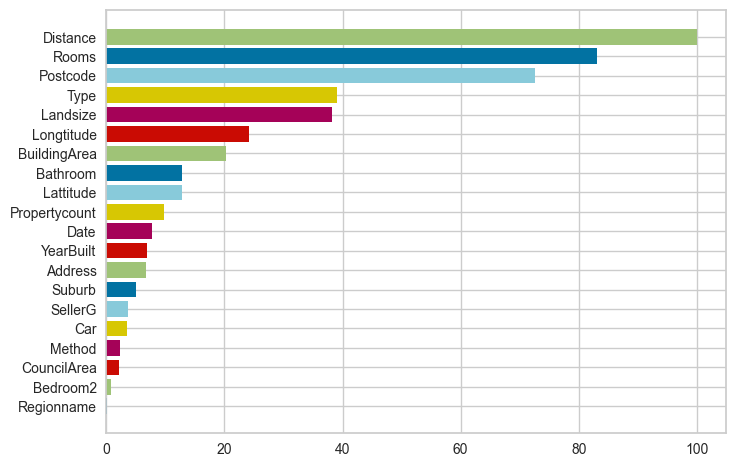

In [10]:
encoder = OrdinalEncoder()
housingdata[categorical] = encoder.fit_transform(housingdata[categorical].astype(str))

X1 = housingdata.drop(columns=["Price"])  # Features
y1= housingdata["Price"]  # Target


model1 = DecisionTreeRegressor(random_state=42)
viz1 = FeatureImportances(model1)
viz1.fit(X1, y1)

##### Imputing
https://medium.com/@ajayverma23/data-imputation-a-comprehensive-guide-to-handling-missing-values-b5c7d11c3488


#### Handling 'Car' NULL values
Since the number of NULL entries in Car is only about (62/13580) * 100 = 0.46% of the total number of rows, and its relative importance in predicting Price is low, we opt to drop these rows. This approach reduces preprocessing complexity without sacrificing valuable information for our analysis.

In [11]:
# drop rows accordingly 
housingdata = housingdata.dropna(subset=['Car'])

#### Handling 'BuildingArea' NULL values
Since the number of NULL entries in BuildingArea is about (6450/13580) * 100 = 47.5% of the total number of rows, which is significant, and its relative importance in predicting Price is moderate, we will impute the missing values using the median, grouped by Suburb, Rooms, and Type. This is because building area typically scales with number of rooms and depends on housing type, and suburbs offer spatial consistency.

In [12]:
# Impute BuildingArea based on median within Suburb + Distance + Rooms
housingdata['BuildingArea'] = housingdata.groupby(['Suburb', 'Rooms', 'Type'])['BuildingArea'].transform(
    lambda x: x.fillna(x.median())
)

c:\GitHub\dsaiMiniProject\.env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\GitHub\dsaiMiniProject\.env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\GitHub\dsaiMiniProject\.env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\GitHub\dsaiMiniProject\.env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\GitHub\dsaiMiniProject\.env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\GitHub\dsaiMiniProject\.env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarnin

#### Handling 'YearBuilt' NULL values
Since the number of NULL entries in YearBuilt is about (5375/13580) * 100 = 39.6% of the total number of rows, which is moderate, and its relative importance in predicting Price is also moderate, we will impute the missing values using the median, grouped by Suburb and Type. This leverages contextual property characteristics to estimate construction year more accurately.

In [13]:
# Impute YearBuilt based on Suburb + Type
housingdata['YearBuilt'] = housingdata.groupby(['Suburb', 'Type'])['YearBuilt'].transform(
    lambda x: x.fillna(x.median())
)

c:\GitHub\dsaiMiniProject\.env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\GitHub\dsaiMiniProject\.env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\GitHub\dsaiMiniProject\.env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\GitHub\dsaiMiniProject\.env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\GitHub\dsaiMiniProject\.env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\GitHub\dsaiMiniProject\.env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarnin

#### Handling 'CouncilArea' NULL values
Since the number of NULL entries in CouncilArea is about (1369/13580) * 100 = 10.1% of the total number of rows, which is moderate. Given that CouncilArea has moderate feature importance in predicting Price, we will impute the missing values using the mode, grouped by Suburb, as council areas typically align with geographic boundaries.

In [14]:
# Impute CouncilArea (categorical) based on Suburb
housingdata['CouncilArea'] = housingdata.groupby('Suburb')['CouncilArea'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')
)

Checking the null values again

In [15]:
print(housingdata.isnull().sum())

Suburb             0
Address            0
Rooms              0
Type               0
Price              0
Method             0
SellerG            0
Date               0
Distance           0
Postcode           0
Bedroom2           0
Bathroom           0
Car                0
Landsize           0
BuildingArea     440
YearBuilt         80
CouncilArea        0
Lattitude          0
Longtitude         0
Regionname         0
Propertycount      0
dtype: int64


Given that we still have a small proportion of NULL values left even after our imputing, we will choose to drop these rows.

In [16]:
housingdata = housingdata.dropna(subset=['BuildingArea'])
housingdata = housingdata.dropna(subset=['YearBuilt'])

In [17]:
print(housingdata.isnull().sum())

Suburb           0
Address          0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
Bedroom2         0
Bathroom         0
Car              0
Landsize         0
BuildingArea     0
YearBuilt        0
CouncilArea      0
Lattitude        0
Longtitude       0
Regionname       0
Propertycount    0
dtype: int64


After imputing, all the categorical rows have been converted to numerical rows, hence we have to convert them back. 

In [18]:
housingdata[categorical] = housingdata[categorical].astype('object')

# Check the updated dtypes
print(housingdata.dtypes)

Suburb            object
Address           object
Rooms              int64
Type              object
Price            float64
Method            object
SellerG           object
Date              object
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
CouncilArea       object
Lattitude        float64
Longtitude       float64
Regionname        object
Propertycount    float64
dtype: object


#### 2b. Checking for, and removing, duplicate values

In [19]:
print(housingdata.duplicated().sum())

0


Since there are no duplicate values, we will continue with our analysis.

### 3. Analysis of Response Variable Price

In [20]:
price = housingdata["Price"]
price.describe()

count    1.306600e+04
mean     1.077267e+06
std      6.404485e+05
min      8.500000e+04
25%      6.500000e+05
50%      9.035000e+05
75%      1.330000e+06
max      9.000000e+06
Name: Price, dtype: float64

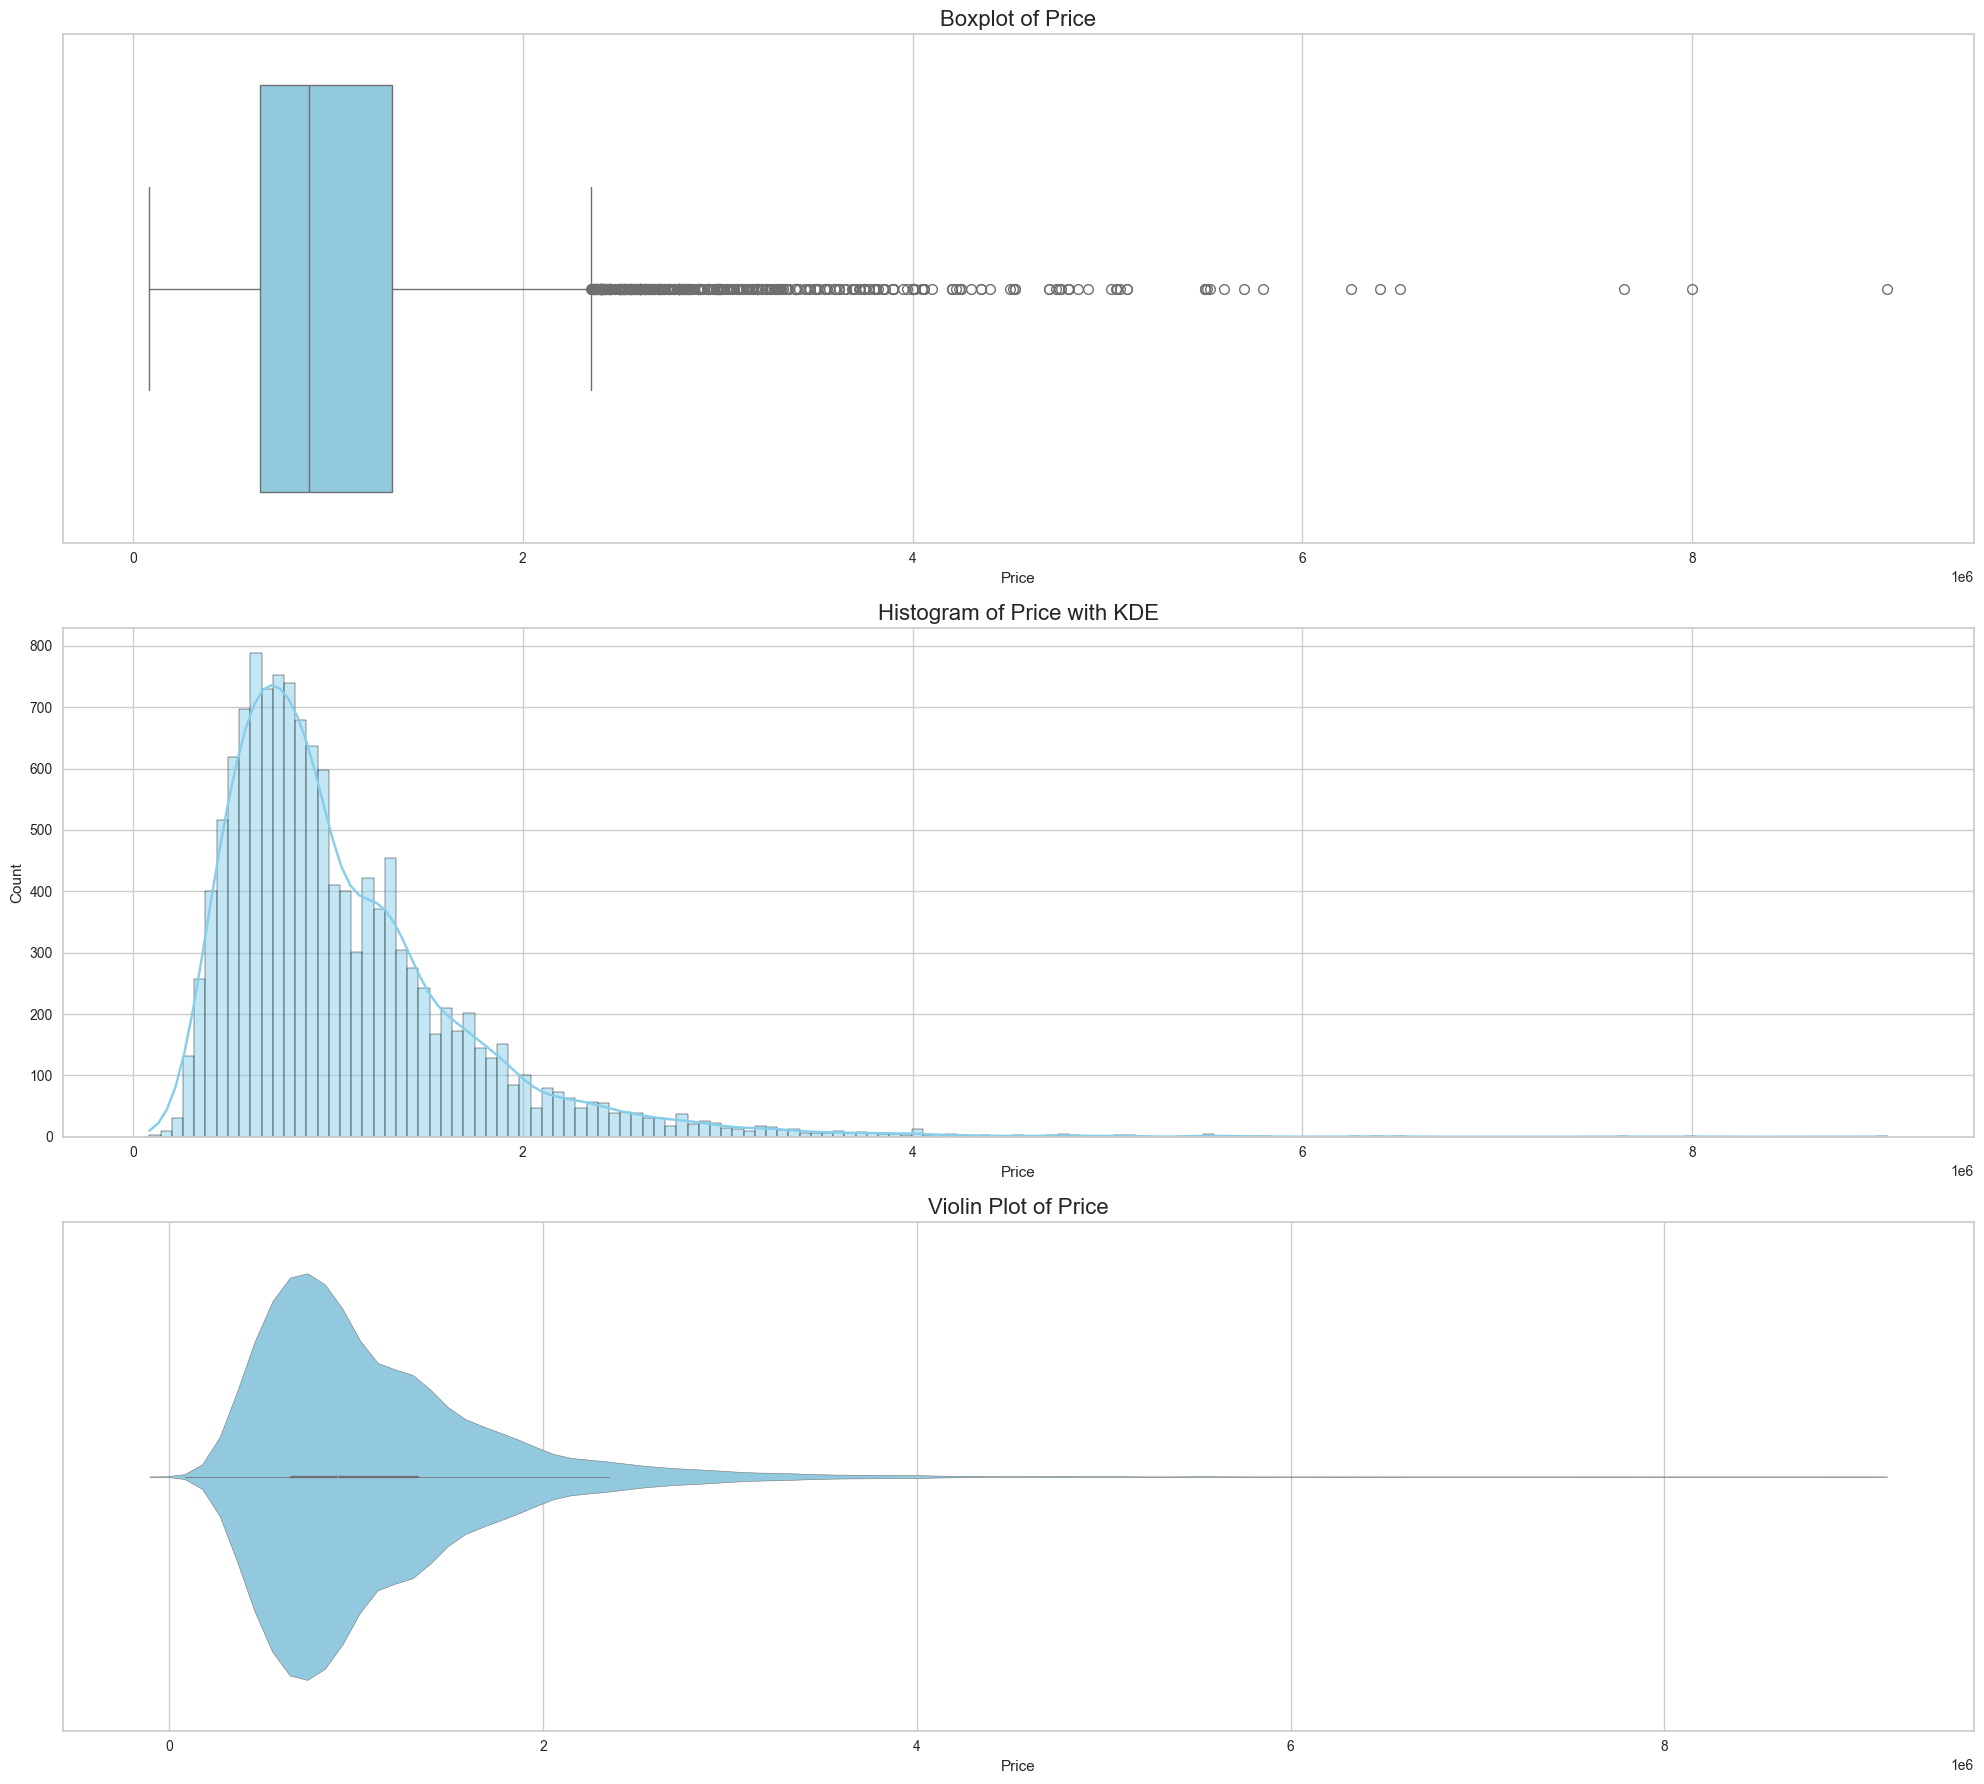

In [21]:
f, axes = plt.subplots(3,1, figsize=(20,18)) 

# Boxplot for "Price"
sb.boxplot(data=housingdata['Price'], orient='h', ax=axes[0], color='skyblue')
axes[0].set_title('Boxplot of Price', fontsize=16)

# Histogram for "Price" with KDE
sb.histplot(data=housingdata['Price'], ax=axes[1], kde=True, color='skyblue')
axes[1].set_title('Histogram of Price with KDE', fontsize=16)

# Violin plot for "Price"
sb.violinplot(data=housingdata['Price'], orient='h', ax=axes[2], color='skyblue')
axes[2].set_title('Violin Plot of Price', fontsize=16)

plt.tight_layout()  # Ensures proper spacing between plots
plt.show()

### 4. Univariate Analysis of Numerical Predictor Variables

#### 4.1 Boxplot for numerical features

In [22]:
numerical_without_price = housingdata.select_dtypes(include=[np.number]).drop(columns=["Price"])
numerical_without_price.describe()

Rooms      Distance  ...    Longtitude  Propertycount
count  13066.000000  13066.000000  ...  13066.000000   13066.000000
mean       2.933415     10.048117  ...    144.994105    7543.149089
std        0.932472      5.730516  ...      0.102292    4384.360761
min        1.000000      0.000000  ...    144.542370     389.000000
25%        2.000000      6.100000  ...    144.928700    4442.000000
50%        3.000000      9.200000  ...    144.999700    6567.000000
75%        3.000000     13.000000  ...    145.056880   10331.000000
max        8.000000     47.400000  ...    145.526350   21650.000000

[8 rows x 12 columns]

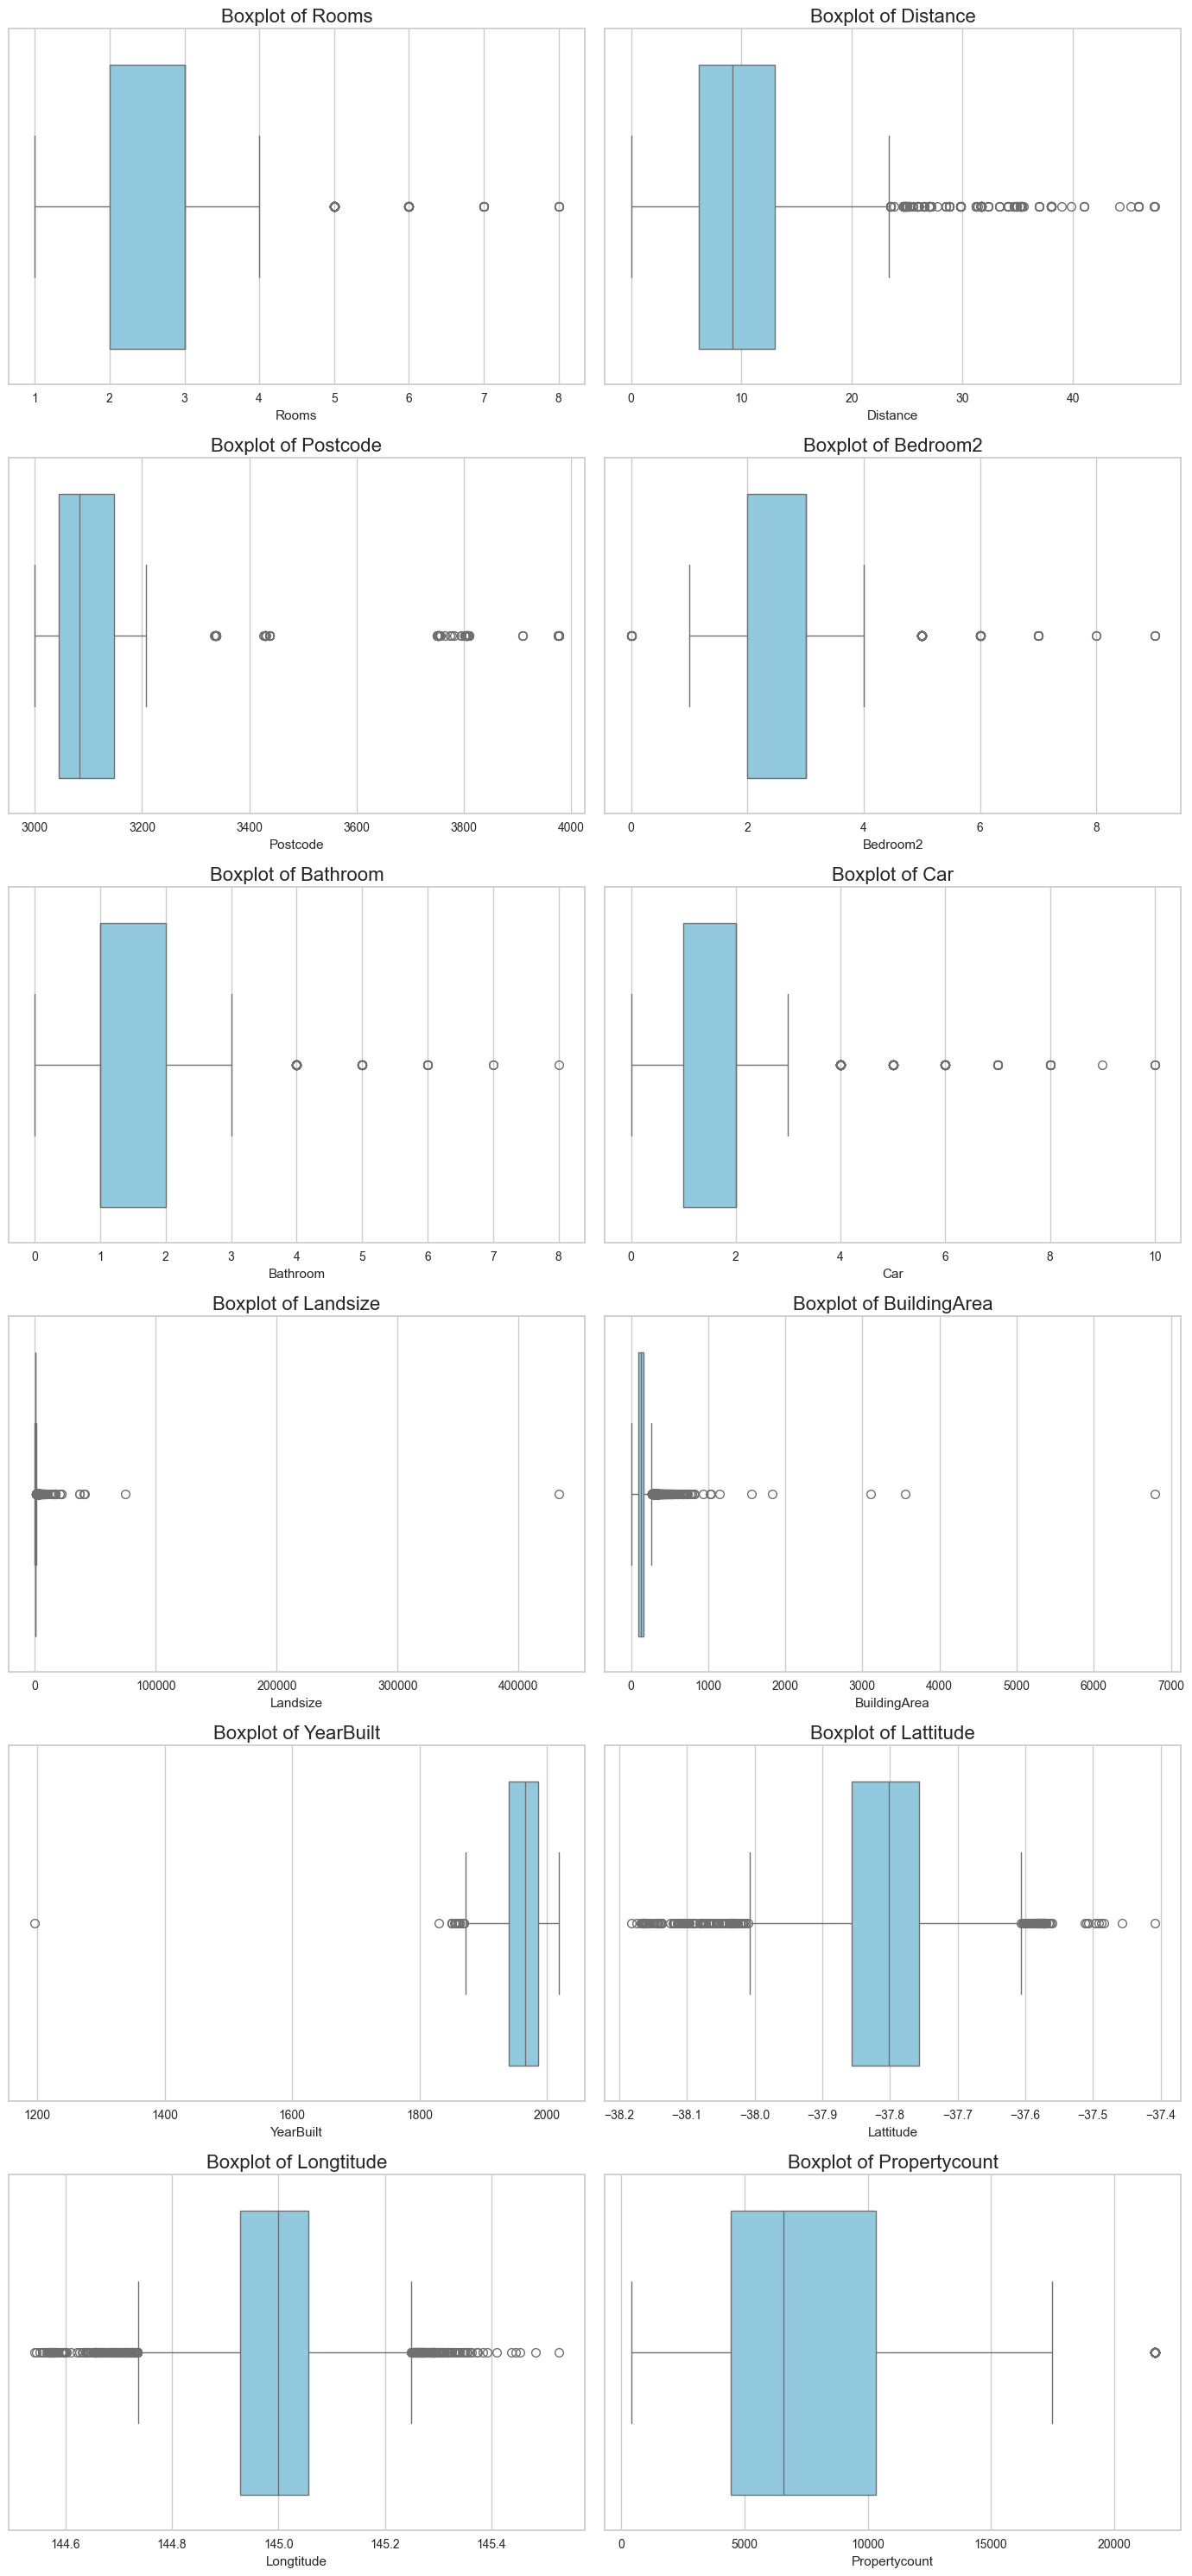

In [23]:
# Boxplot for all numerical features individually in a horizontal layout
num_features = len(numerical_without_price.columns)
plt.figure(figsize=(14, num_features // 2 * 5))  # Adjust the figure size dynamically

for i, feature in enumerate(numerical_without_price.columns):
    plt.subplot((num_features + 1) // 2, 2, i + 1)  # Ensure 2 boxplots per row
    sb.boxplot(data=housingdata[feature], orient='h', color='skyblue')
    plt.title(f'Boxplot of {feature}', fontsize=16)

plt.tight_layout()  # Ensures proper spacing between plots
plt.show()

For Comparison with all variables at the same time at the expense of visibility

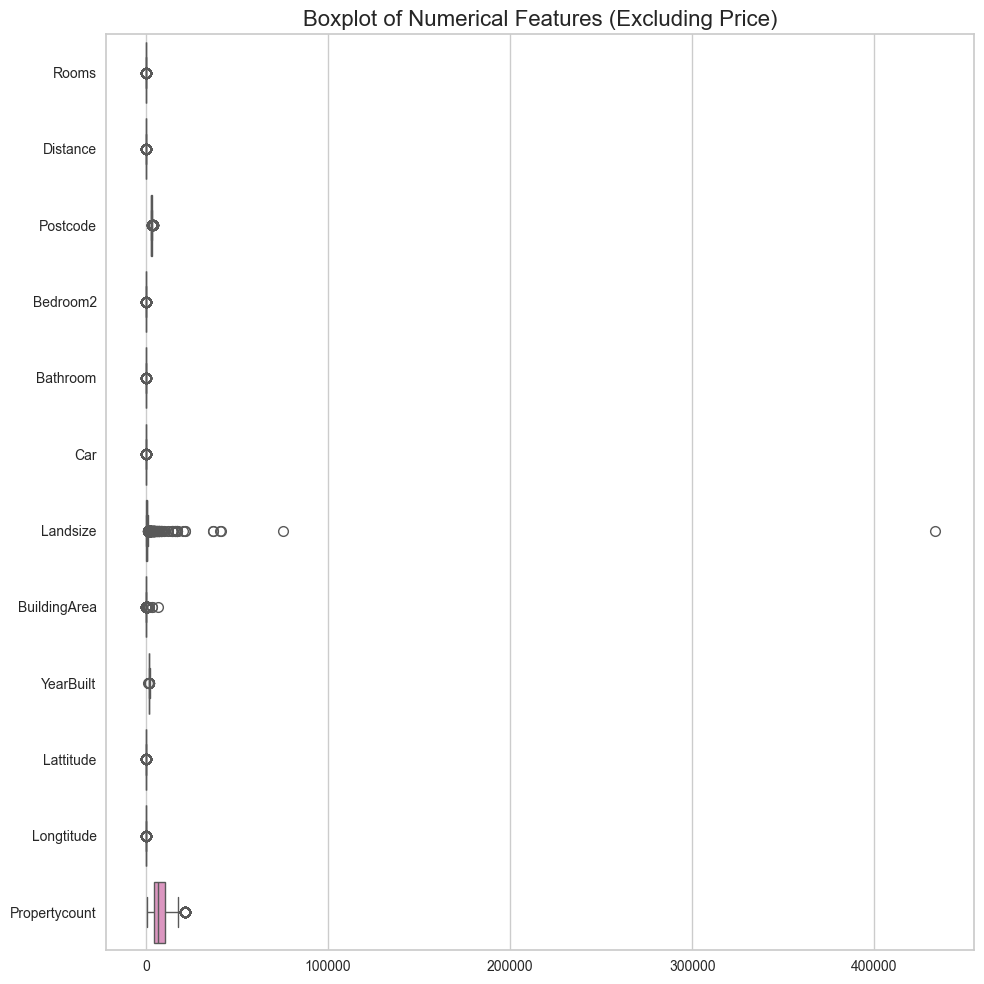

In [24]:
plt.figure(figsize=(10, 10))
sb.boxplot(data=numerical_without_price, orient='h', palette="Set2")
plt.title('Boxplot of Numerical Features (Excluding Price)', fontsize=16)
plt.tight_layout()  # Ensures proper spacing
plt.show()

#### 4.2 Histogram for numerical features

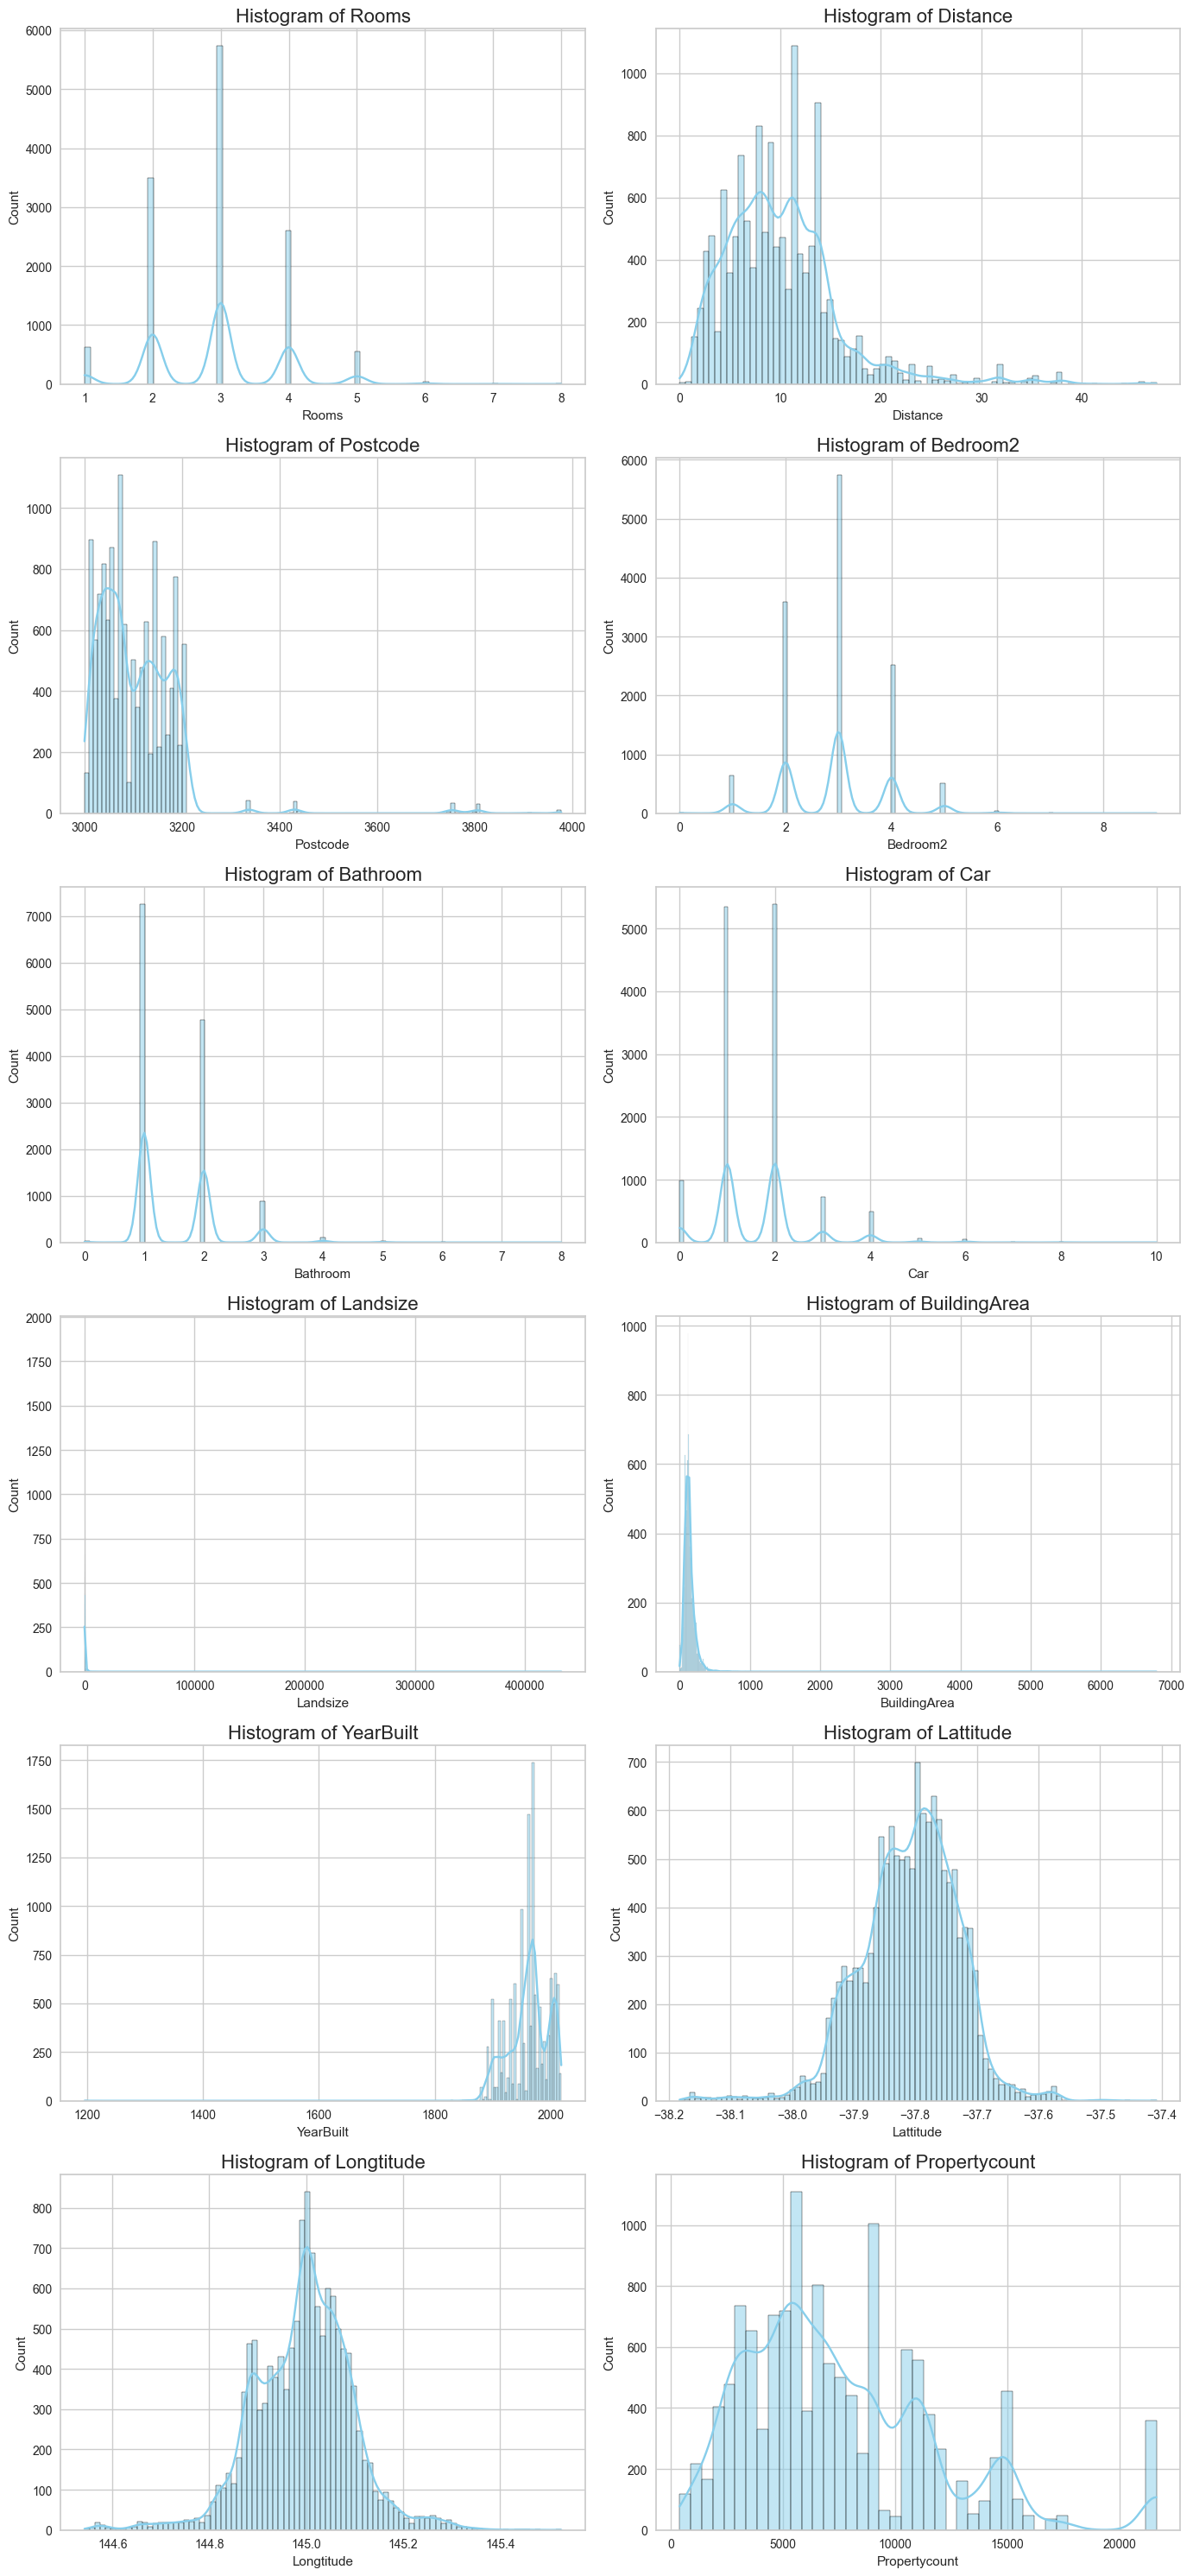

In [25]:
# Histogram for all numerical features individually in a horizontal layout
num_features = len(numerical_without_price.columns)
plt.figure(figsize=(14, num_features // 2 * 5))  # Adjust the figure size dynamically

for i, feature in enumerate(numerical_without_price.columns):
    plt.subplot((num_features + 1) // 2, 2, i + 1)  # Ensure 2 histograms per row
    sb.histplot(data=housingdata[feature], kde=True, color='skyblue', ax=plt.gca())
    plt.title(f'Histogram of {feature}', fontsize=16)

plt.tight_layout()  # Ensures proper spacing between plots
plt.show()

#### 4.3 Violin plot for numerical features

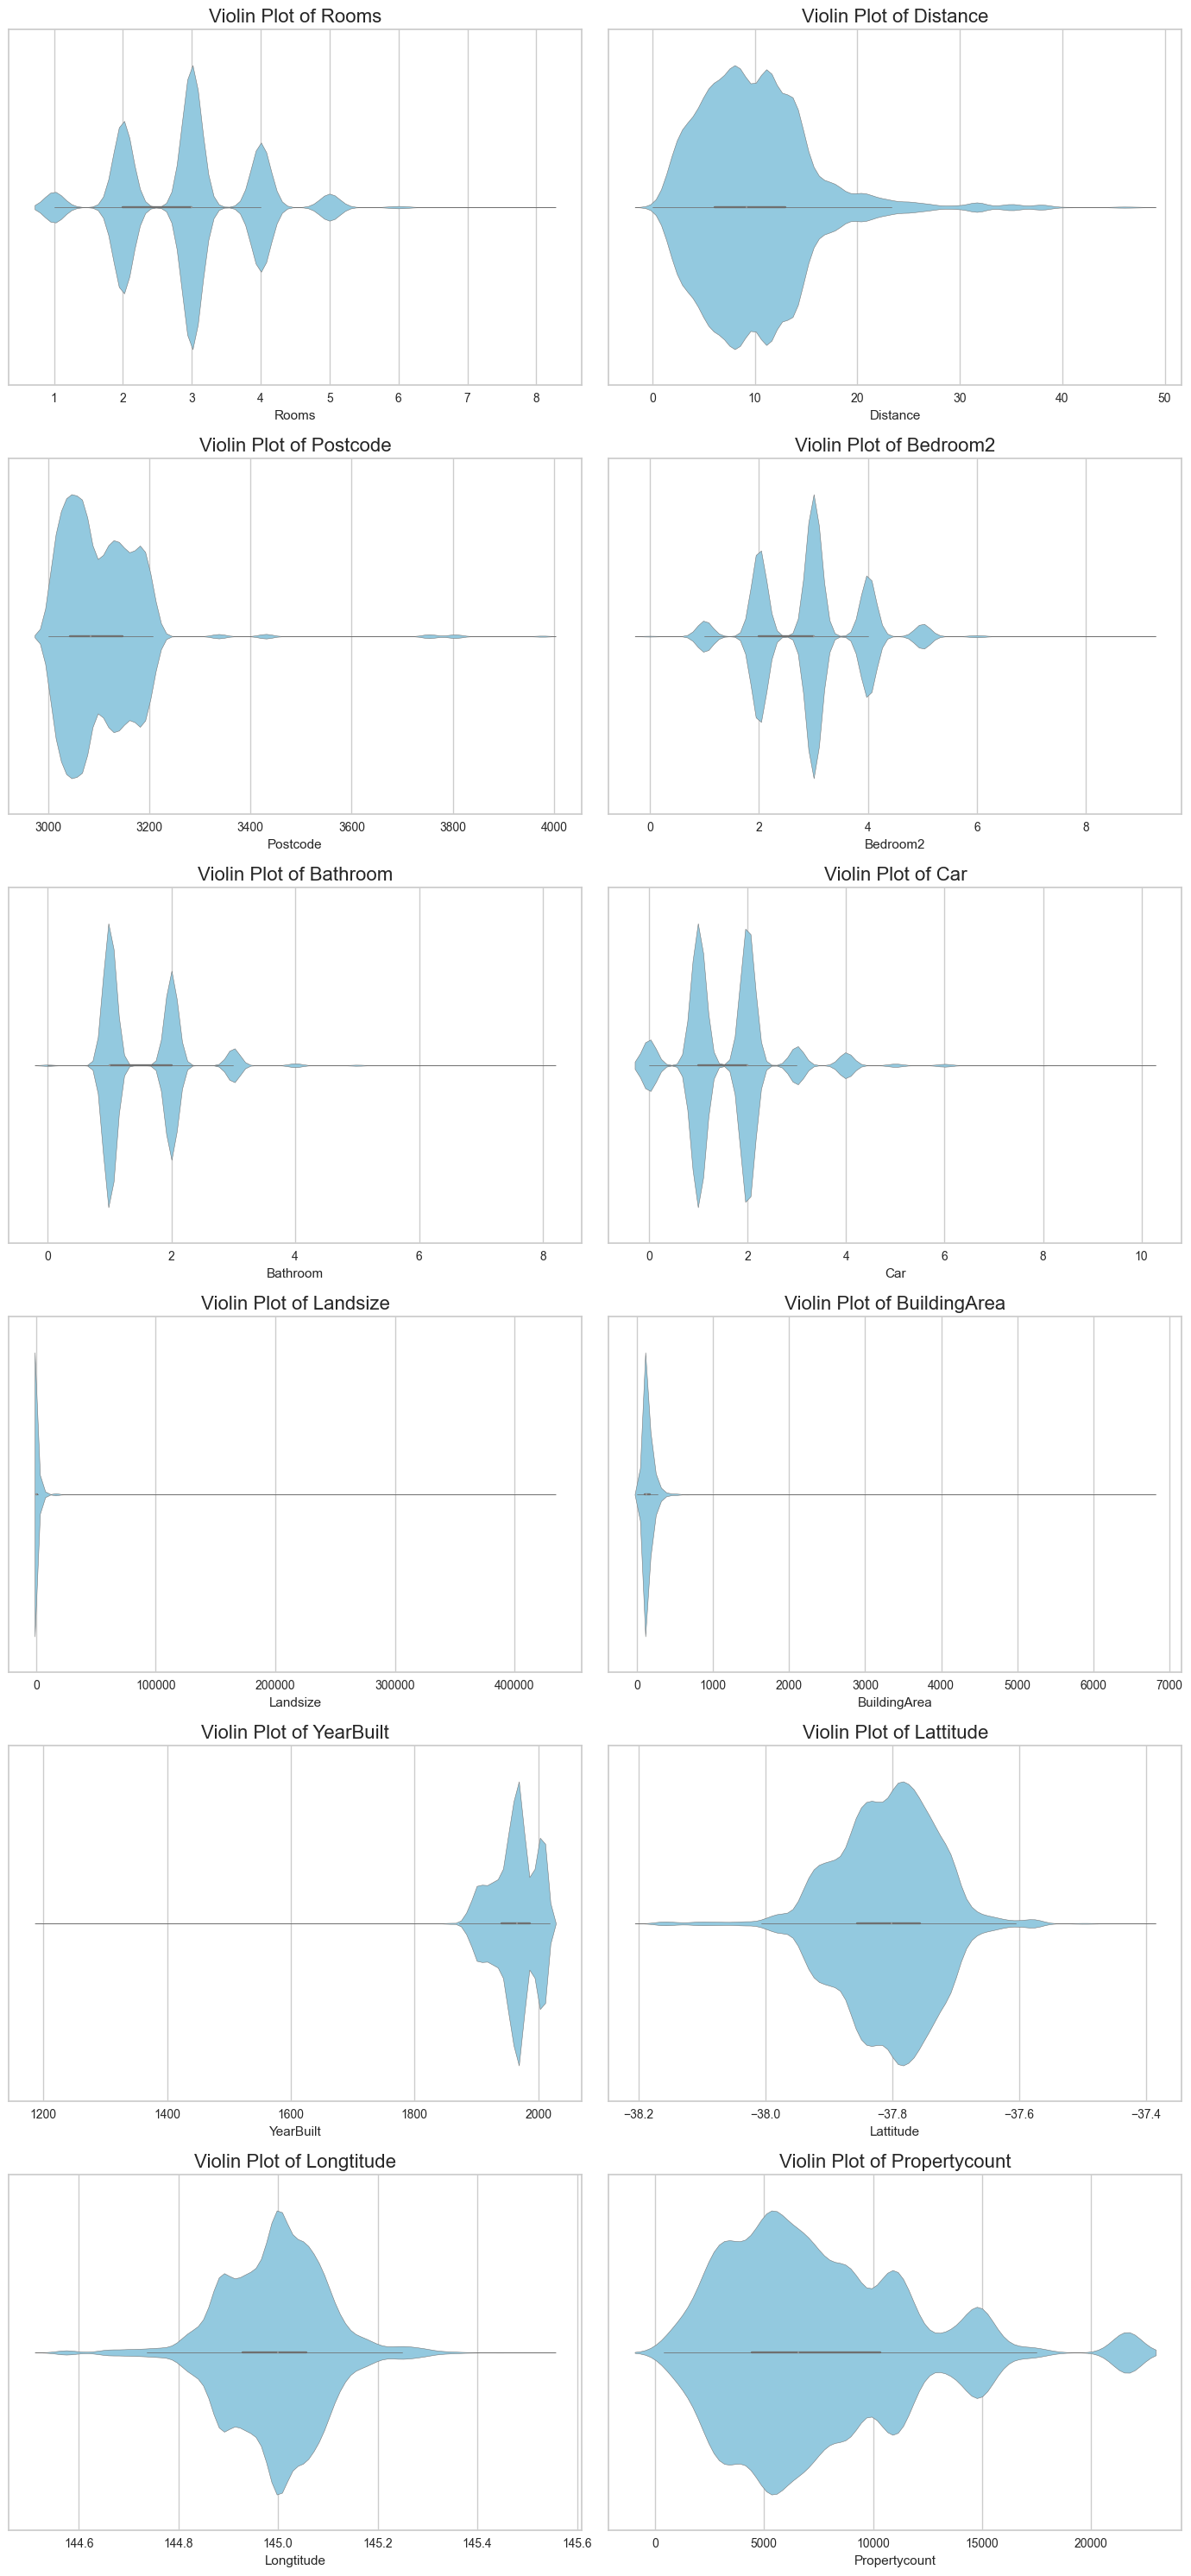

In [26]:
# Violin plot for all numerical features individually in a horizontal layout
num_features = len(numerical_without_price.columns)
plt.figure(figsize=(14, num_features // 2 * 5))  # Adjust the figure size dynamically

for i, feature in enumerate(numerical_without_price.columns):
    plt.subplot((num_features + 1) // 2, 2, i + 1)  # Ensure 2 violin plots per row
    sb.violinplot(data=housingdata[feature], orient='h', hue=None, color='skyblue', ax=plt.gca())  # Set hue=None
    plt.title(f'Violin Plot of {feature}', fontsize=16)

plt.tight_layout()  # Ensures proper spacing between plots
plt.show()

#### 4.4 Correlation Matrix of numerical features

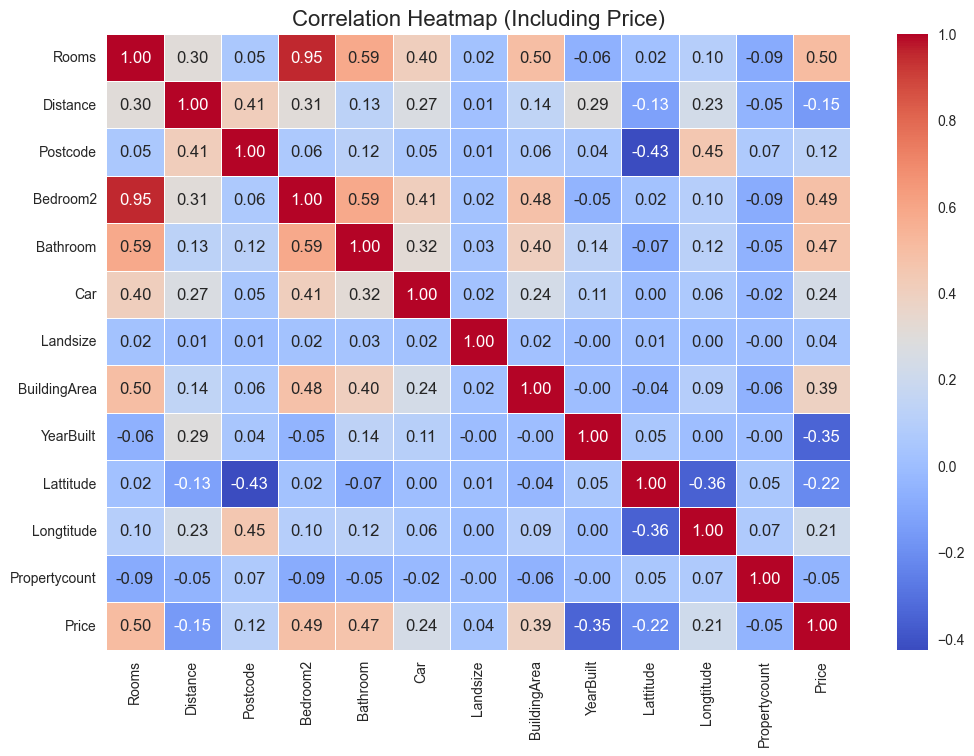

In [27]:
plt.figure(figsize=(12, 8))
numeric_features = list(numerical_without_price.columns) + ['Price']
correlation_matrix = housingdata[numeric_features].corr()

sb.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Heatmap (Including Price)", fontsize=16)
plt.show()

#### 4.5 Scatter Plot of numerical features against Price

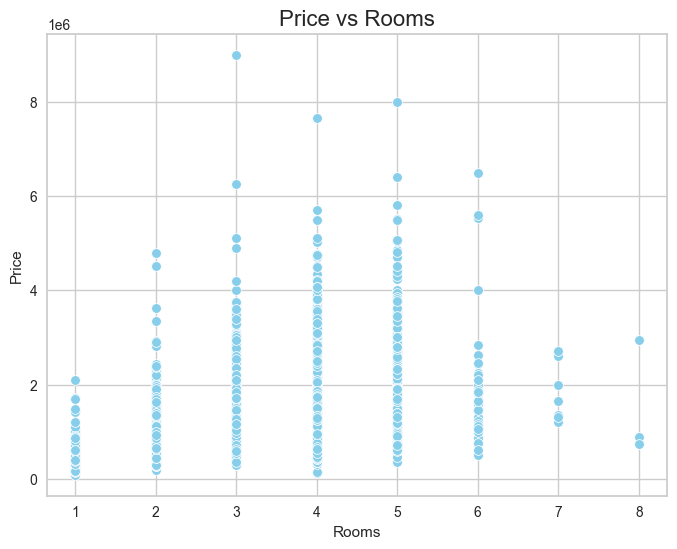

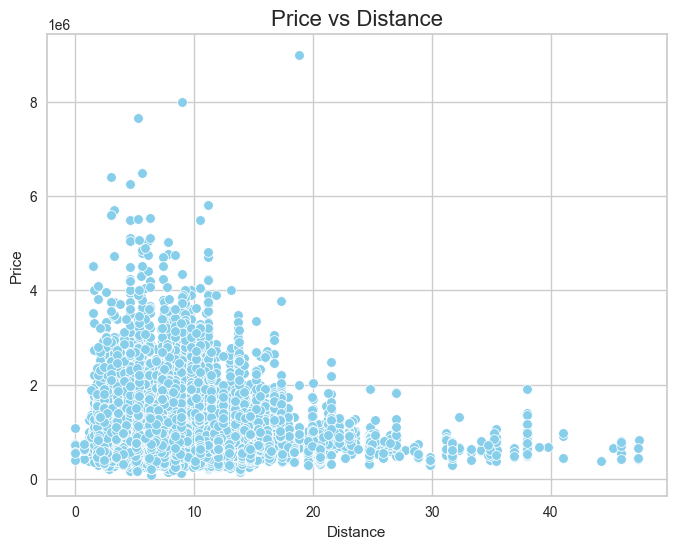

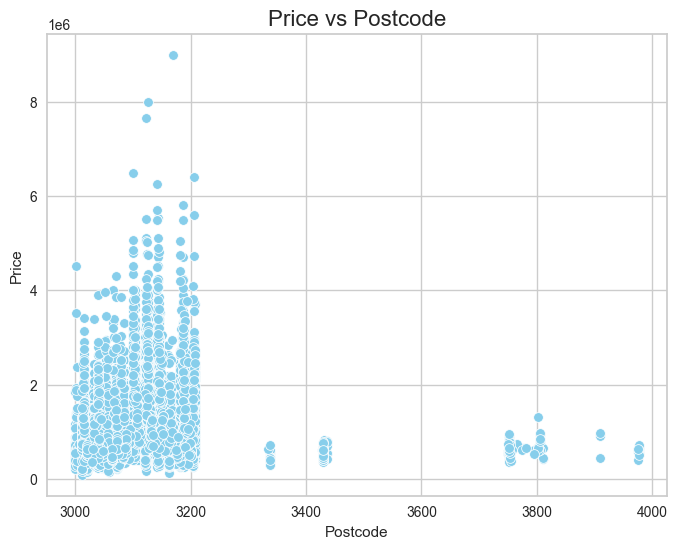

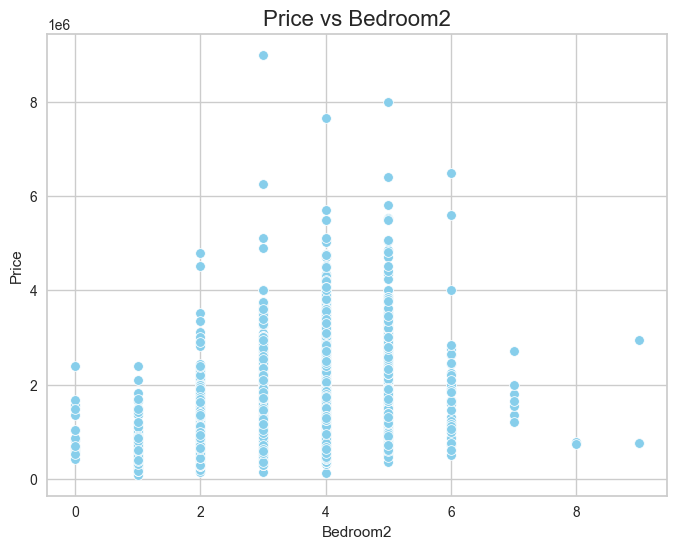

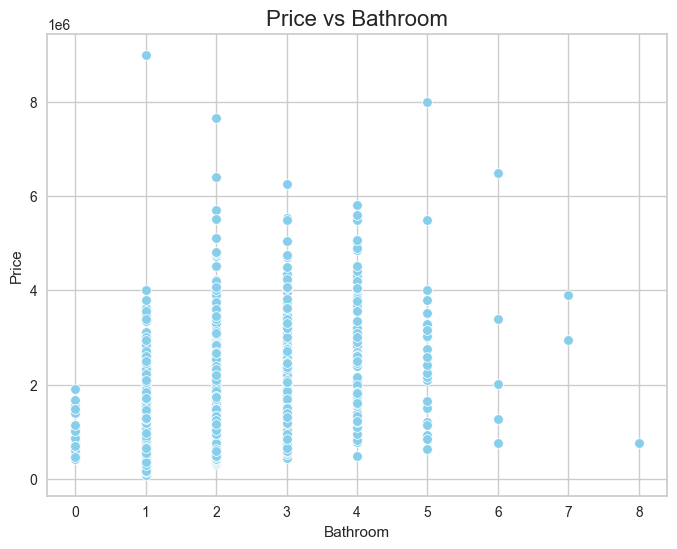

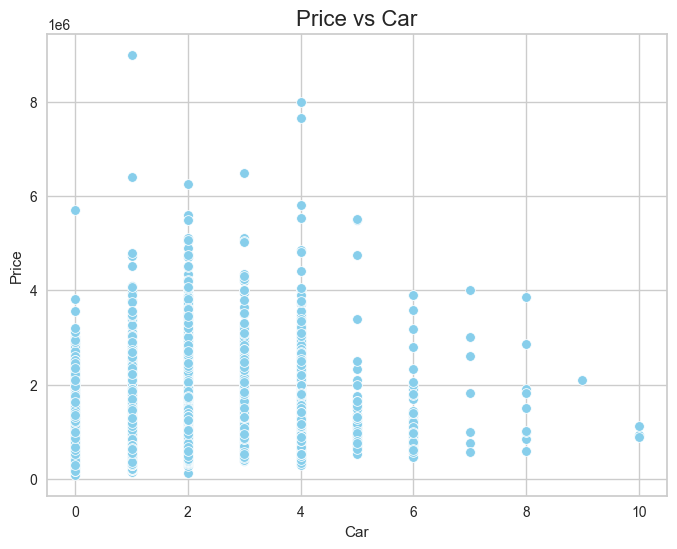

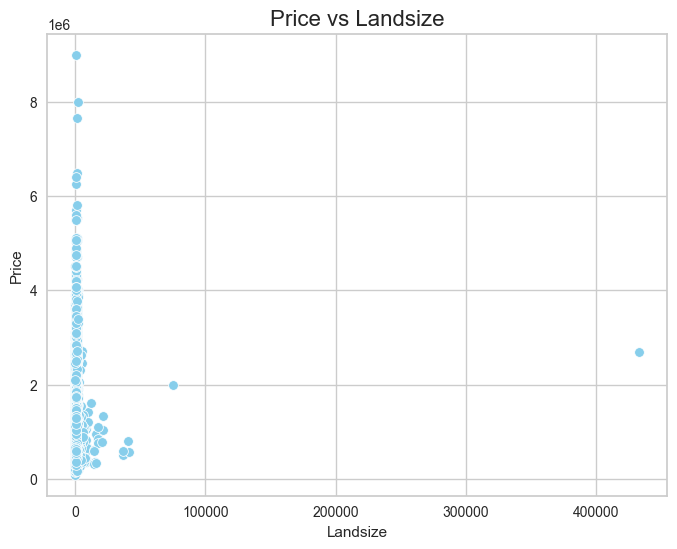

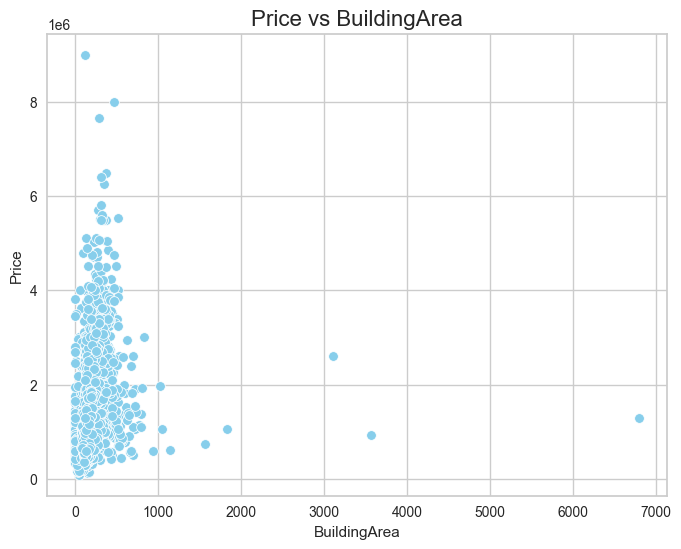

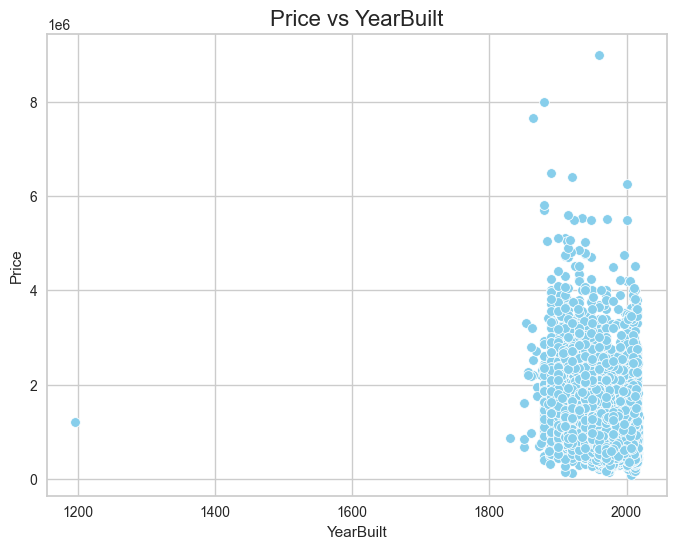

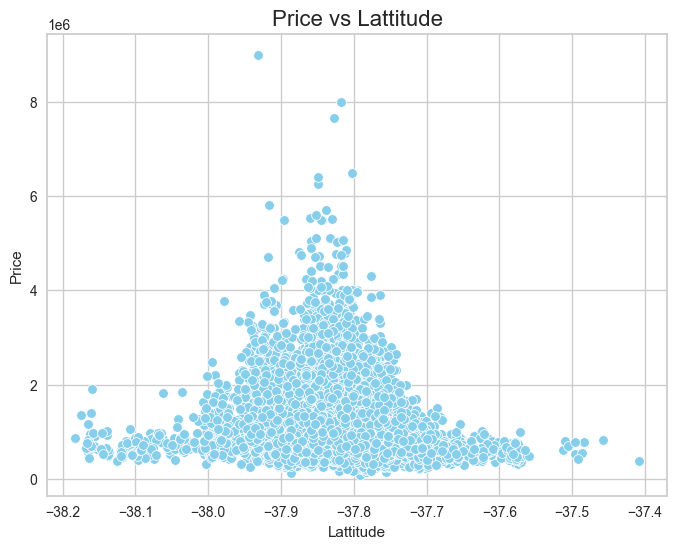

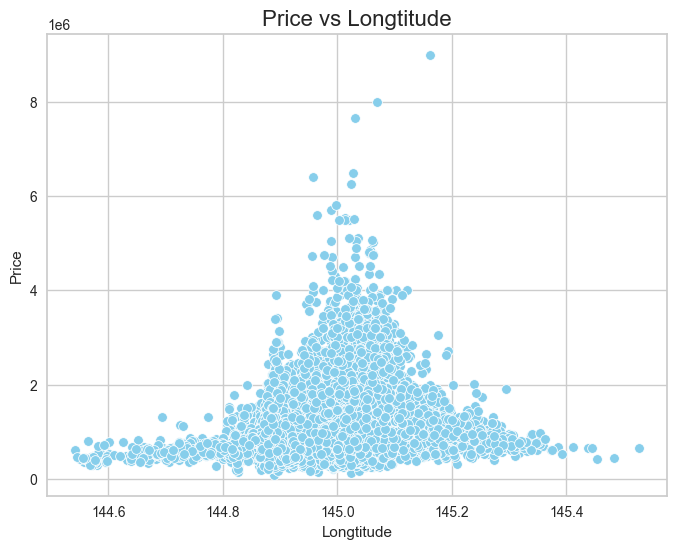

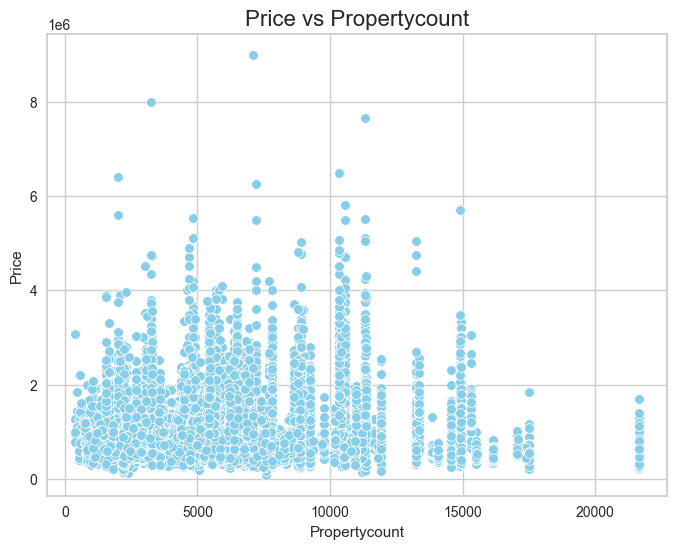

In [28]:
# Scatter Plots for Numerical Features excluding 'Price' against Price
for col in numerical_without_price.columns:
    plt.figure(figsize=(8, 6))
    sb.scatterplot(data=housingdata, x=col, y="Price", color='skyblue')
    plt.title(f"Price vs {col}", fontsize=16)
    plt.show()

### 5. Analysis of Categorical Variables
5.1 Distribution of each variable with a count plot\
5.2 Box Plot of categorical variable and price

To recap, the categorical variables of the dataset are ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname'].

Before we begin analysis of the categorical variables, let's undo the encoding performed earlier for the Decision Tree Regression so we can obtain the original string values. Let's take a look at the description of the categorical variables as well. 

In [29]:
housingdata[categorical] = encoder.inverse_transform(housingdata[categorical])
housingdata[categorical].describe().T

count unique                    top  freq
Suburb       13066    300              Reservoir   359
Address      13066  12874            28 Blair St     3
Type         13066      3                      h  9142
Method       13066      5                      S  8701
SellerG      13066    263                 Nelson  1532
Date         13066     58             27/05/2017   445
CouncilArea  13066     33                    nan  1252
Regionname   13066      8  Southern Metropolitan  4547

Additionally, let us perform frequency counts for each categorical variable.

In [30]:
print("\n=== Frequency Counts for Categorical Variables ===\n")
for col in categorical:
    print(f"--- {col} ---")
    print(housingdata[col].value_counts())
    print("\n")


=== Frequency Counts for Categorical Variables ===

--- Suburb ---
Suburb
Reservoir         359
Richmond          259
Bentleigh East    249
Preston           237
Brunswick         221
                 ... 
Whittlesea          1
Wallan              1
Campbellfield       1
Plumpton            1
Kooyong             1
Name: count, Length: 300, dtype: int64


--- Address ---
Address
28 Blair St       3
14 Arthur St      3
13 Robinson St    3
2 Bruce St        3
5 Margaret St     3
                 ..
20 Airds Rd       1
16 Benambra Dr    1
50 Caroline Dr    1
7 Dove Ct         1
129 Charles St    1
Name: count, Length: 12874, dtype: int64


--- Type ---
Type
h    9142
u    2903
t    1021
Name: count, dtype: int64


--- Method ---
Method
S     8701
SP    1634
PI    1509
VB    1134
SA      88
Name: count, dtype: int64


--- SellerG ---
SellerG
Nelson           1532
Jellis           1277
hockingstuart    1131
Barry             972
Ray               669
                 ... 
Area              

#### Analysis of 'Suburb' Variable

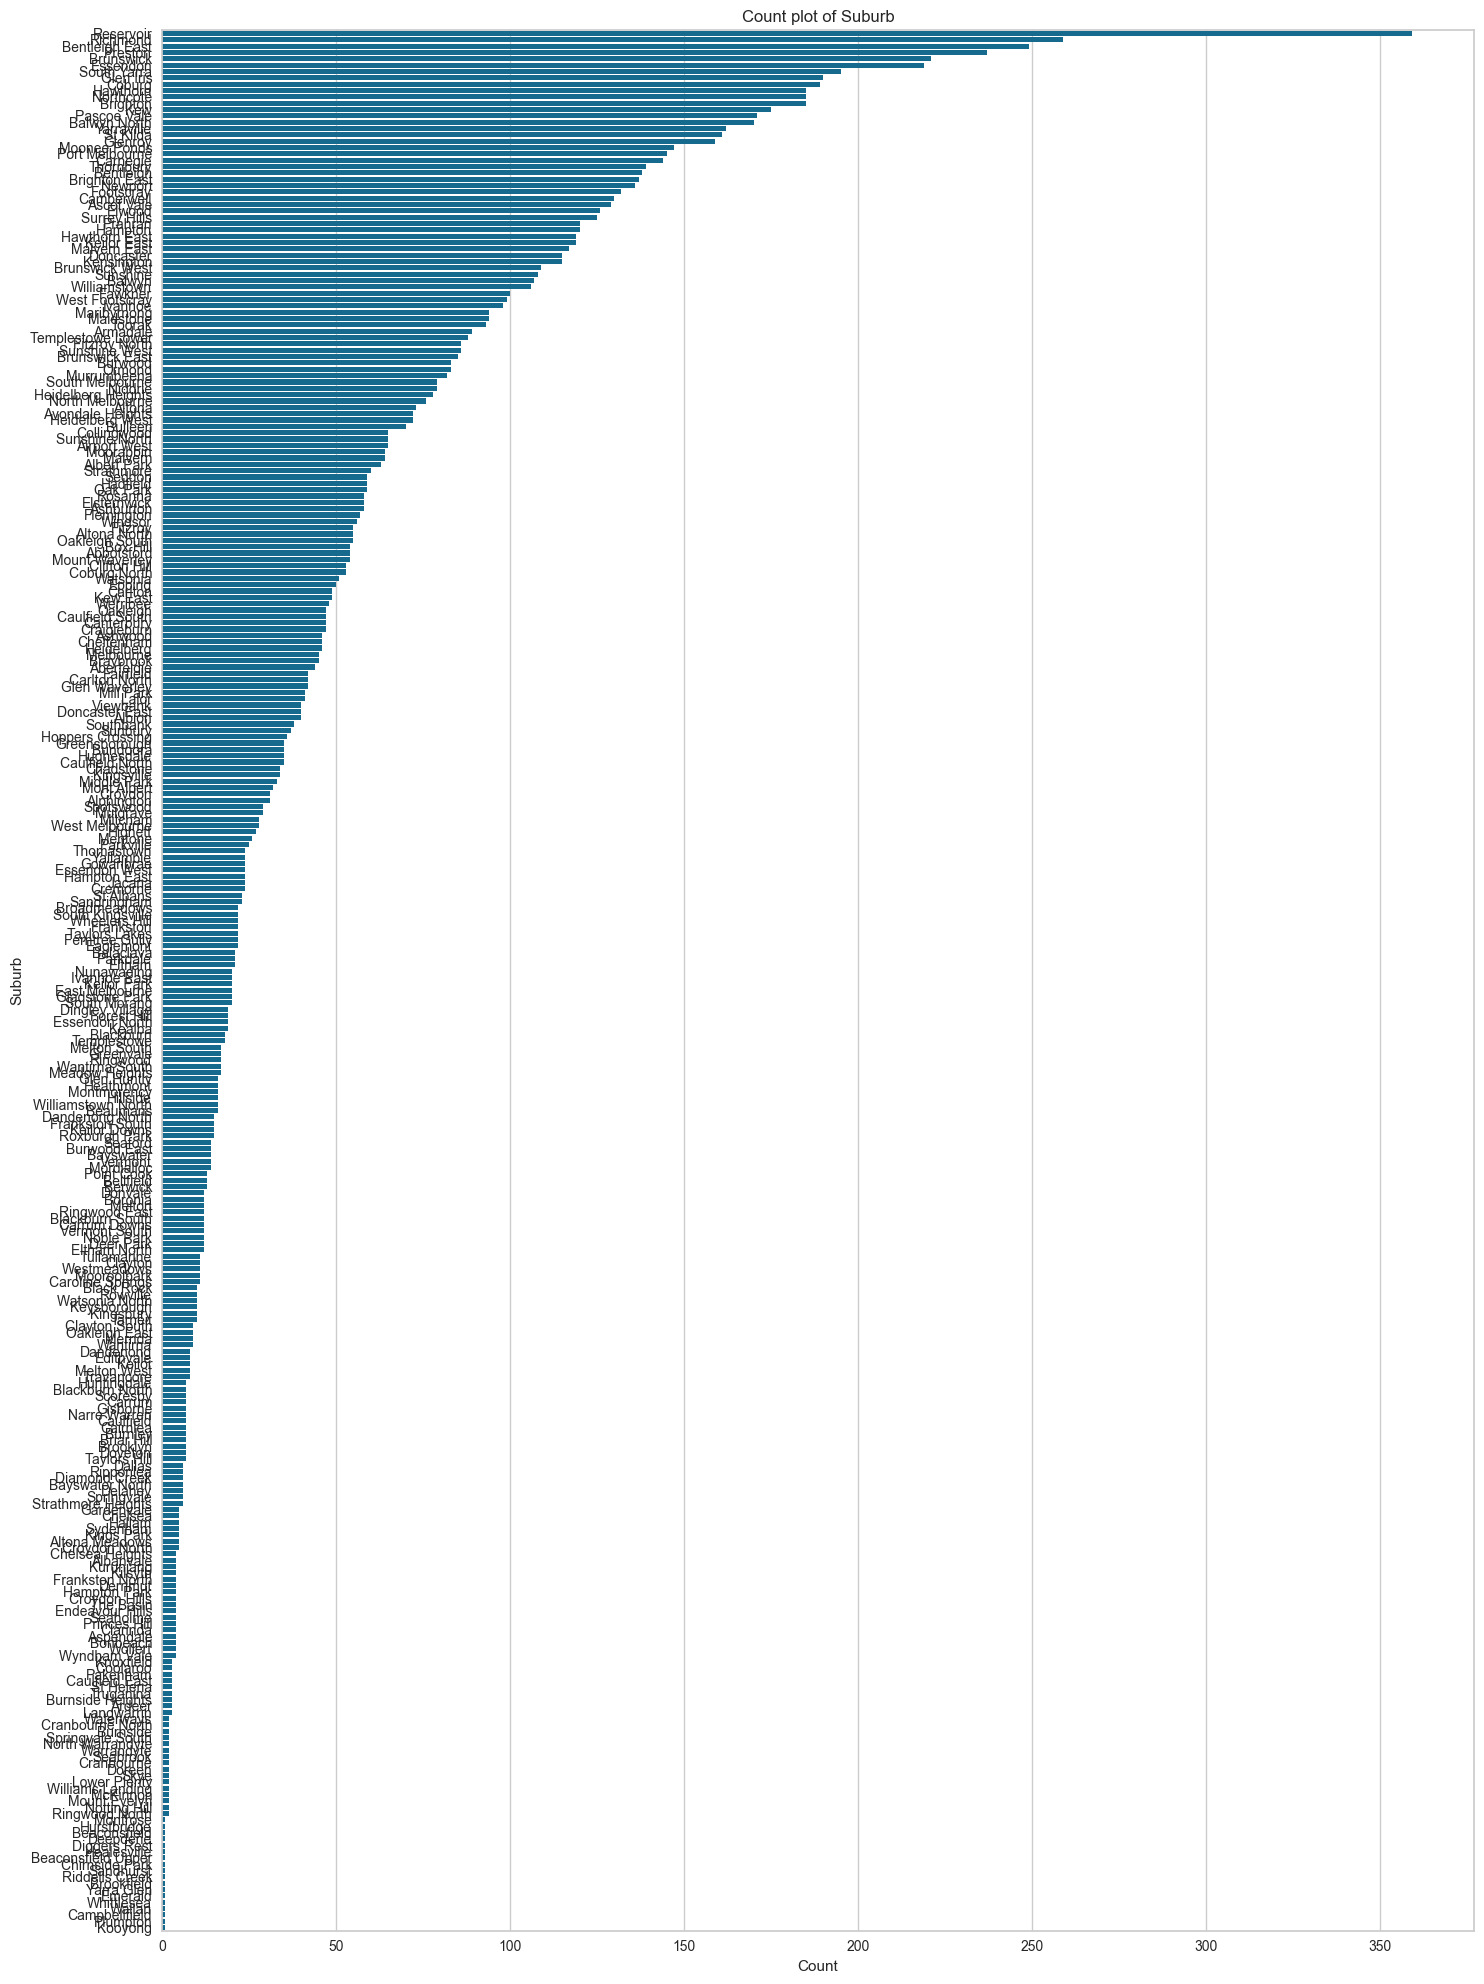

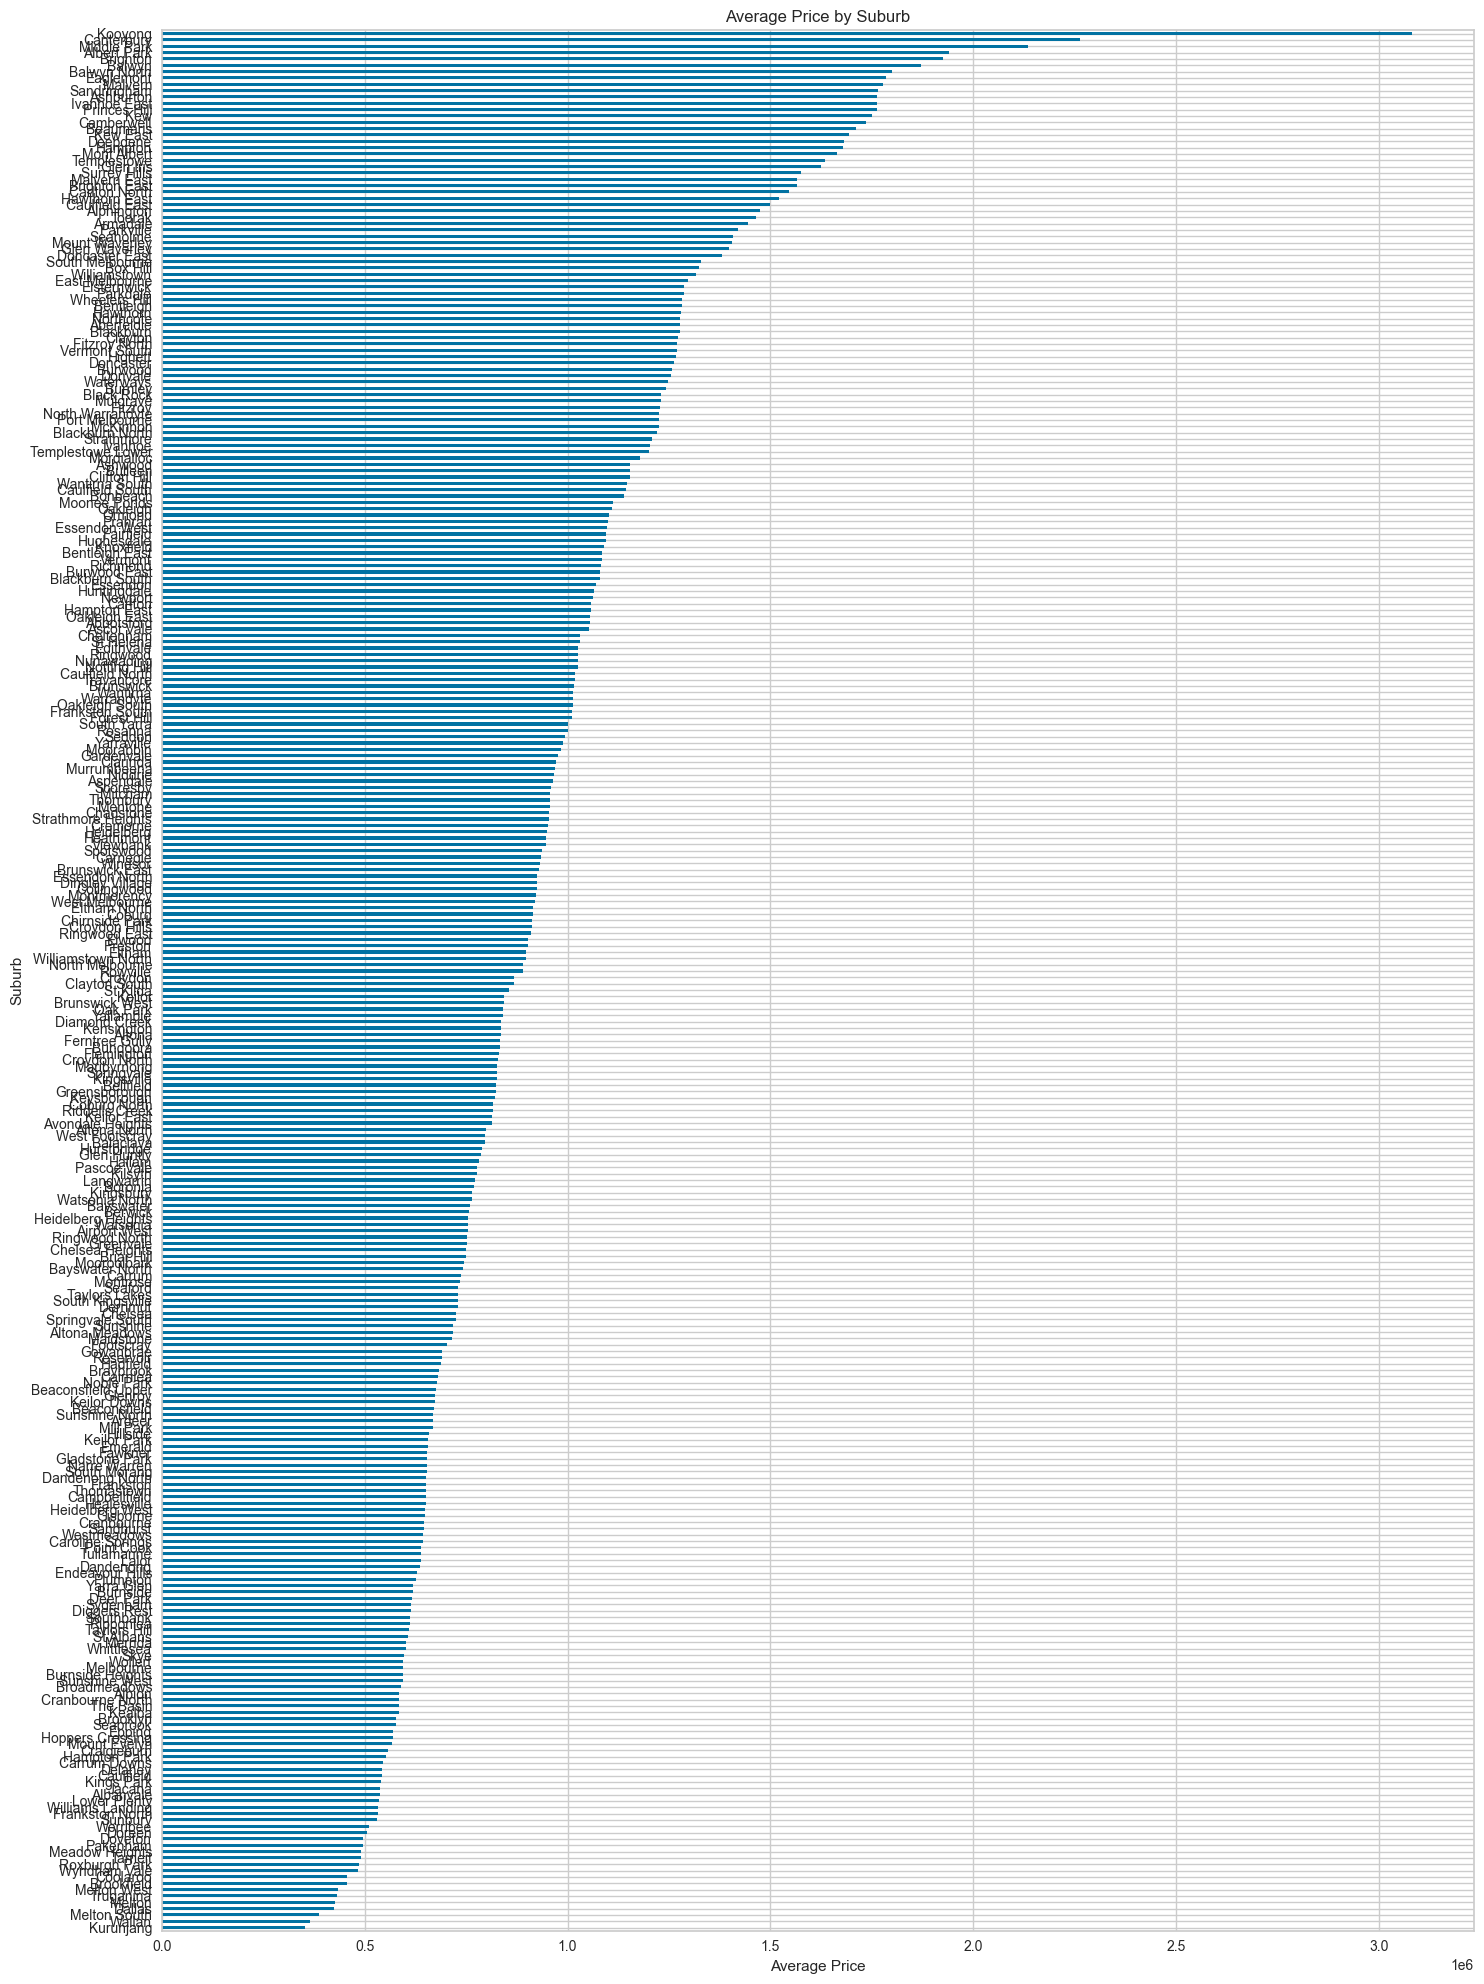

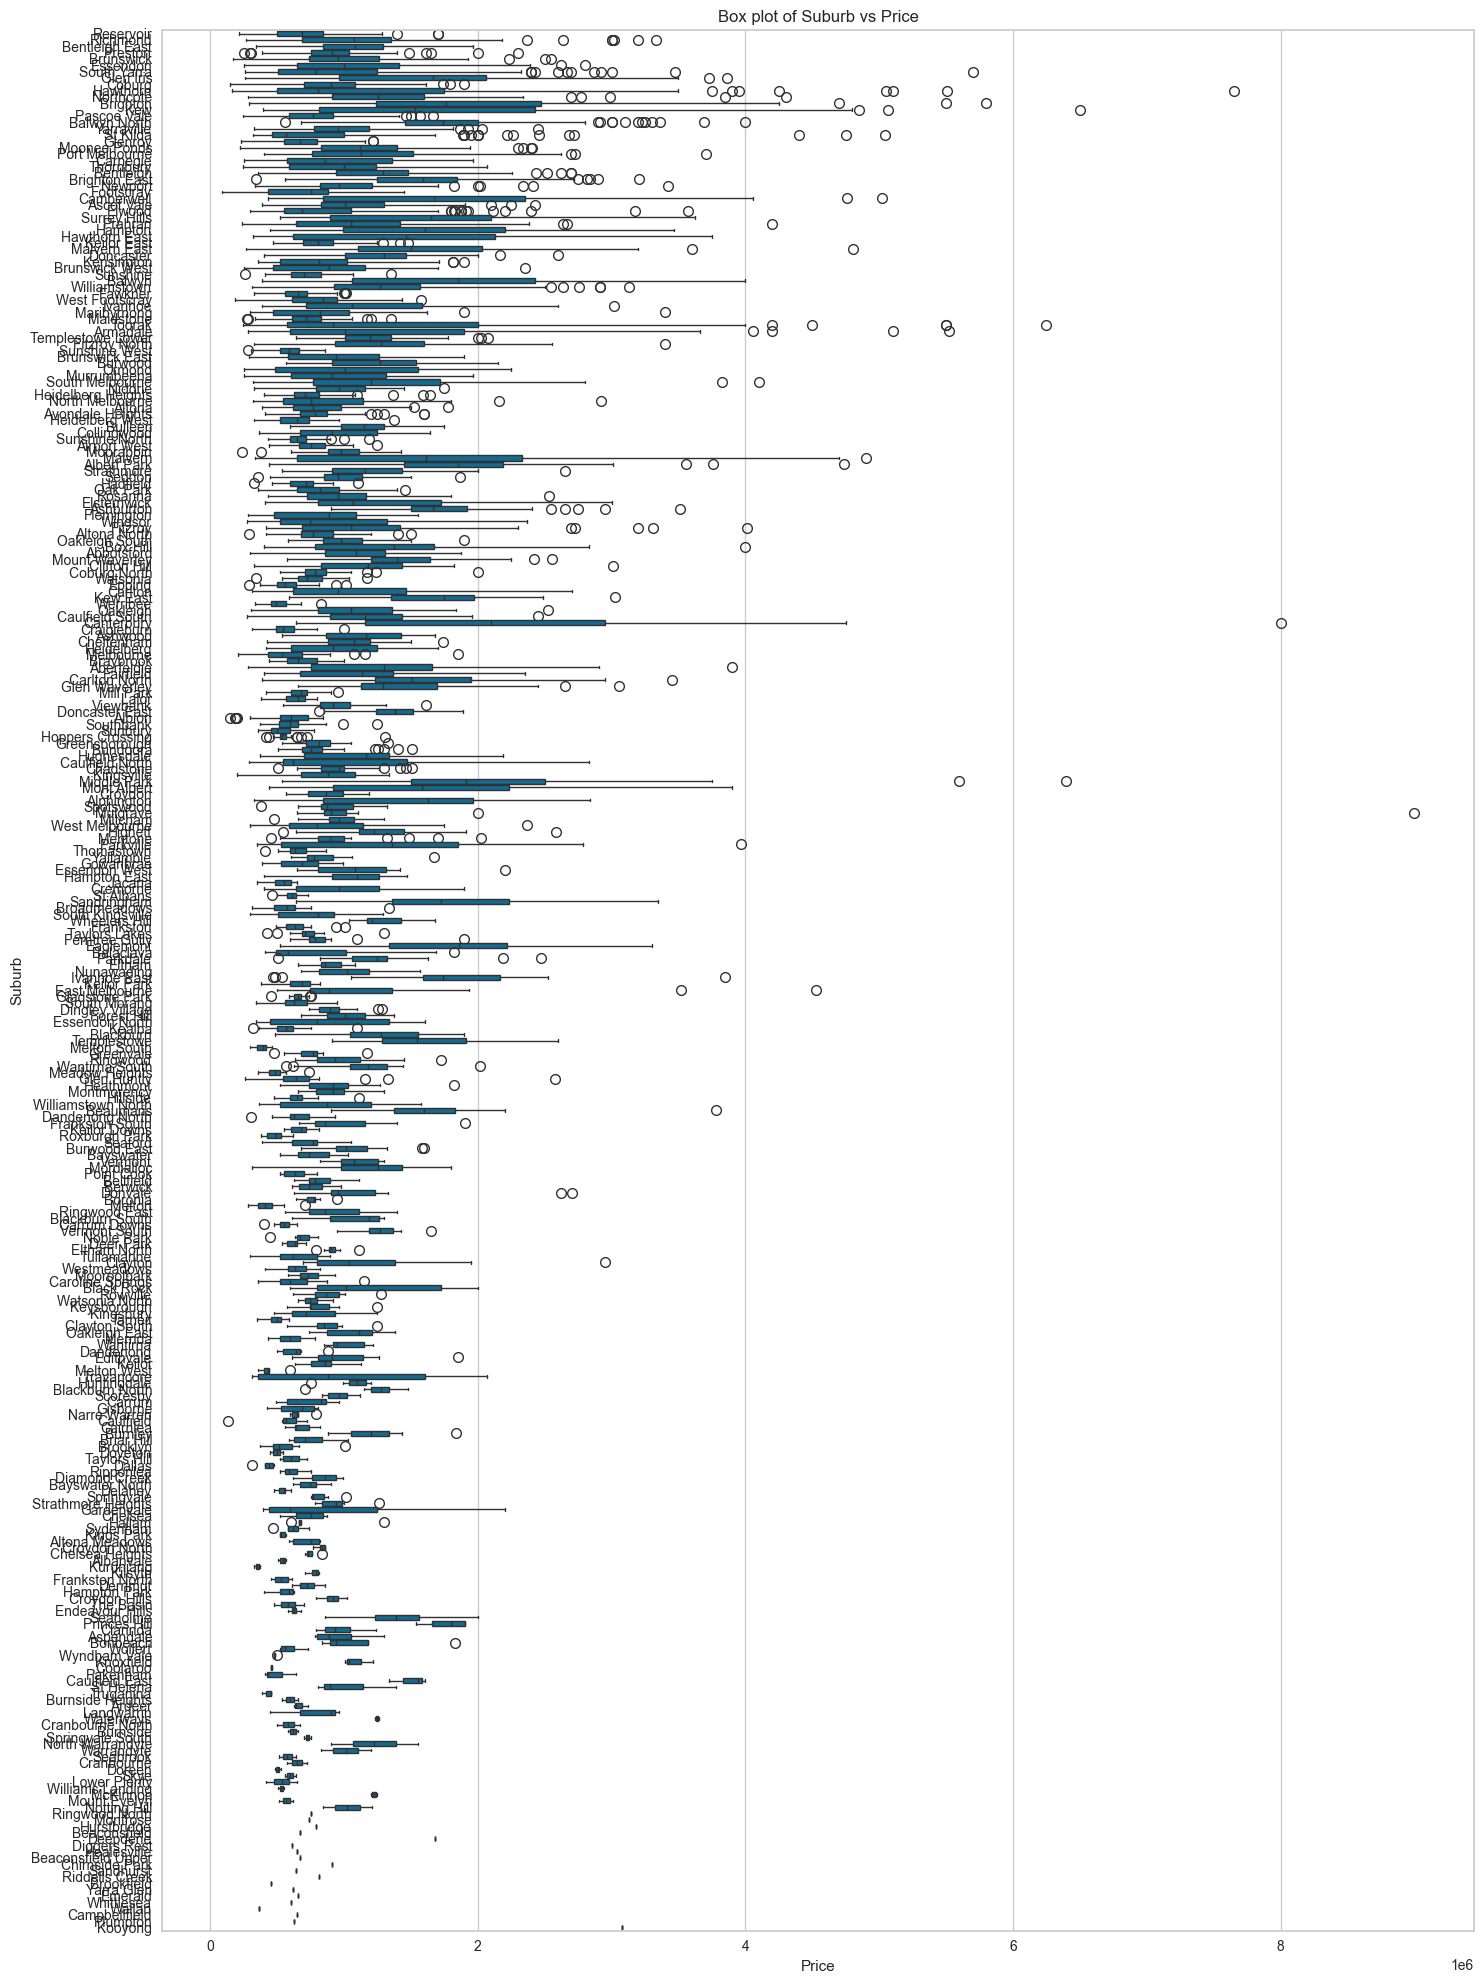

In [31]:
# Count plot for Suburb
plt.figure(figsize=(15, 20))
sb.countplot(data=housingdata, y='Suburb', order=housingdata['Suburb'].value_counts().index)
plt.title('Count plot of Suburb')
plt.xlabel('Count')
plt.ylabel('Suburb')
plt.tight_layout()
plt.show()

# Average price bar plot for Suburb
# We'll compute the average price per suburb and plot it
avg_price = housingdata.groupby('Suburb')['Price'].mean().sort_values(ascending=True)

plt.figure(figsize=(15, 20))
avg_price.plot(kind='barh')
plt.title('Average Price by Suburb')
plt.xlabel('Average Price')
plt.ylabel('Suburb')
plt.tight_layout()
plt.show()

# Box plot of Price distribution by Suburb
plt.figure(figsize=(15, 20))
sb.boxplot(data=housingdata, y='Suburb', x='Price', order=housingdata['Suburb'].value_counts().index)
plt.title('Box plot of Suburb vs Price')
plt.xlabel('Price')
plt.ylabel('Suburb')
plt.tight_layout()
plt.show()

#### Analysis of 'Address' Variable

In [32]:
# # Count plot for Address
# plt.figure(figsize=(15, 20))
# sb.countplot(data=housingdata, y='Address', order=housingdata['Address'].value_counts().index)
# plt.title('Count plot of Address')
# plt.xlabel('Count')
# plt.ylabel('Address')
# plt.tight_layout()
# plt.show()

# # Average price bar plot for Address
# # We'll compute the average price per Address and plot it
# avg_price = housingdata.groupby('Address')['Price'].mean().sort_values(ascending=True)

# plt.figure(figsize=(15, 20))
# avg_price.plot(kind='barh')
# plt.title('Average Price by Address')
# plt.xlabel('Average Price')
# plt.ylabel('Address')
# plt.tight_layout()
# plt.show()

# # Box plot of Price distribution by Address
# plt.figure(figsize=(15, 20))
# sb.boxplot(data=housingdata, y='Address', x='Price', order=housingdata['Address'].value_counts().index)
# plt.title('Box plot of Address vs Price')
# plt.xlabel('Price')
# plt.ylabel('Address')
# plt.tight_layout()
# plt.show()

#### Analysis of 'Type' Variable

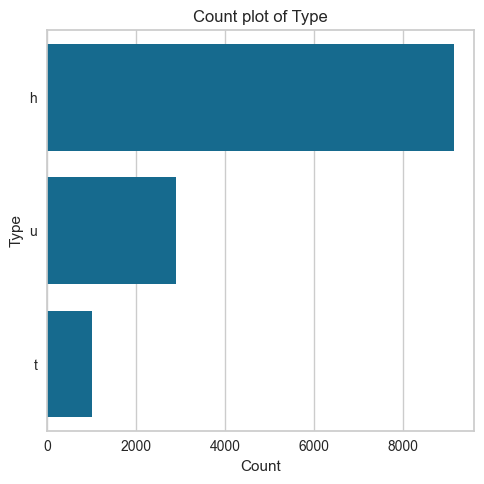

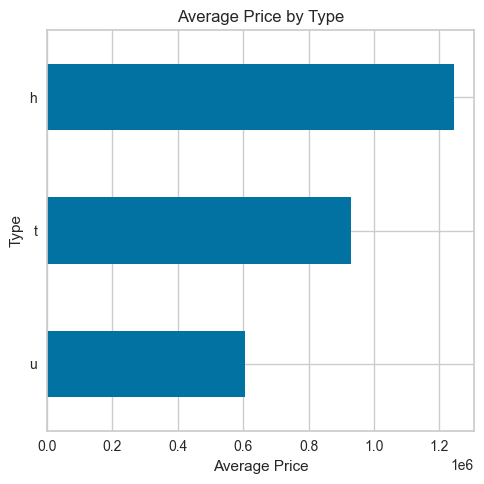

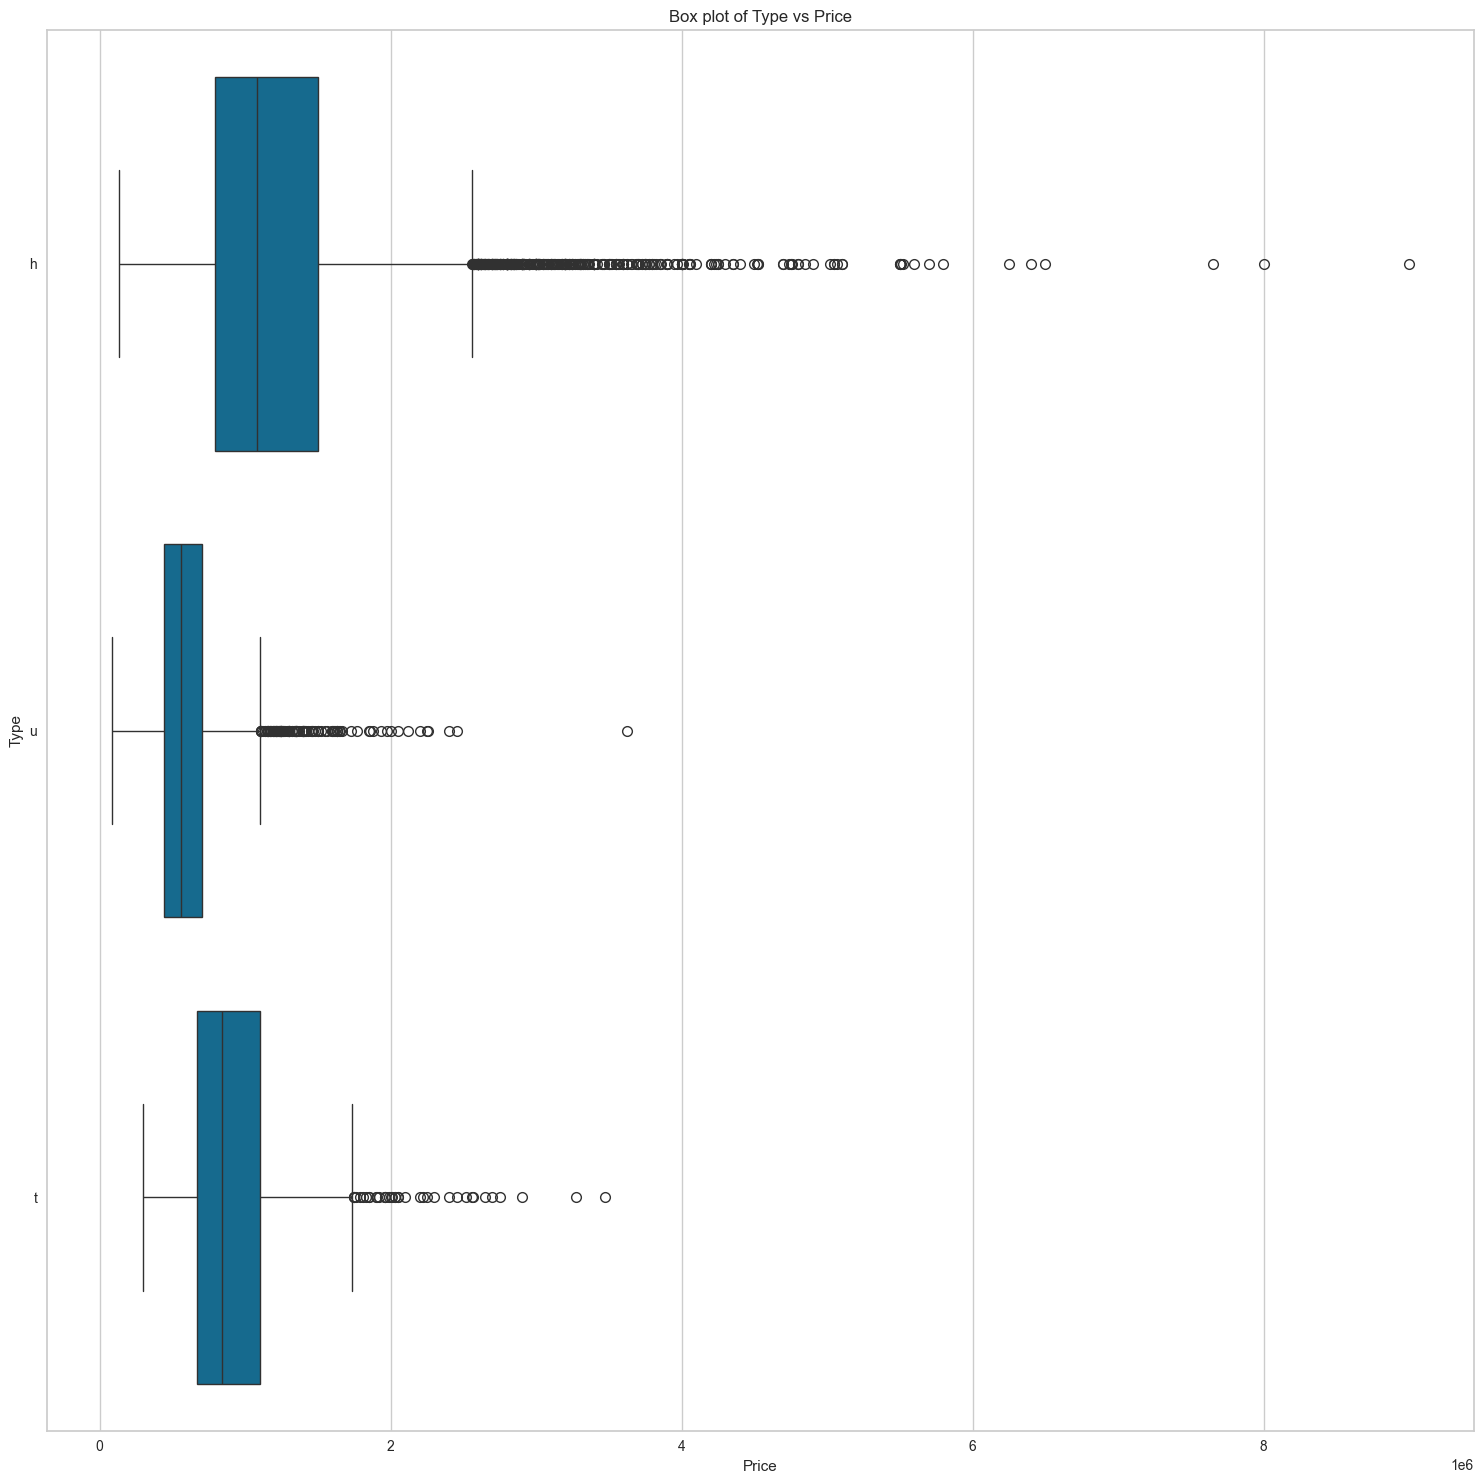

In [33]:
# Count plot for Type
plt.figure(figsize=(5,5))
sb.countplot(data=housingdata, y='Type', order=housingdata['Type'].value_counts().index)
plt.title('Count plot of Type')
plt.xlabel('Count')
plt.ylabel('Type')
plt.tight_layout()
plt.show()

# Average price bar plot for Type
# We'll compute the average price per Type and plot it
avg_price = housingdata.groupby('Type')['Price'].mean().sort_values(ascending=True)

plt.figure(figsize=(5,5))
avg_price.plot(kind='barh')
plt.title('Average Price by Type')
plt.xlabel('Average Price')
plt.ylabel('Type')
plt.tight_layout()
plt.show()

# Box plot of Price distribution by Type
plt.figure(figsize=(15,15))
sb.boxplot(data=housingdata, y='Type', x='Price', order=housingdata['Type'].value_counts().index)
plt.title('Box plot of Type vs Price')
plt.xlabel('Price')
plt.ylabel('Type')
plt.tight_layout()
plt.show()

##### Analysis of 'Method' Variable

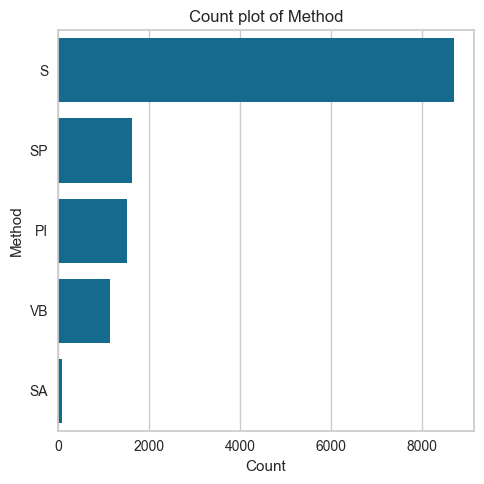

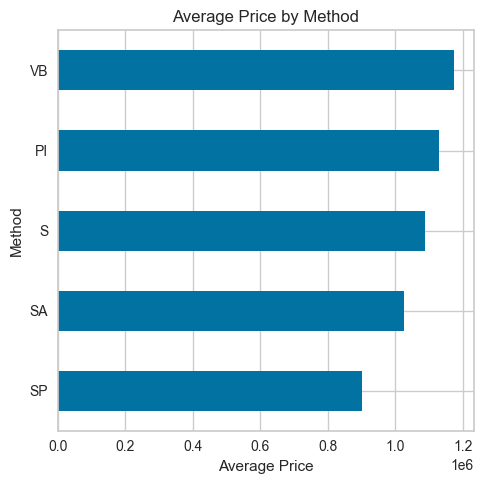

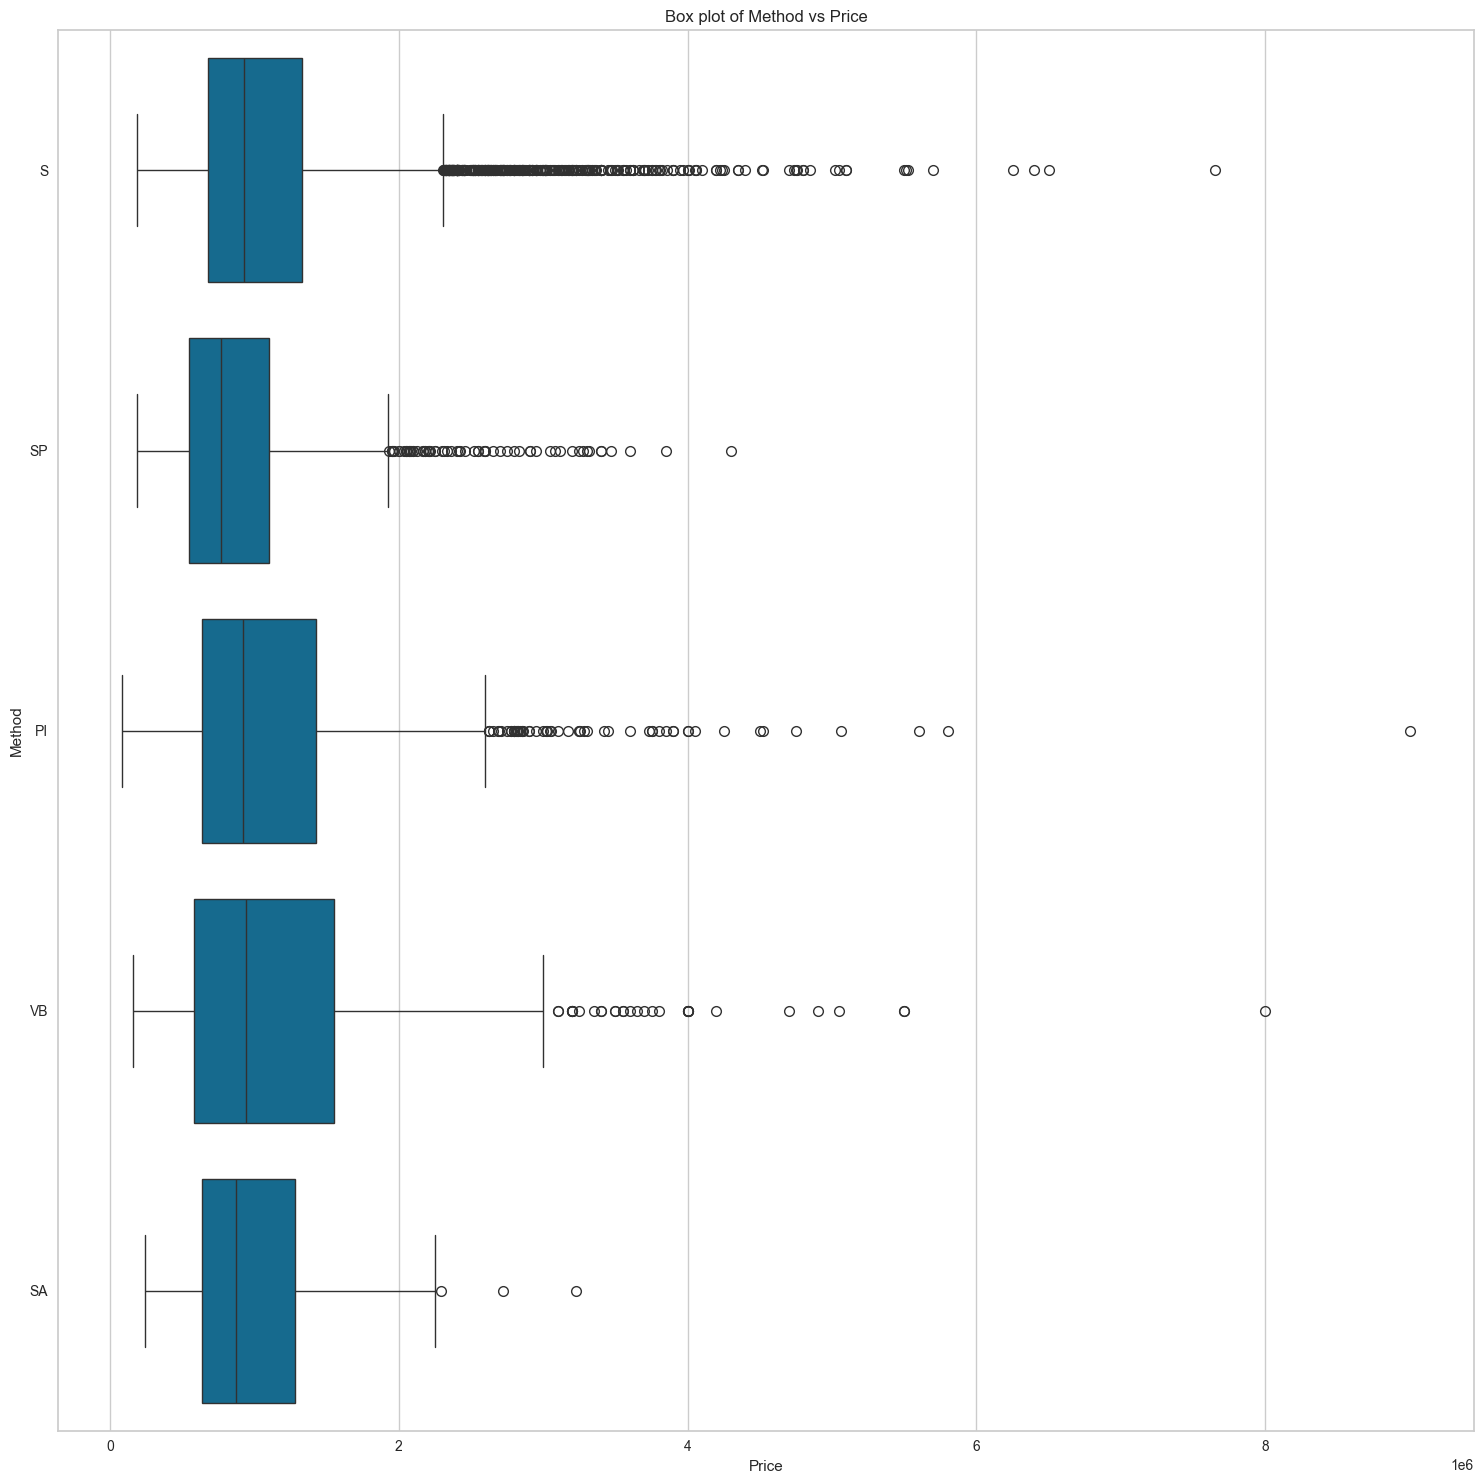

In [34]:
# Count plot for Method
plt.figure(figsize=(5,5))
sb.countplot(data=housingdata, y='Method', order=housingdata['Method'].value_counts().index)
plt.title('Count plot of Method')
plt.xlabel('Count')
plt.ylabel('Method')
plt.tight_layout()
plt.show()

# Average price bar plot for Method
# We'll compute the average price per Method and plot it
avg_price = housingdata.groupby('Method')['Price'].mean().sort_values(ascending=True)

plt.figure(figsize=(5,5))
avg_price.plot(kind='barh')
plt.title('Average Price by Method')
plt.xlabel('Average Price')
plt.ylabel('Method')
plt.tight_layout()
plt.show()

# Box plot of Price distribution by Method
plt.figure(figsize=(15,15))
sb.boxplot(data=housingdata, y='Method', x='Price', order=housingdata['Method'].value_counts().index)
plt.title('Box plot of Method vs Price')
plt.xlabel('Price')
plt.ylabel('Method')
plt.tight_layout()
plt.show()

##### Analysis of 'SellerG' Variable

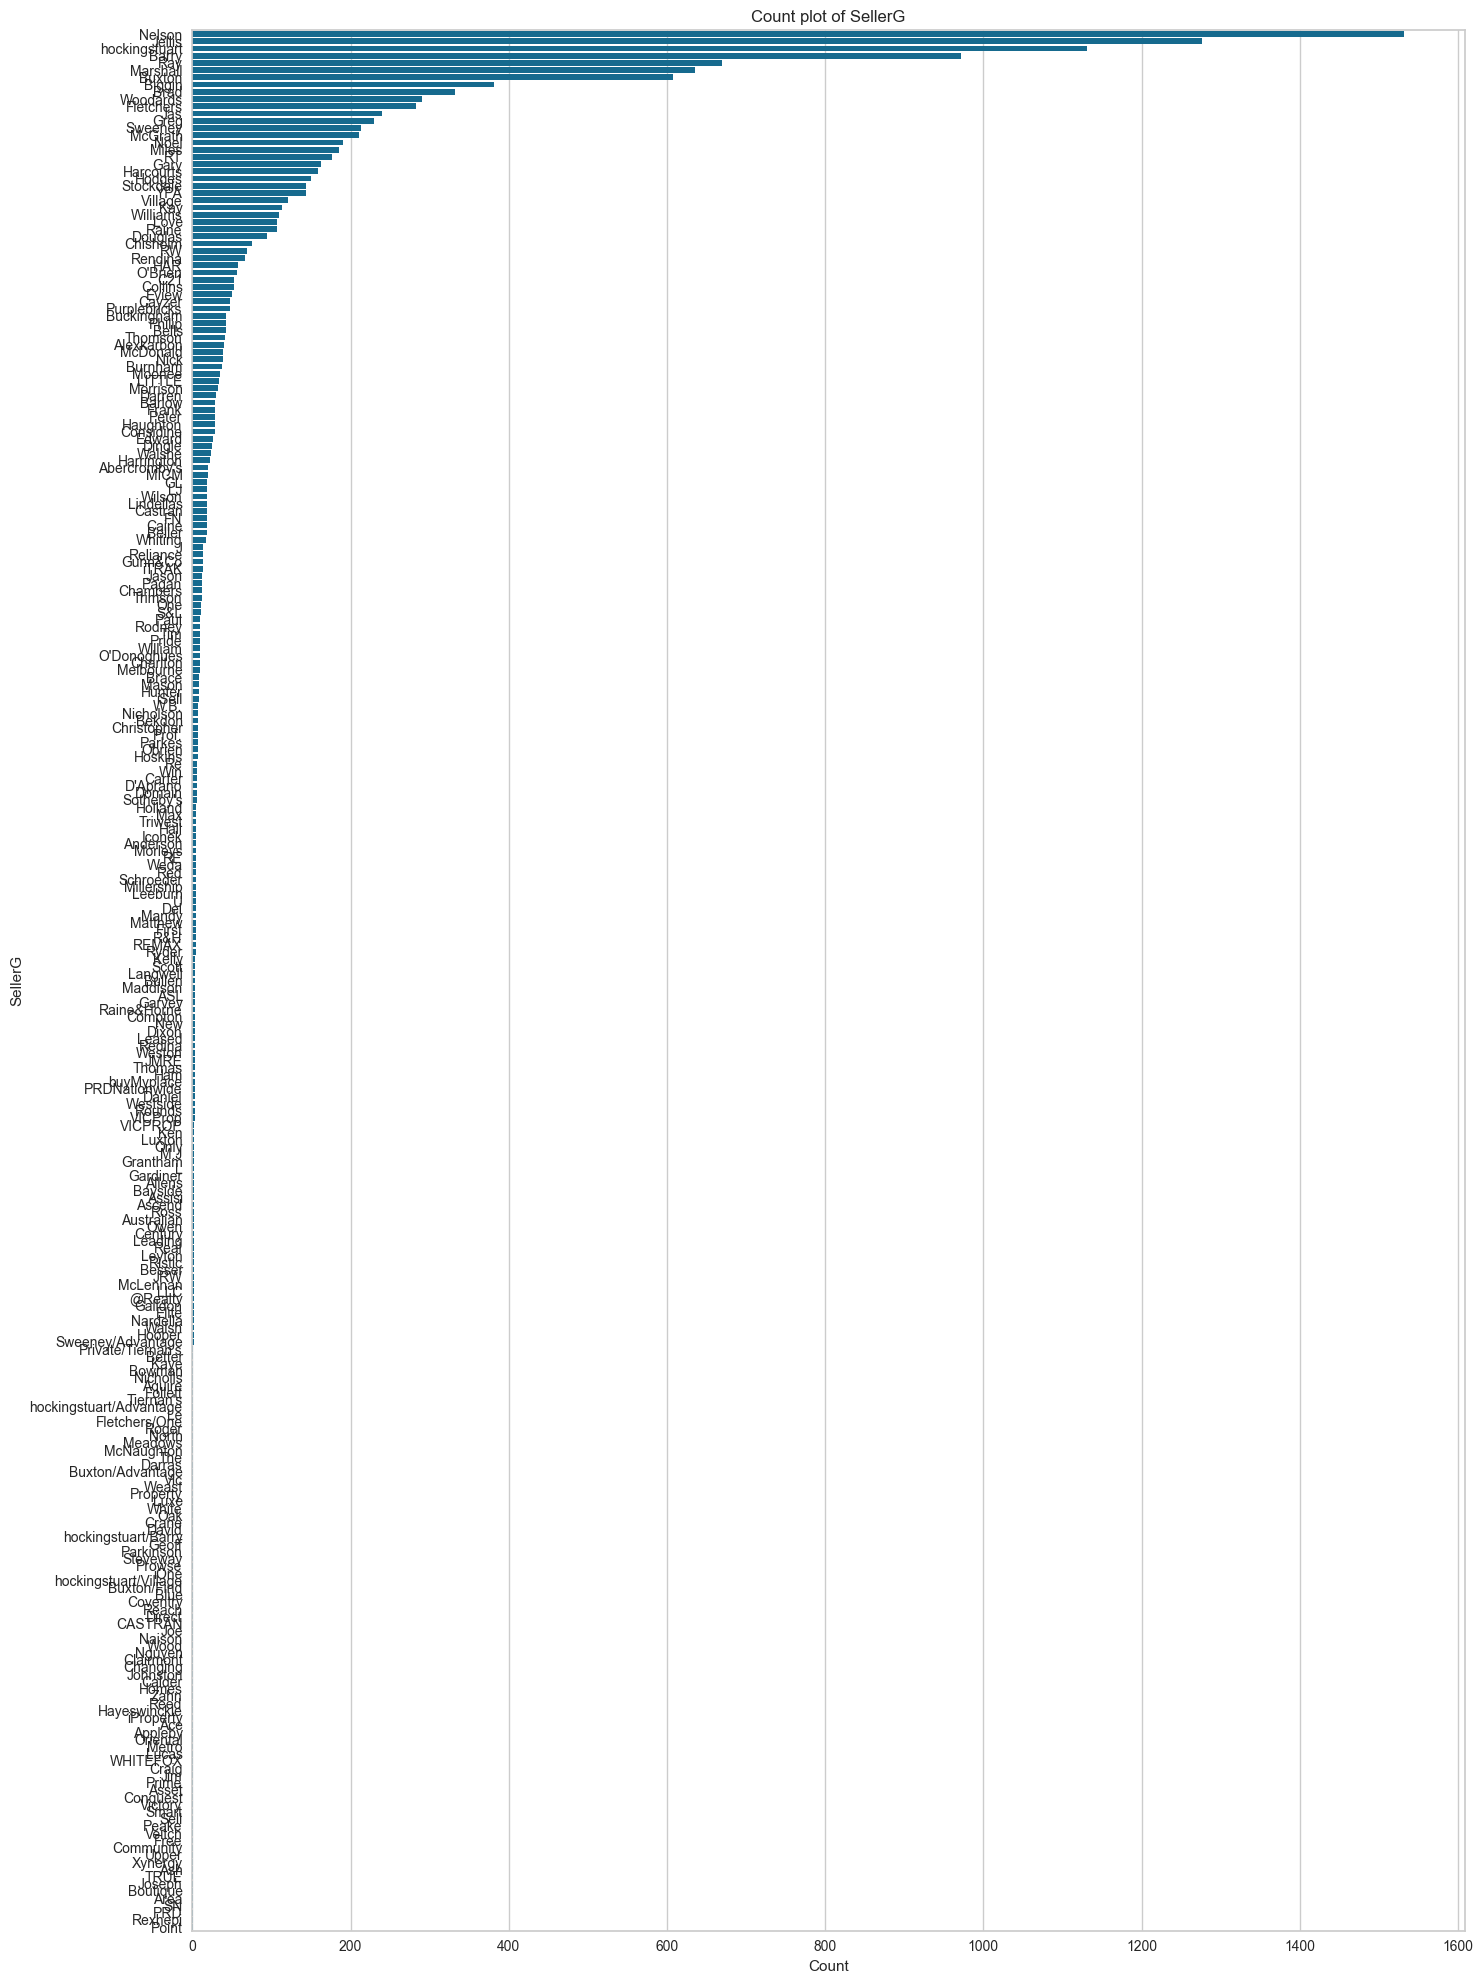

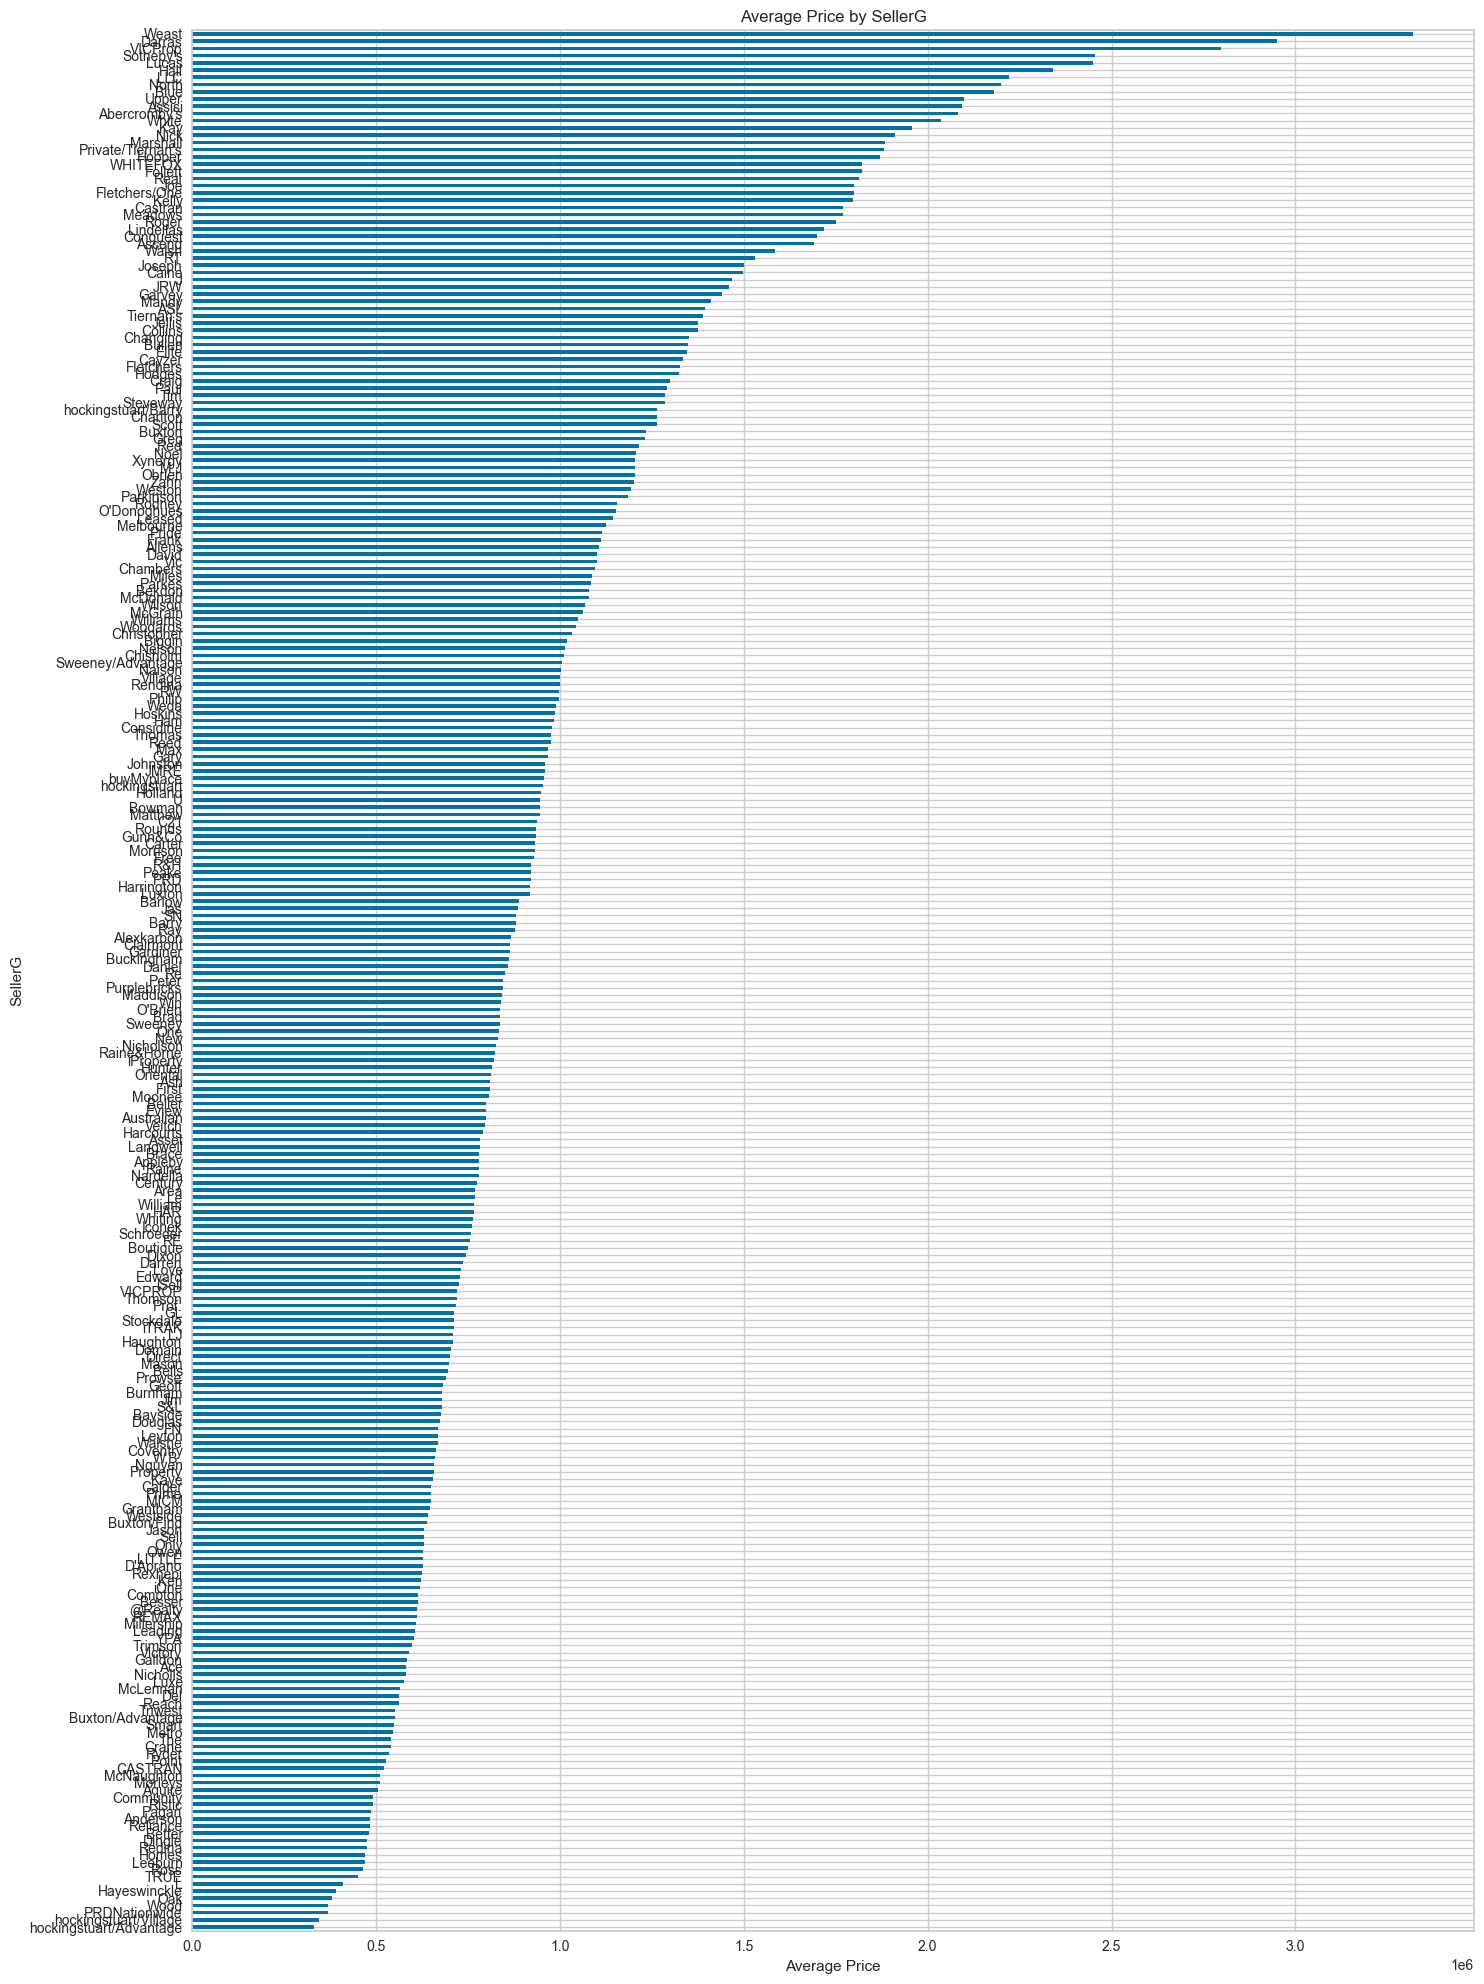

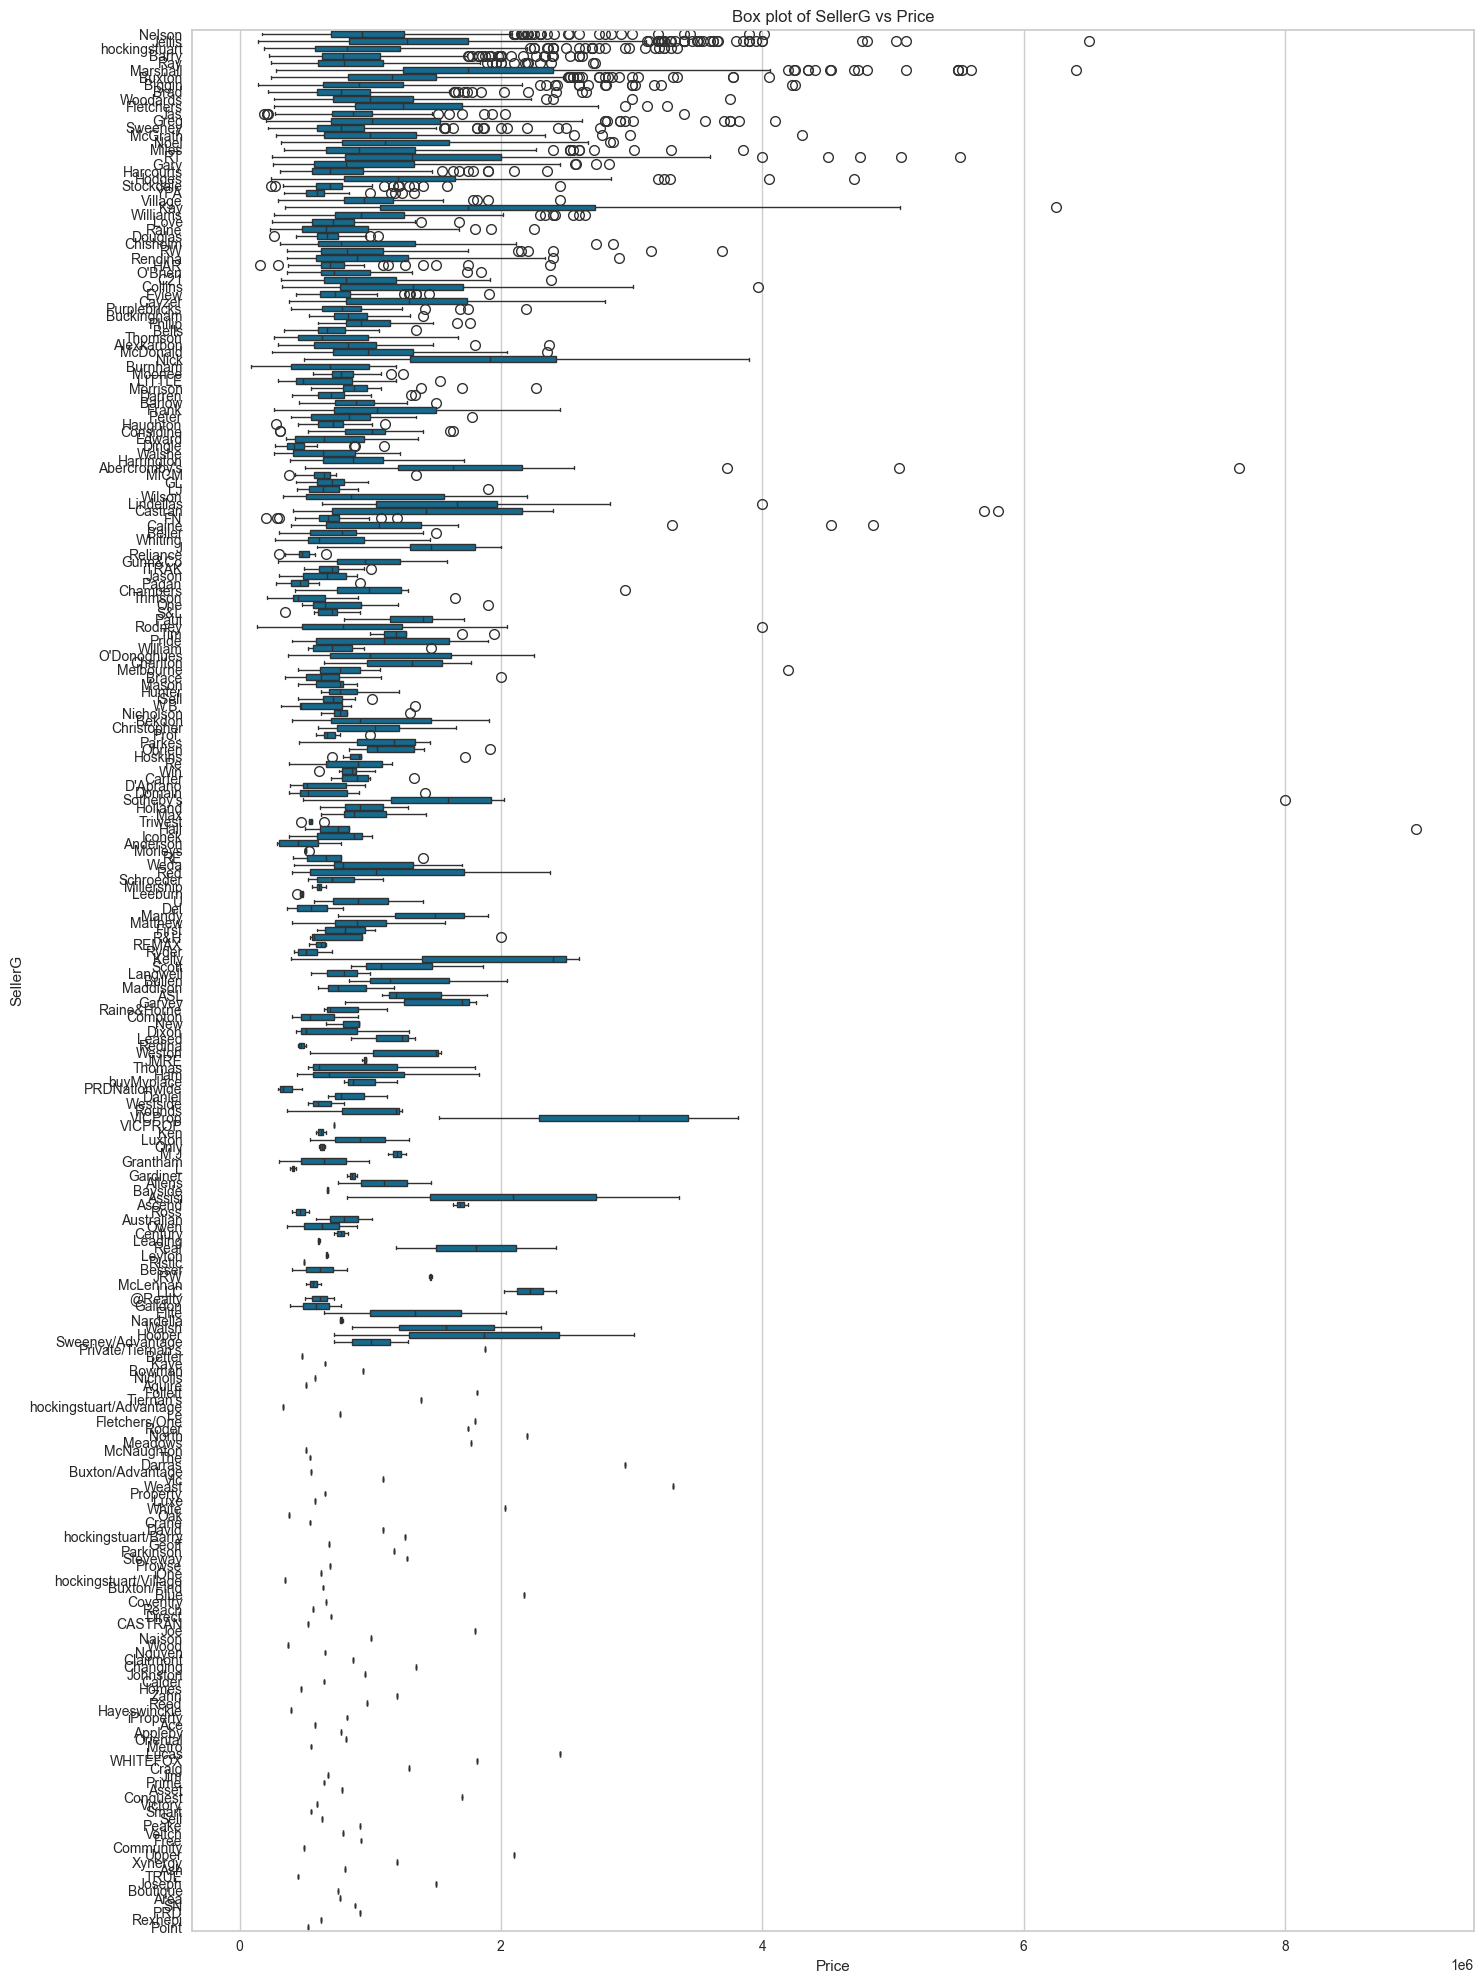

In [35]:
# Count plot for SellerG
plt.figure(figsize=(15,20))
sb.countplot(data=housingdata, y='SellerG', order=housingdata['SellerG'].value_counts().index)
plt.title('Count plot of SellerG')
plt.xlabel('Count')
plt.ylabel('SellerG')
plt.tight_layout()
plt.show()

# Average price bar plot for SellerG
# We'll compute the average price per SellerG and plot it
avg_price = housingdata.groupby('SellerG')['Price'].mean().sort_values(ascending=True)

plt.figure(figsize=(15,20))
avg_price.plot(kind='barh')
plt.title('Average Price by SellerG')
plt.xlabel('Average Price')
plt.ylabel('SellerG')
plt.tight_layout()
plt.show()

# Box plot of Price distribution by SellerG
plt.figure(figsize=(15,20))
sb.boxplot(data=housingdata, y='SellerG', x='Price', order=housingdata['SellerG'].value_counts().index)
plt.title('Box plot of SellerG vs Price')
plt.xlabel('Price')
plt.ylabel('SellerG')
plt.tight_layout()
plt.show()

##### Analysis of 'Date' Variable

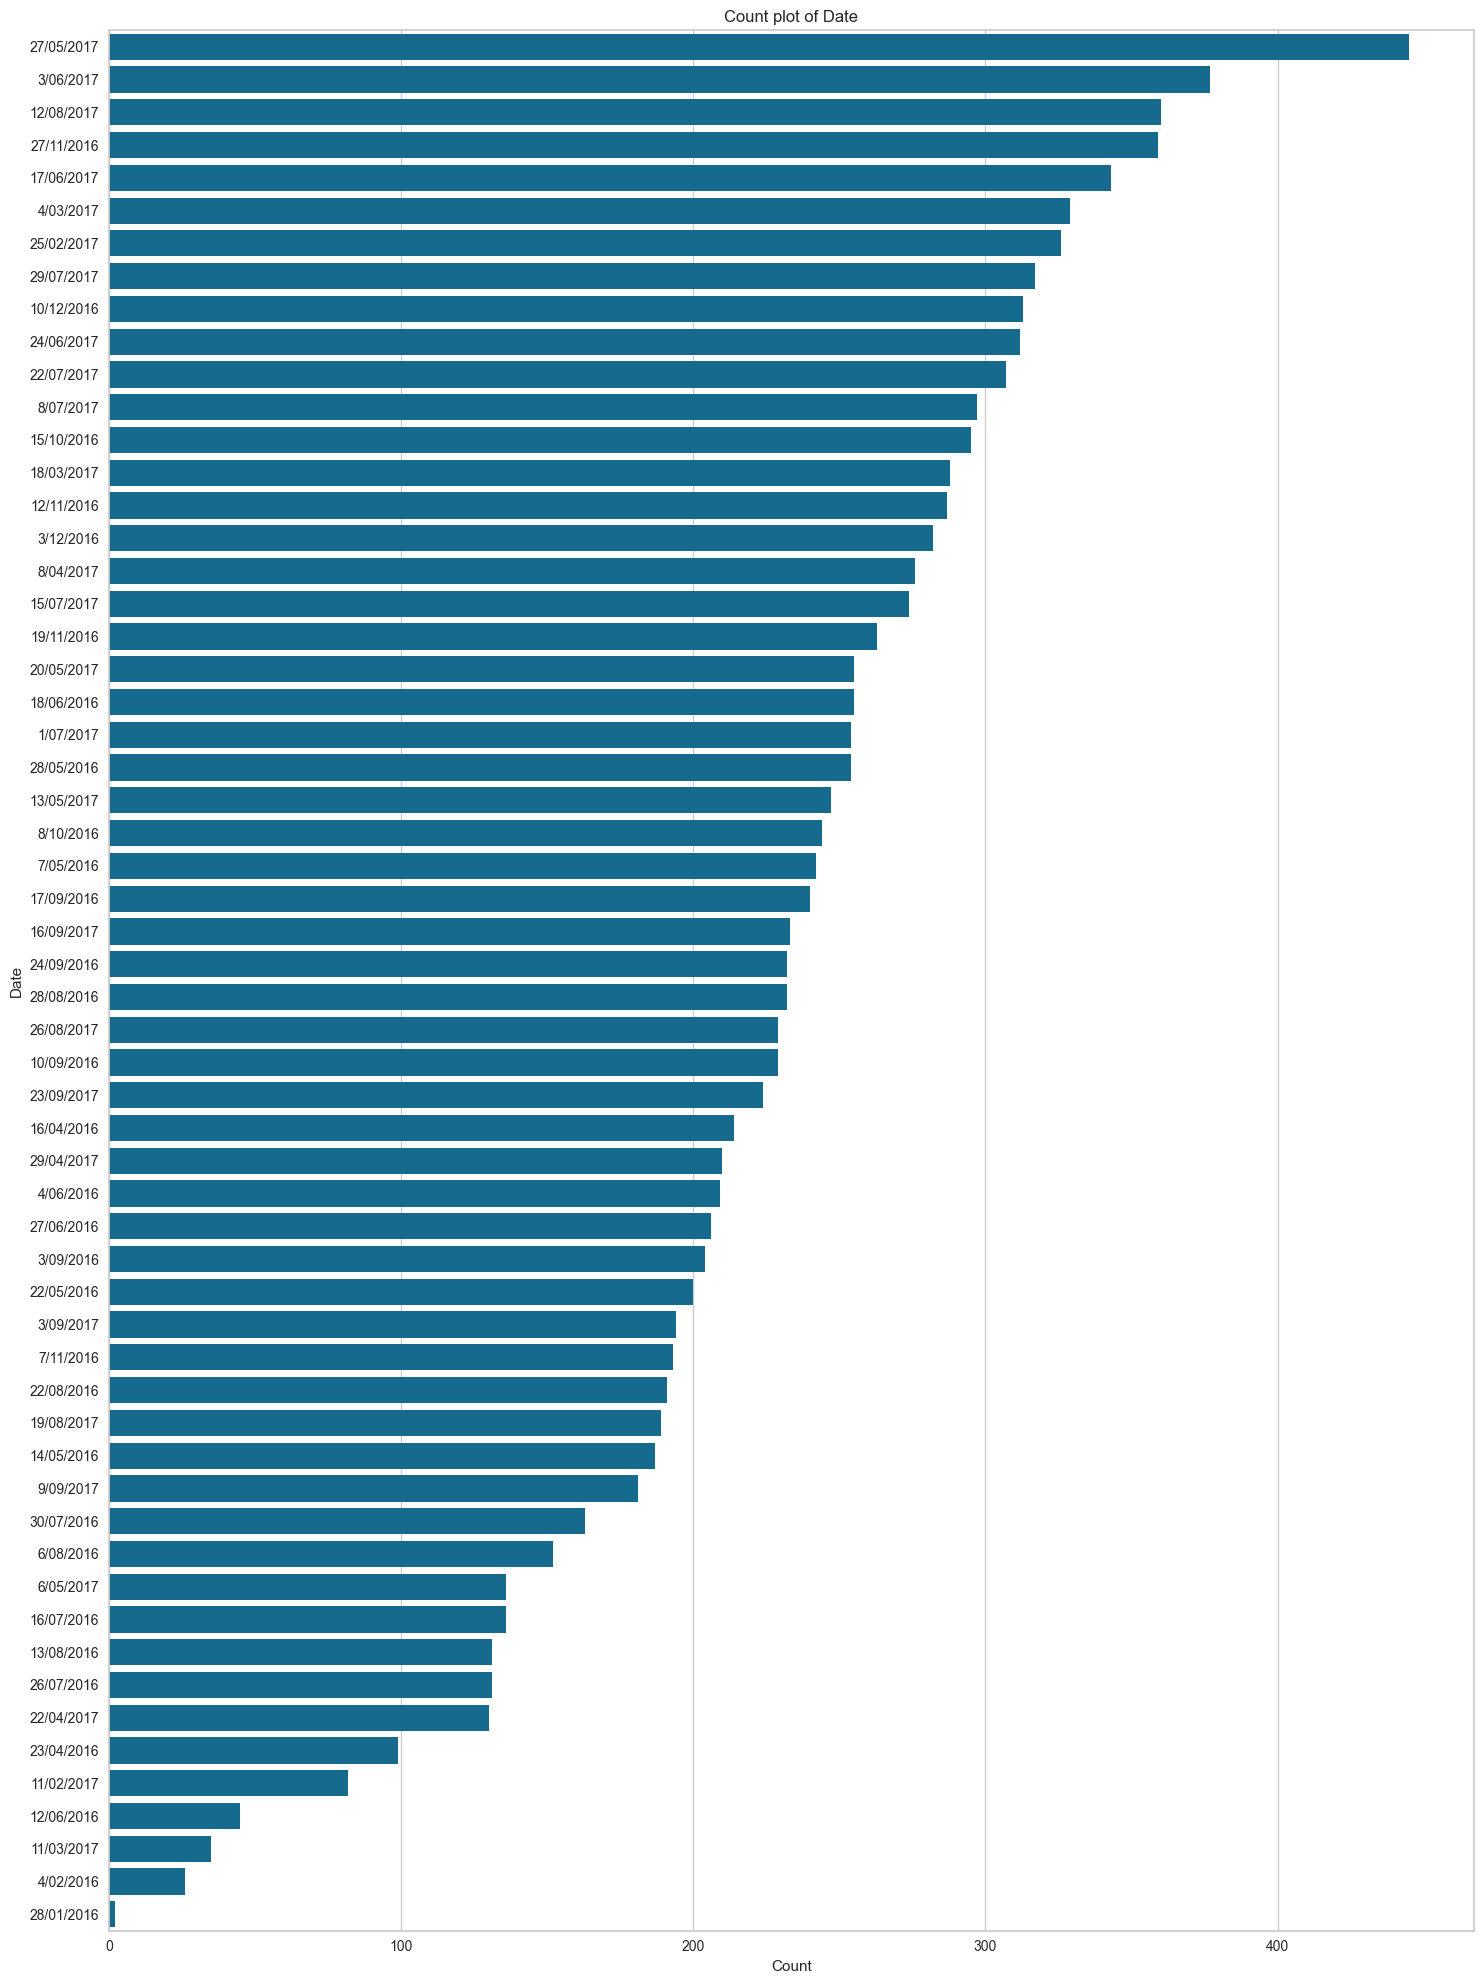

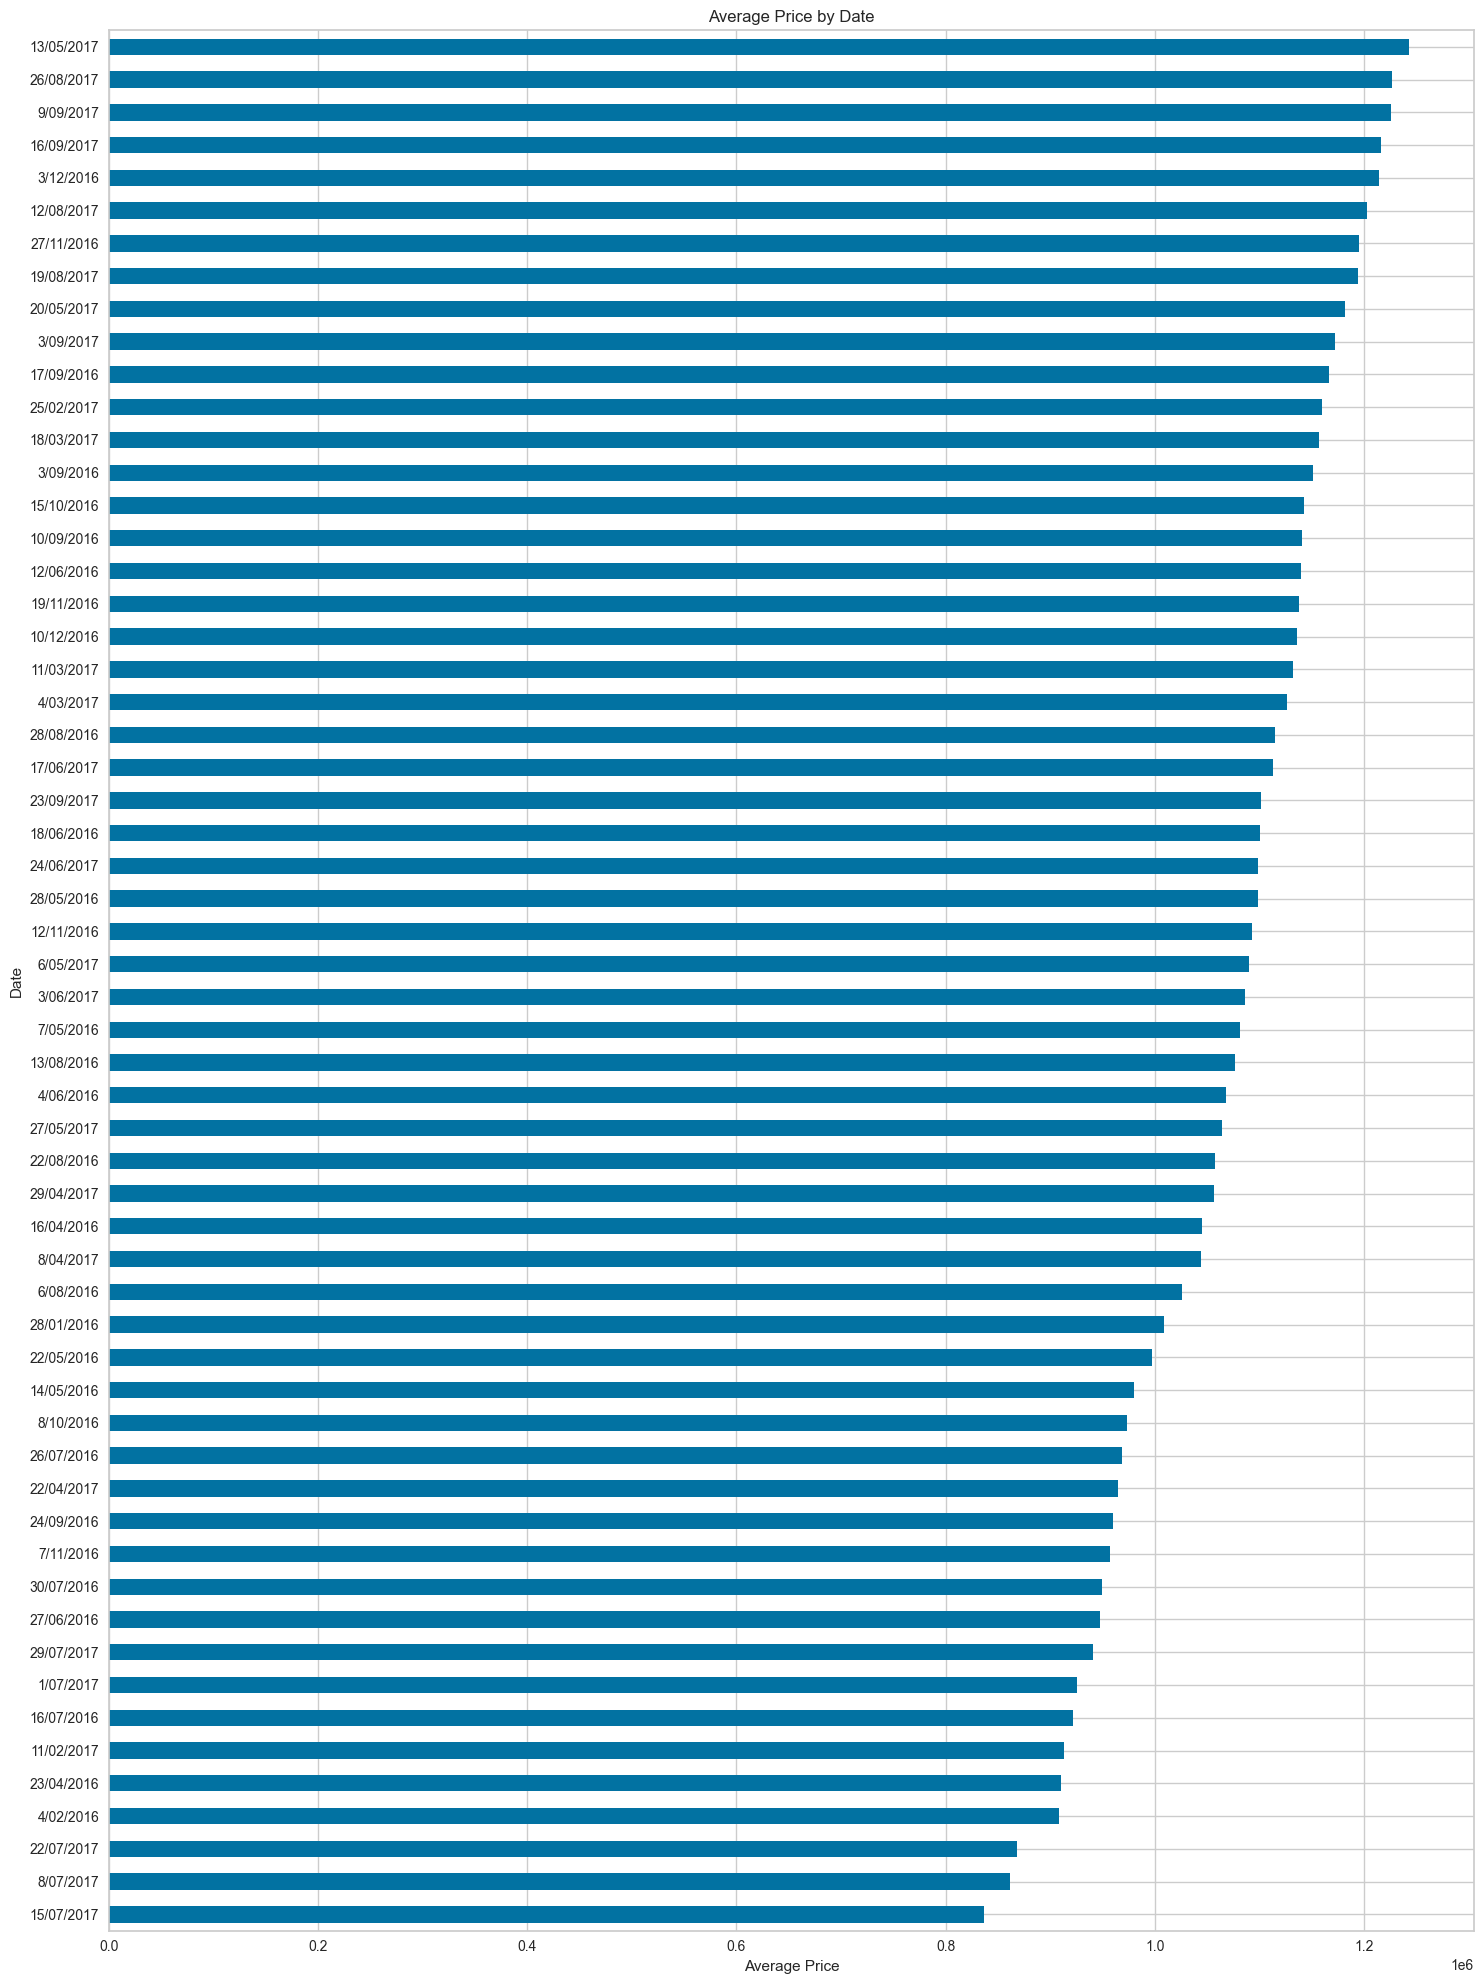

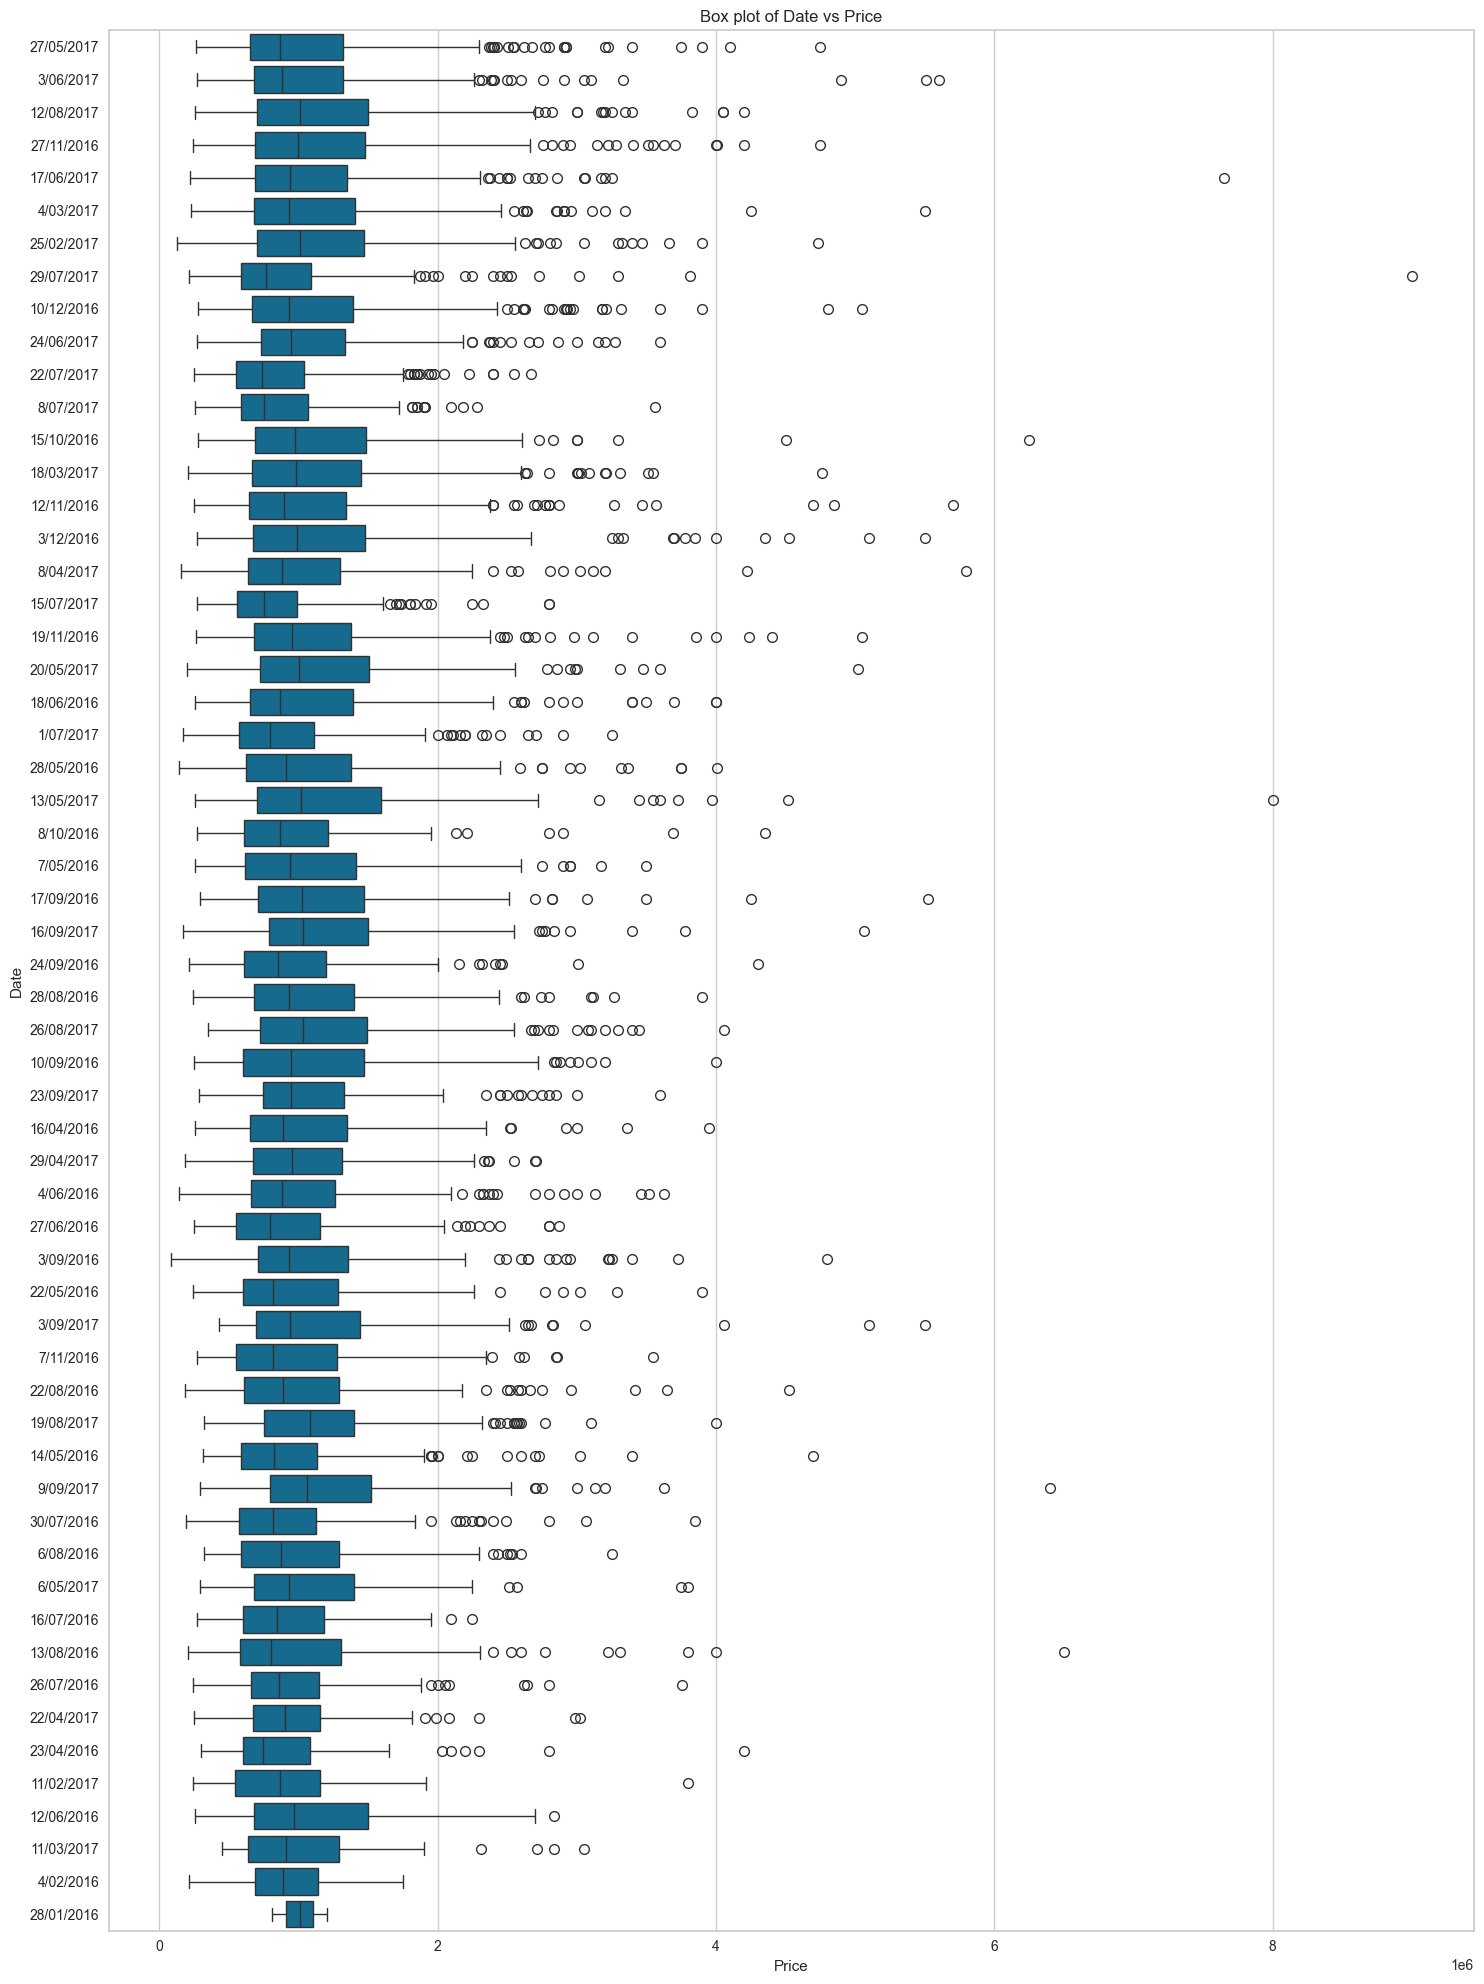

In [36]:
# Count plot for Date
plt.figure(figsize=(15, 20))
sb.countplot(data=housingdata, y='Date', order=housingdata['Date'].value_counts().index)
plt.title('Count plot of Date')
plt.xlabel('Count')
plt.ylabel('Date')
plt.tight_layout()
plt.show()

# Average price bar plot for Date
# We'll compute the average price per Date and plot it
avg_price = housingdata.groupby('Date')['Price'].mean().sort_values(ascending=True)

plt.figure(figsize=(15, 20))
avg_price.plot(kind='barh')
plt.title('Average Price by Date')
plt.xlabel('Average Price')
plt.ylabel('Date')
plt.tight_layout()
plt.show()

# Box plot of Price distribution by Date
plt.figure(figsize=(15,20))
sb.boxplot(data=housingdata, y='Date', x='Price', order=housingdata['Date'].value_counts().index)
plt.title('Box plot of Date vs Price')
plt.xlabel('Price')
plt.ylabel('Date')
plt.tight_layout()
plt.show()

##### Analysis of 'CouncilArea' Variable

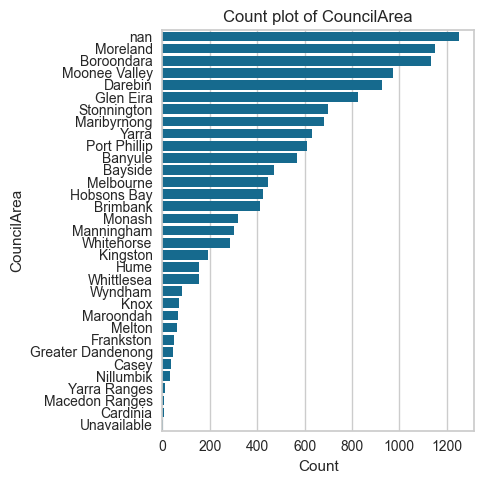

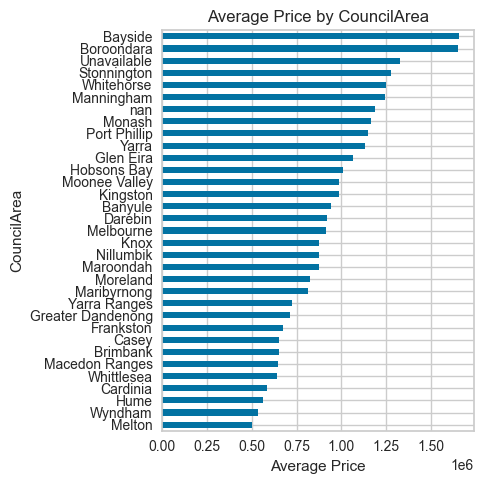

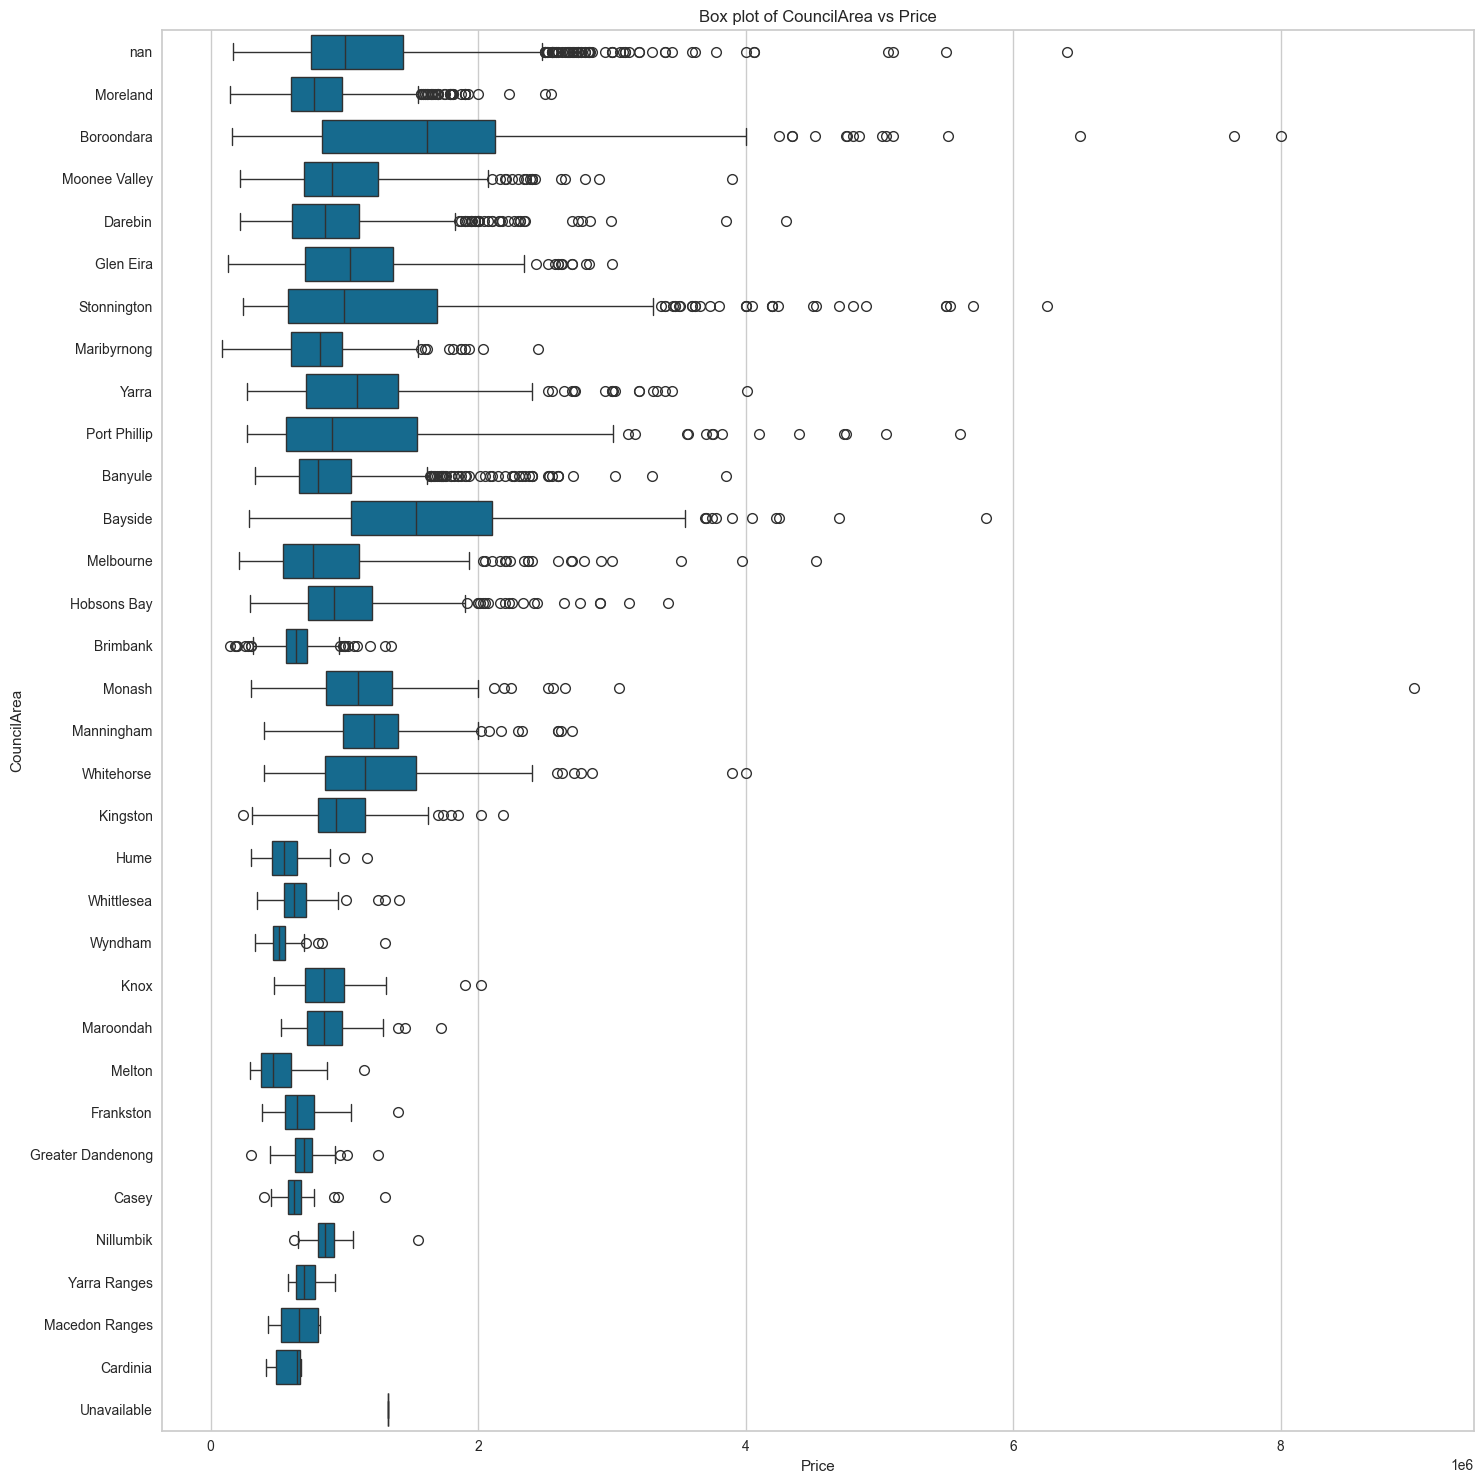

In [37]:
# Count plot for CouncilArea
plt.figure(figsize=(5,5))
sb.countplot(data=housingdata, y='CouncilArea', order=housingdata['CouncilArea'].value_counts().index)
plt.title('Count plot of CouncilArea')
plt.xlabel('Count')
plt.ylabel('CouncilArea')
plt.tight_layout()
plt.show()

# Average price bar plot for CouncilArea
# We'll compute the average price per CouncilArea and plot it
avg_price = housingdata.groupby('CouncilArea')['Price'].mean().sort_values(ascending=True)

plt.figure(figsize=(5,5))
avg_price.plot(kind='barh')
plt.title('Average Price by CouncilArea')
plt.xlabel('Average Price')
plt.ylabel('CouncilArea')
plt.tight_layout()
plt.show()

# Box plot of Price distribution by CouncilArea
plt.figure(figsize=(15,15))
sb.boxplot(data=housingdata, y='CouncilArea', x='Price', order=housingdata['CouncilArea'].value_counts().index)
plt.title('Box plot of CouncilArea vs Price')
plt.xlabel('Price')
plt.ylabel('CouncilArea')
plt.tight_layout()
plt.show()

##### Analysis of 'Regionname' Variable

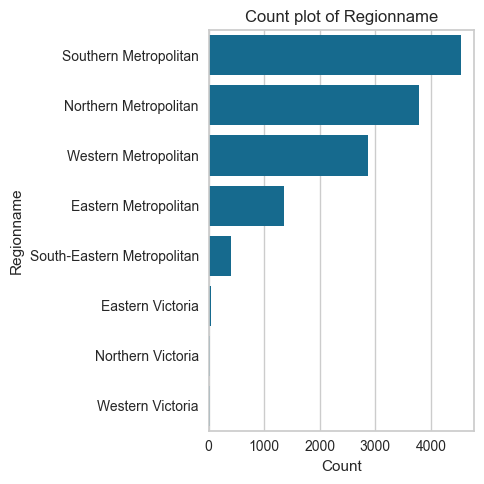

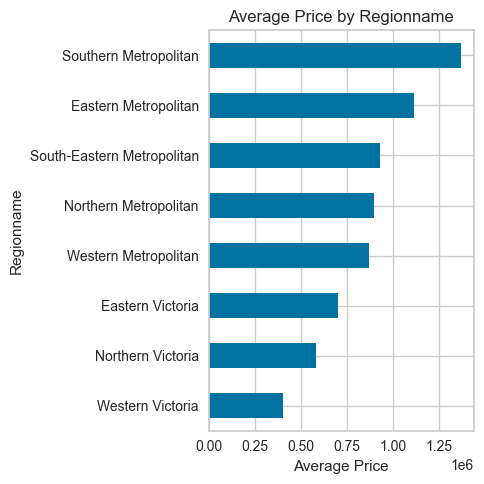

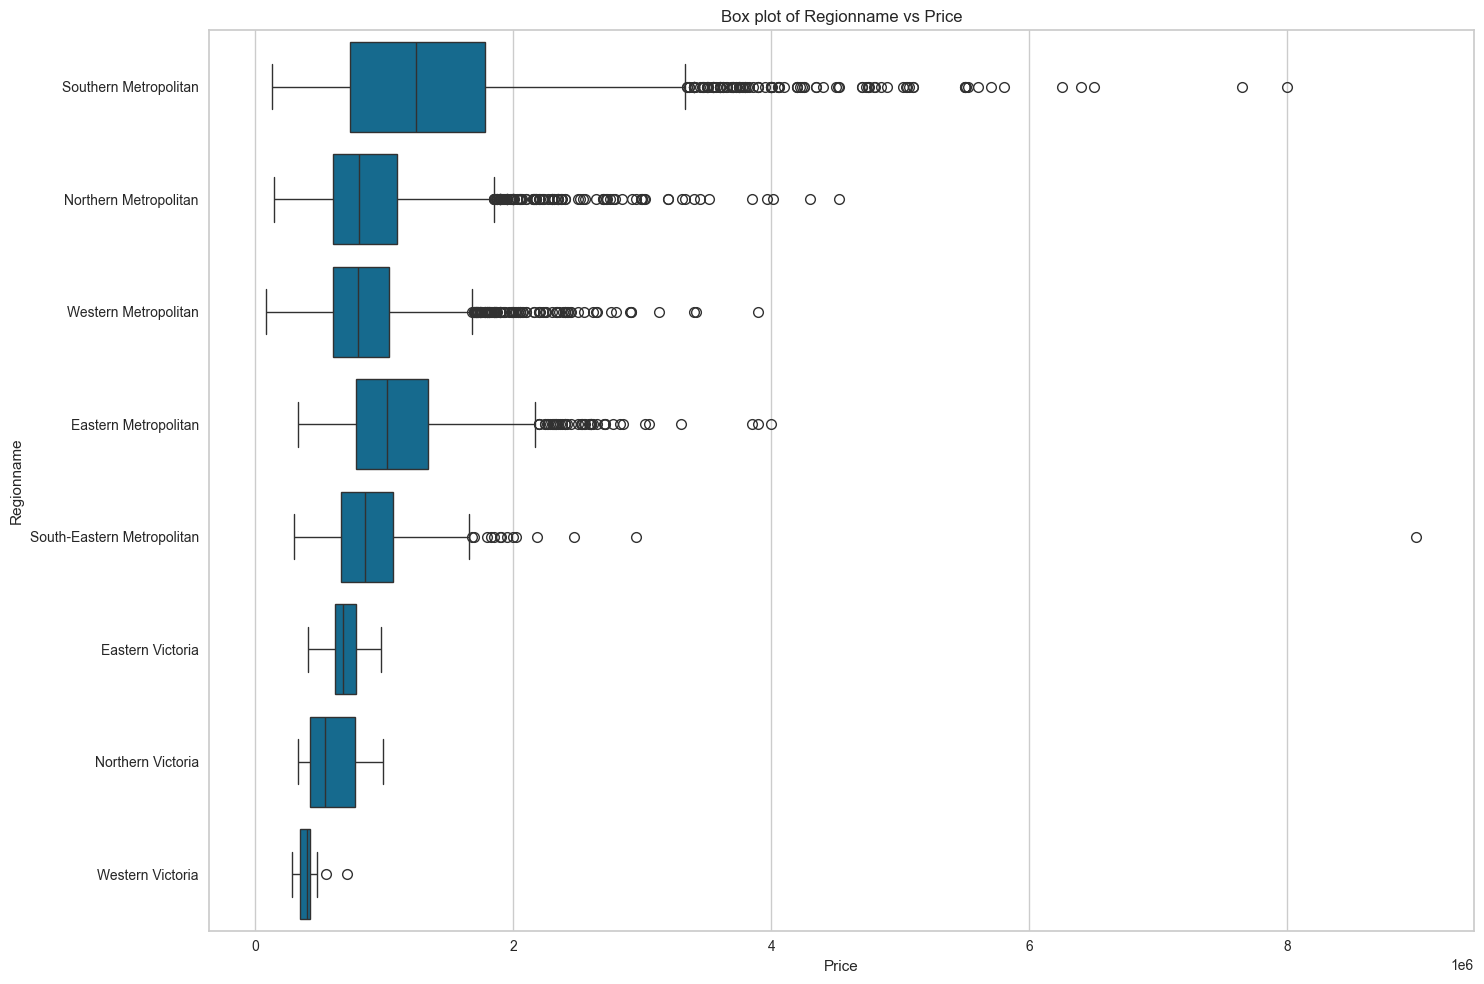

In [38]:
# Count plot for Regionname
plt.figure(figsize=(5,5))
sb.countplot(data=housingdata, y='Regionname', order=housingdata['Regionname'].value_counts().index)
plt.title('Count plot of Regionname')
plt.xlabel('Count')
plt.ylabel('Regionname')
plt.tight_layout()
plt.show()

# Average price bar plot for Regionname
# We'll compute the average price per Regionname and plot it
avg_price = housingdata.groupby('Regionname')['Price'].mean().sort_values(ascending=True)

plt.figure(figsize=(5,5))
avg_price.plot(kind='barh')
plt.title('Average Price by Regionname')
plt.xlabel('Average Price')
plt.ylabel('Regionname')
plt.tight_layout()
plt.show()

# Box plot of Price distribution by Regionname
plt.figure(figsize=(15,10))
sb.boxplot(data=housingdata, y='Regionname', x='Price', order=housingdata['Regionname'].value_counts().index)
plt.title('Box plot of Regionname vs Price')
plt.xlabel('Price')
plt.ylabel('Regionname')
plt.tight_layout()
plt.show()

## Preparation of Response & Predictor Variables
1. Dimensionality/Cardinality Reduction for Categorical Variables
2. Feature Engineering

### 1. Dimensionality/Cardinality Reduction for Categorical Variables
Some of the categorical variables in this dataset contain a large number of unique categories (high cardinality), contributing to a lot of unnecessary noise in our analysis and reduced interpretability. 

Hence we will perform dimensionality (cardinality) reduction on selected categorical features (Suburb, SellerG, and Address) by grouping less common categories into an 'Other' category. The threshold we will choose for this is a 1% (Will probs change) proportion; categories within a variable that make up less than 1% of the number of rows in the dataset will be all classified into an 'Other' category.

Define a function for grouping the less common categories:

In [39]:
def group_rare_categories(df, column, threshold=0.01):
    category_counts = df[column].value_counts(normalize=True)
    
    # Identify categories with frequency less than the threshold
    rare_categories = category_counts[category_counts < threshold].index
    
    # Replace rare categories with "Other"
    df[column] = df[column].apply(lambda x: 'Other' if x in rare_categories else x)
    
    return df

#### Dimensionality Reduction of Suburb

In [40]:
housingdata = group_rare_categories(housingdata, 'Suburb', threshold=0.01)

Let's check what Suburb looks like after dimensionality reduction.

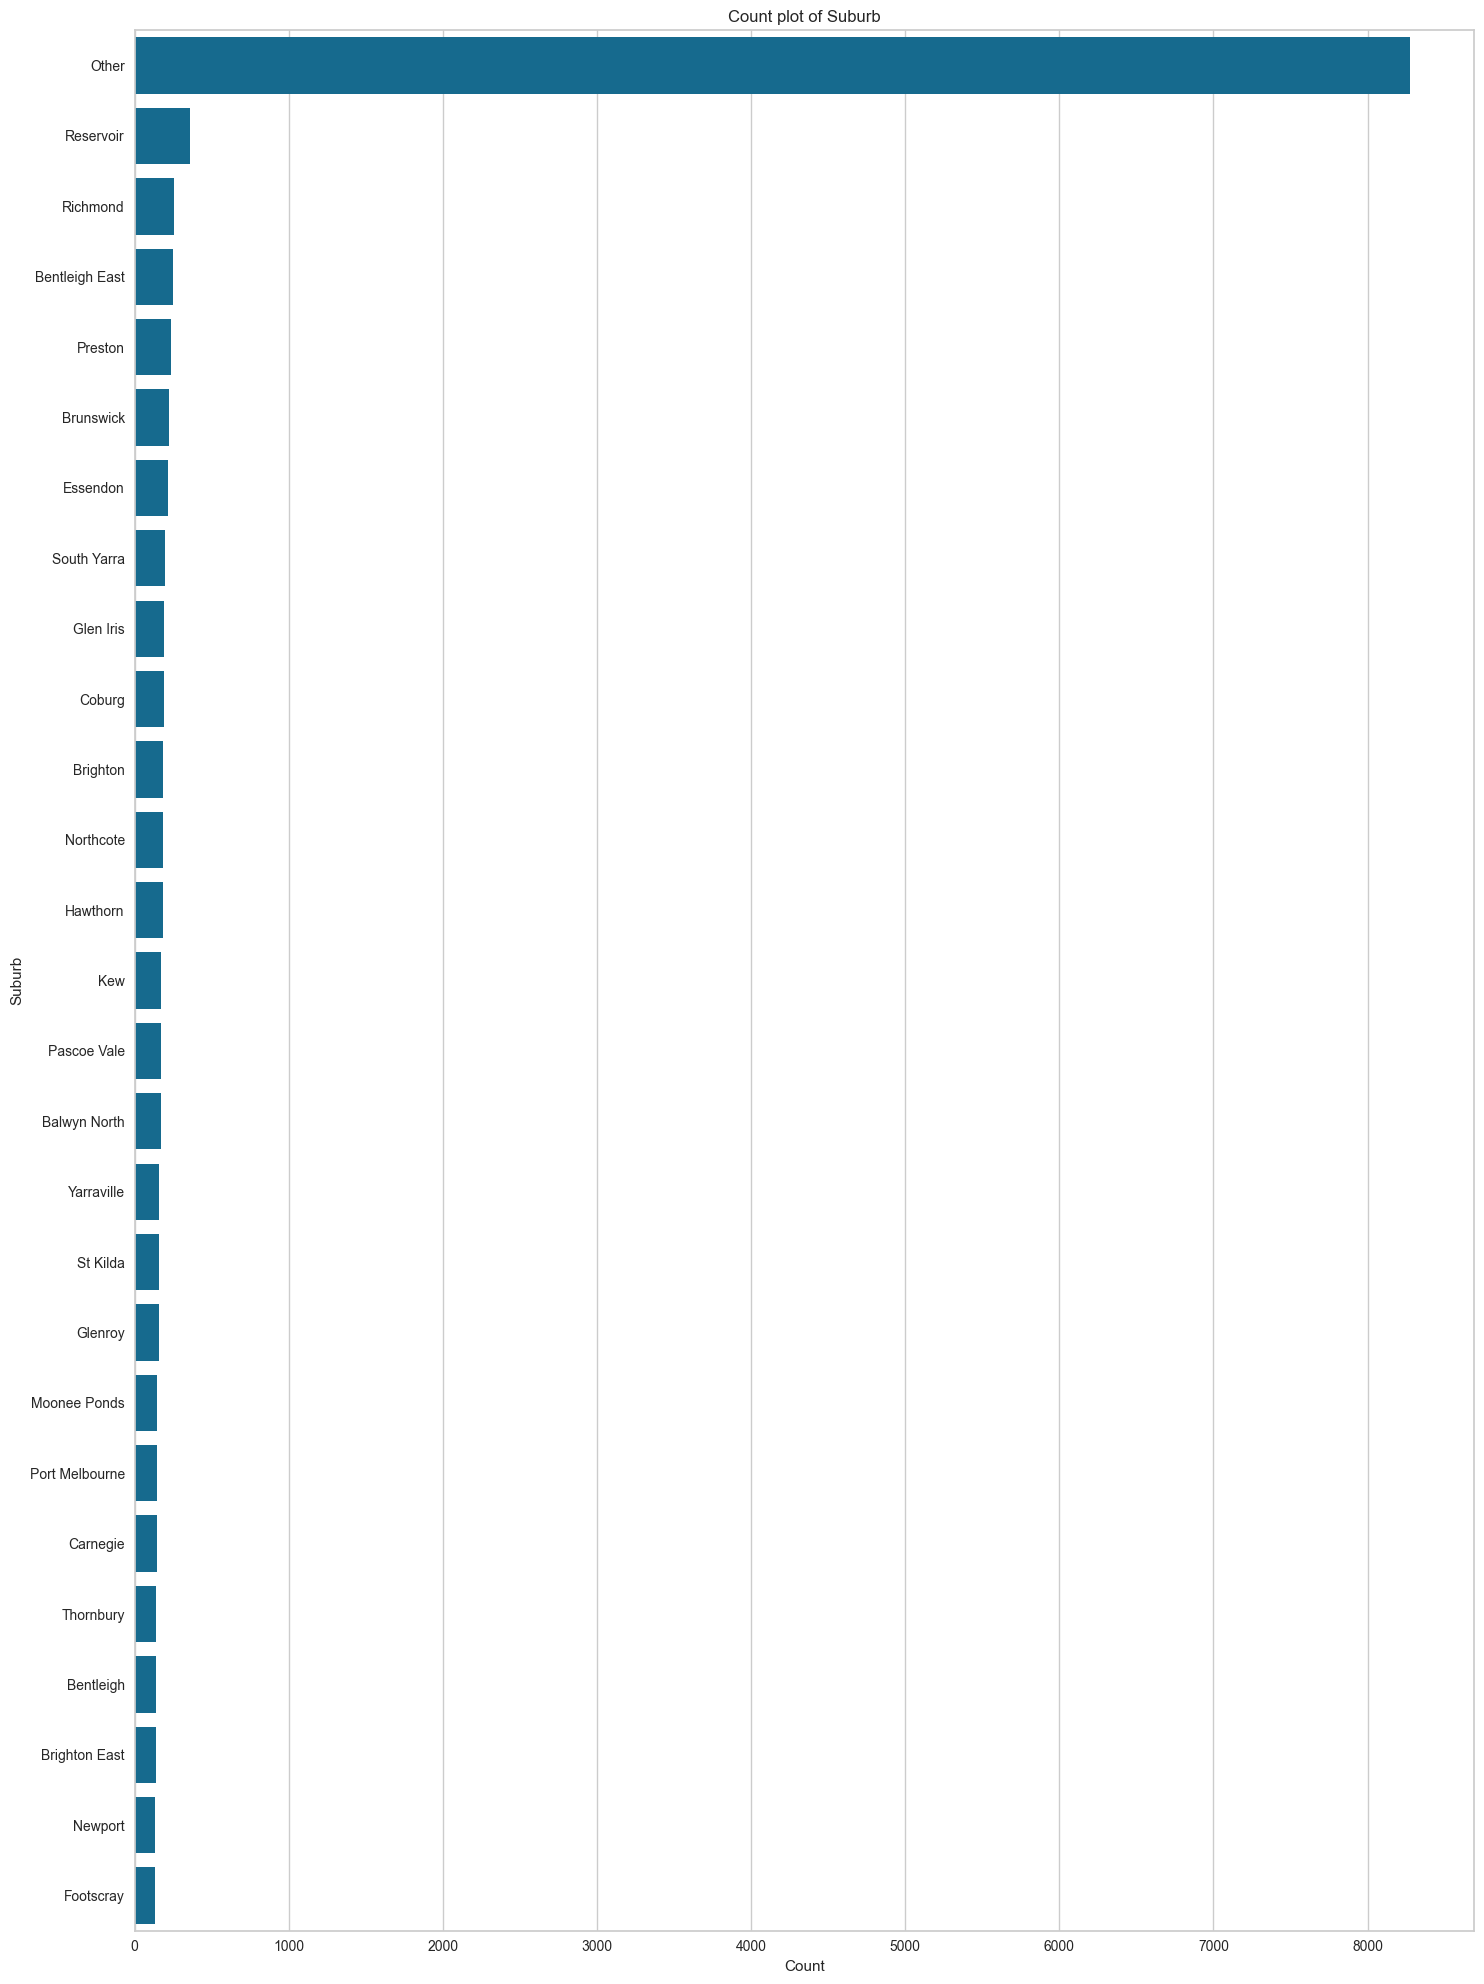

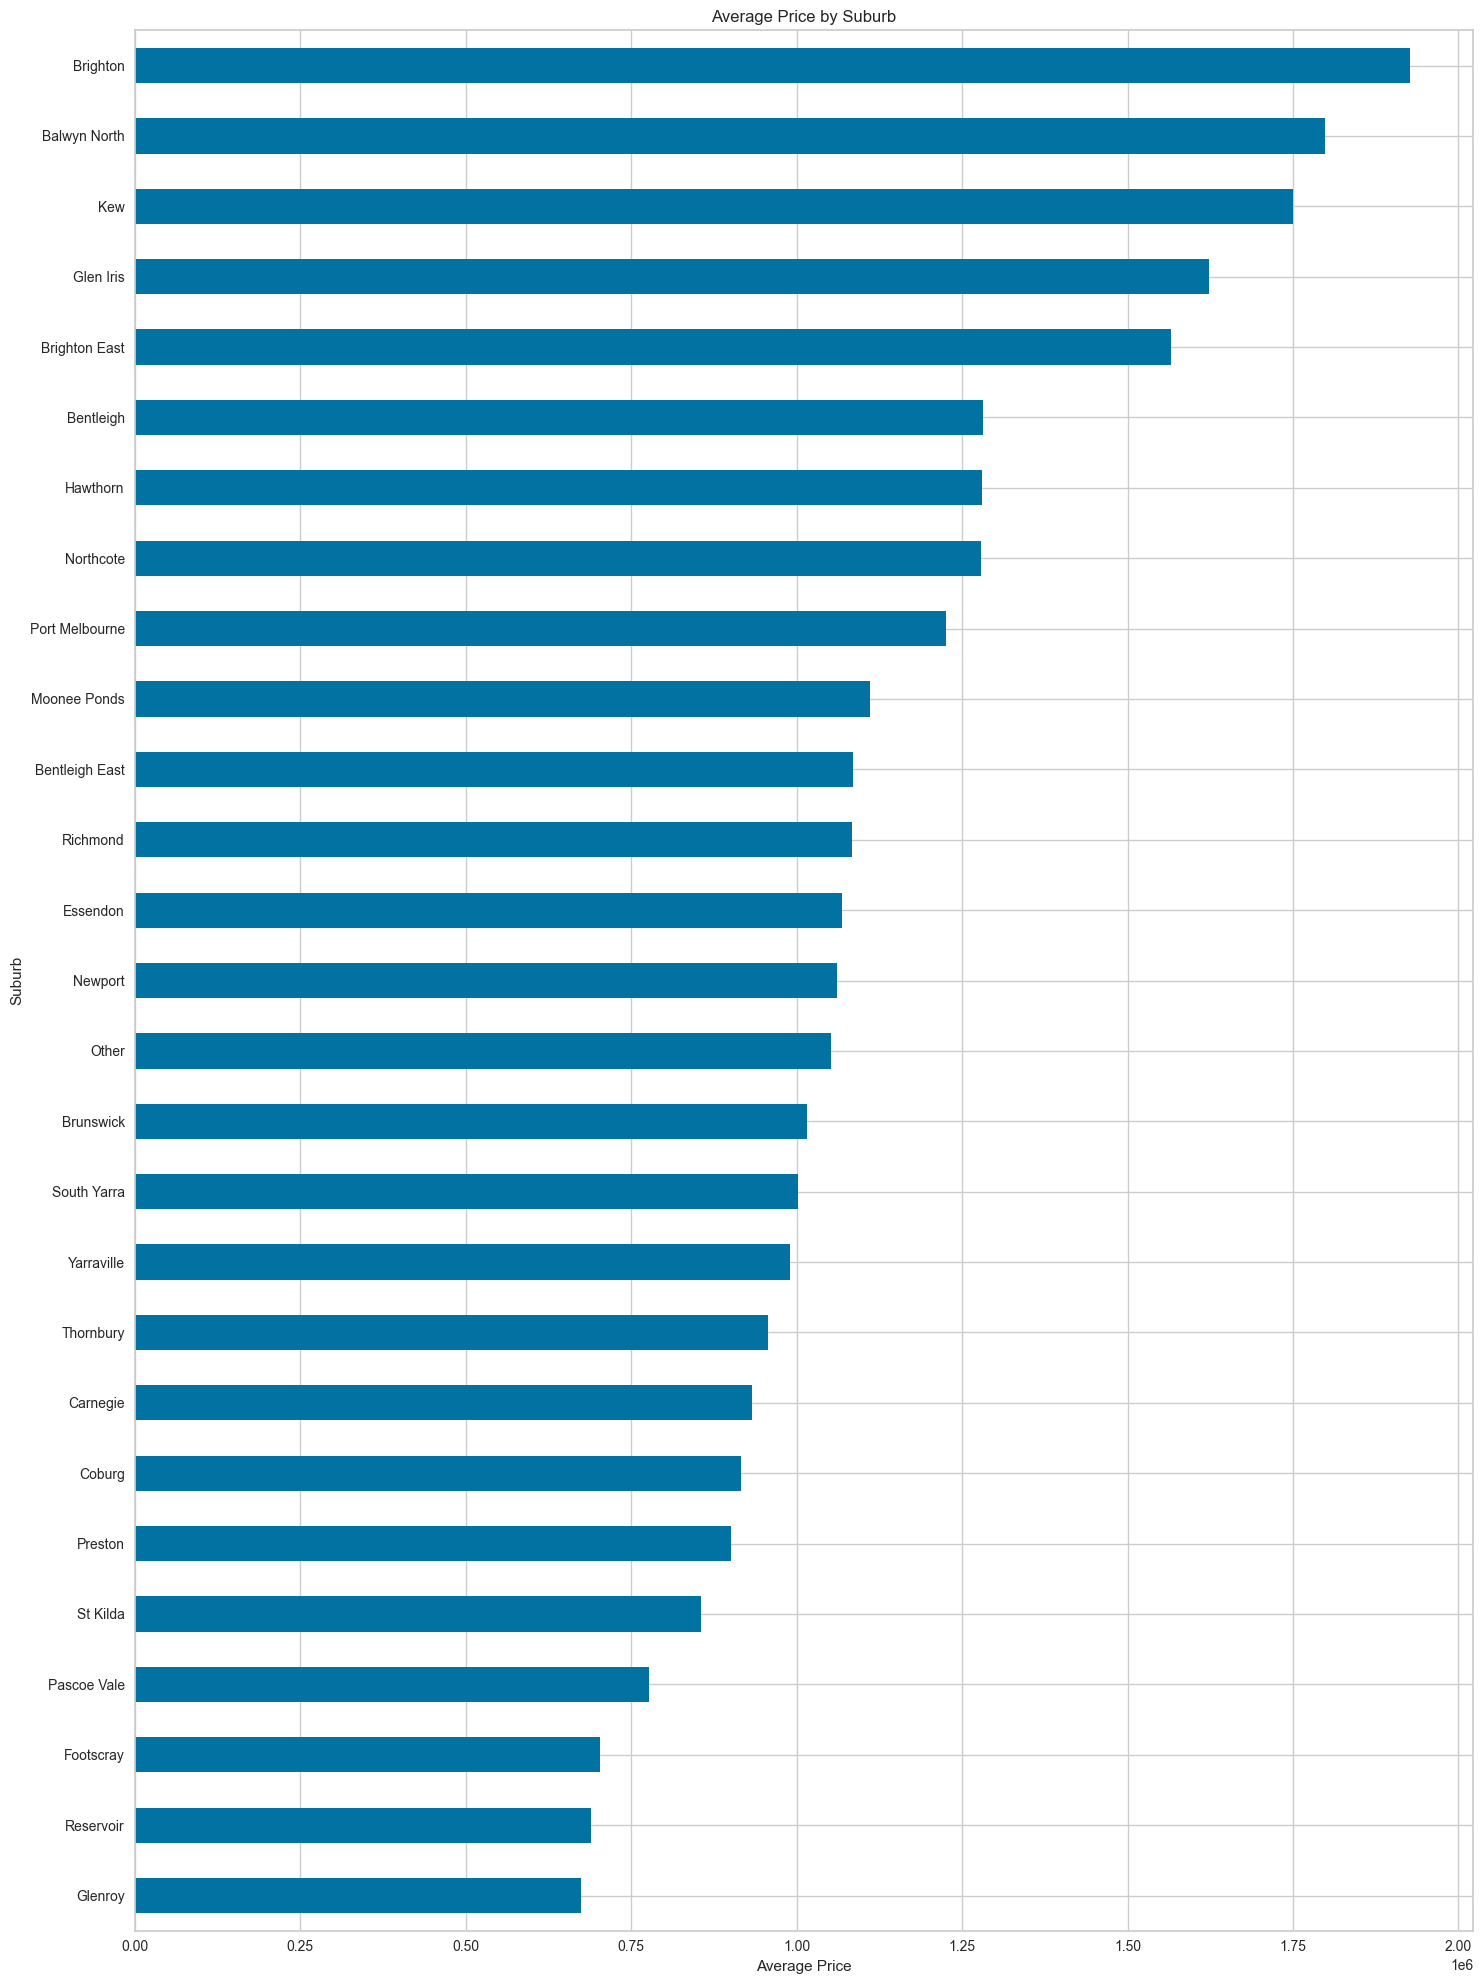

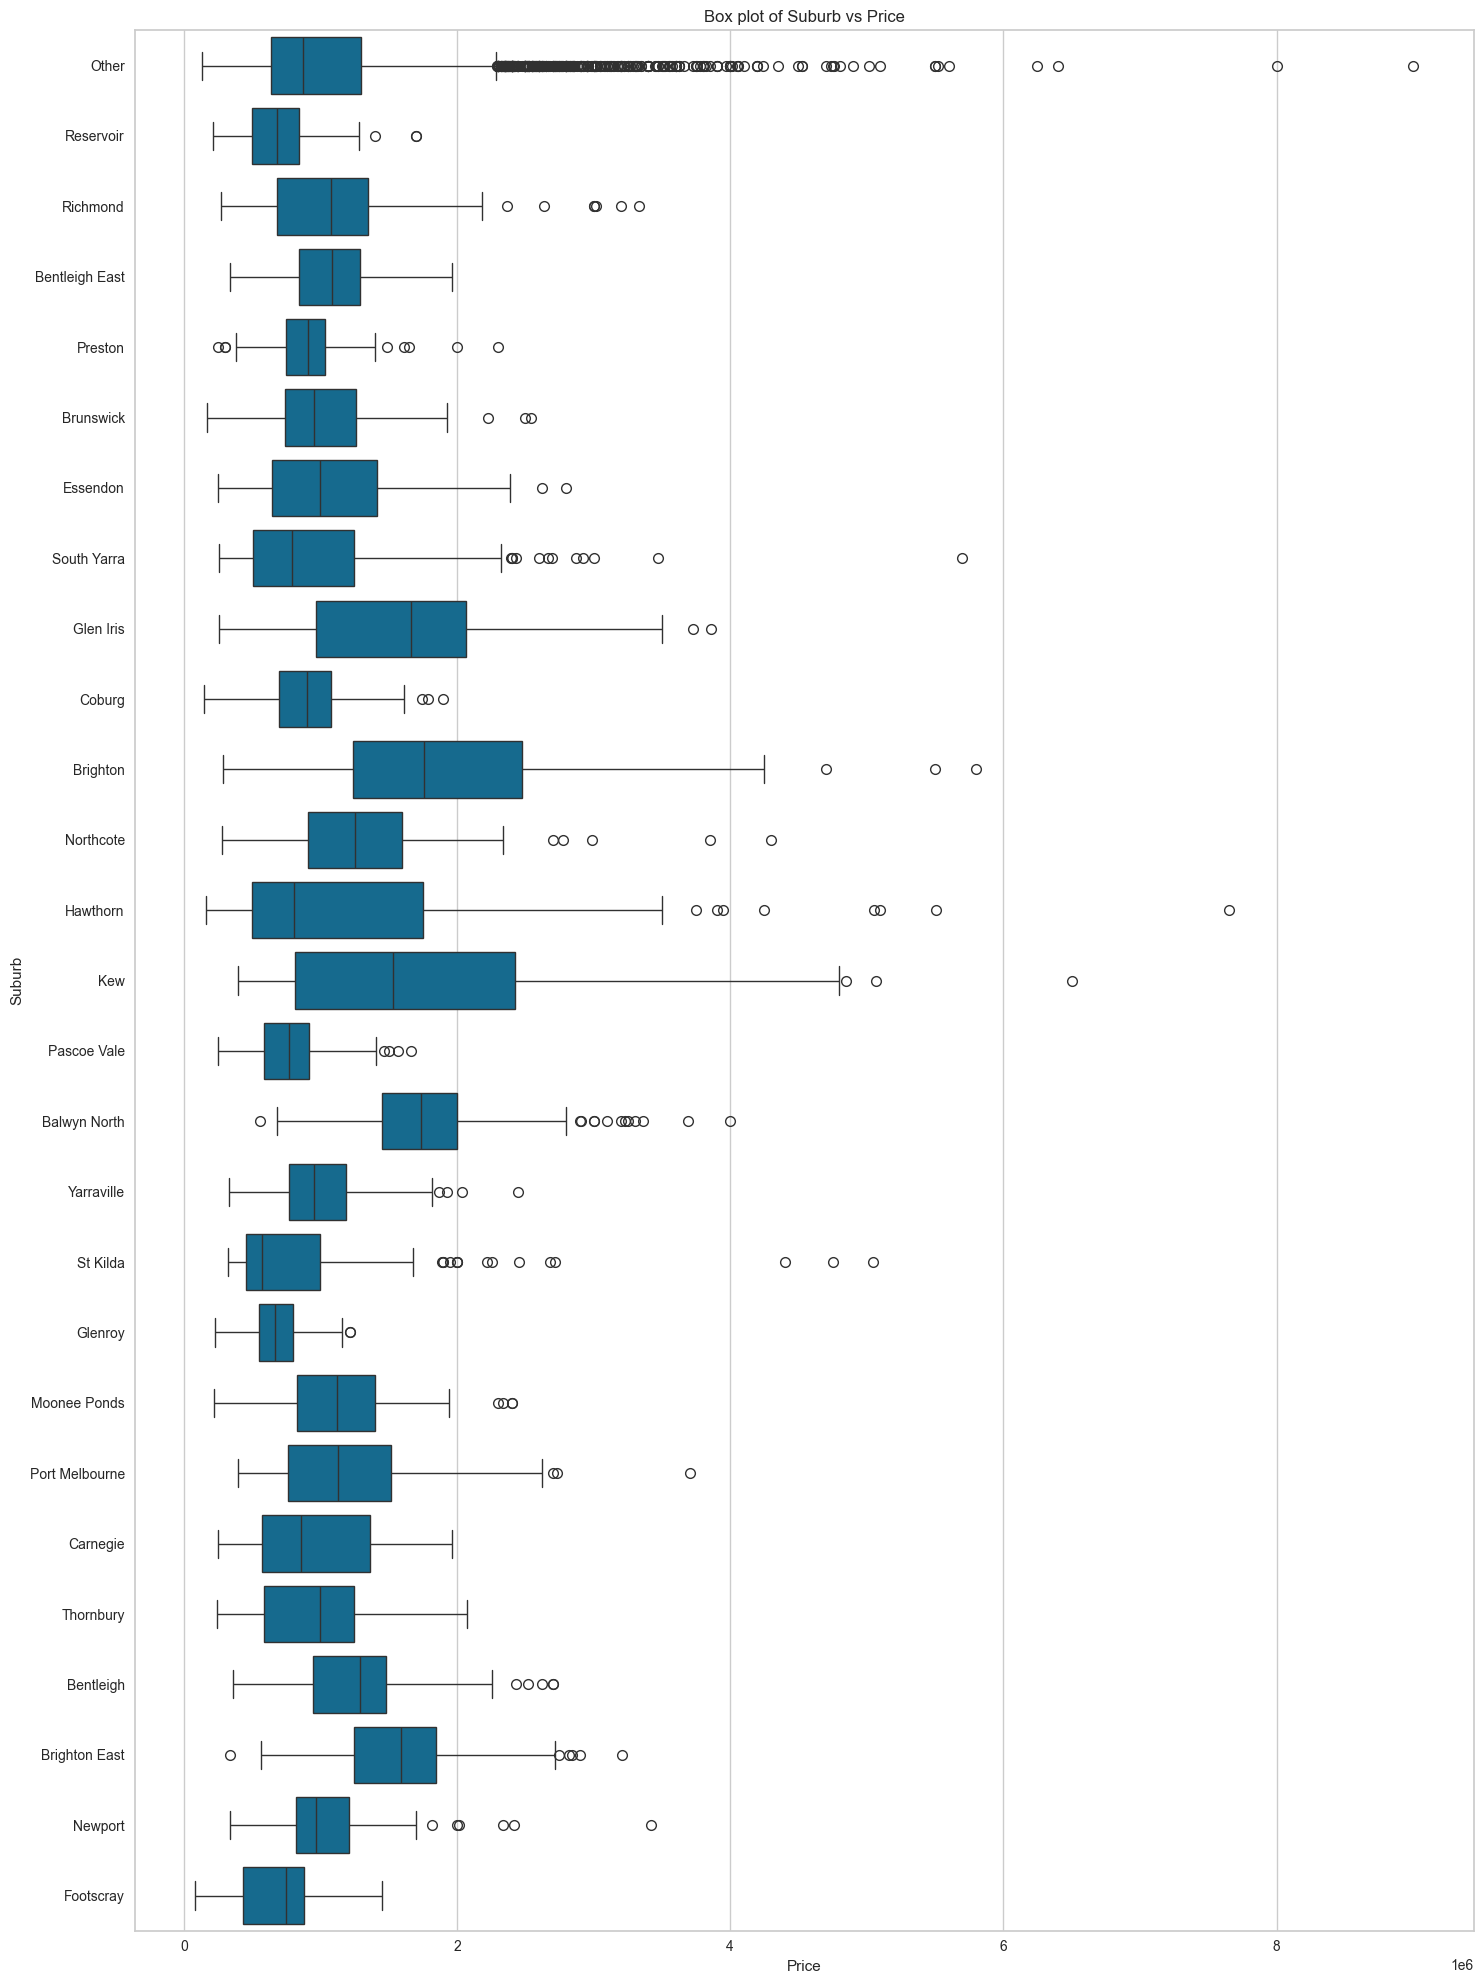

In [41]:
# Count plot for Suburb
plt.figure(figsize=(15,20))
sb.countplot(data=housingdata, y='Suburb', order=housingdata['Suburb'].value_counts().index)
plt.title('Count plot of Suburb')
plt.xlabel('Count')
plt.ylabel('Suburb')
plt.tight_layout()
plt.show()

# Average price bar plot for Suburb
# We'll compute the average price per Suburb and plot it
avg_price = housingdata.groupby('Suburb')['Price'].mean().sort_values(ascending=True)

plt.figure(figsize=(15,20))
avg_price.plot(kind='barh')
plt.title('Average Price by Suburb')
plt.xlabel('Average Price')
plt.ylabel('Suburb')
plt.tight_layout()
plt.show()

# Box plot of Price distribution by Suburb
plt.figure(figsize=(15,20))
sb.boxplot(data=housingdata, y='Suburb', x='Price', order=housingdata['Suburb'].value_counts().index)
plt.title('Box plot of Suburb vs Price')
plt.xlabel('Price')
plt.ylabel('Suburb')
plt.tight_layout()
plt.show()

#### Dimensionality Reduction of SellerG

In [42]:
housingdata = group_rare_categories(housingdata, 'SellerG', threshold=0.01)

Let's check what SellerG looks like after dimensionality reduction.

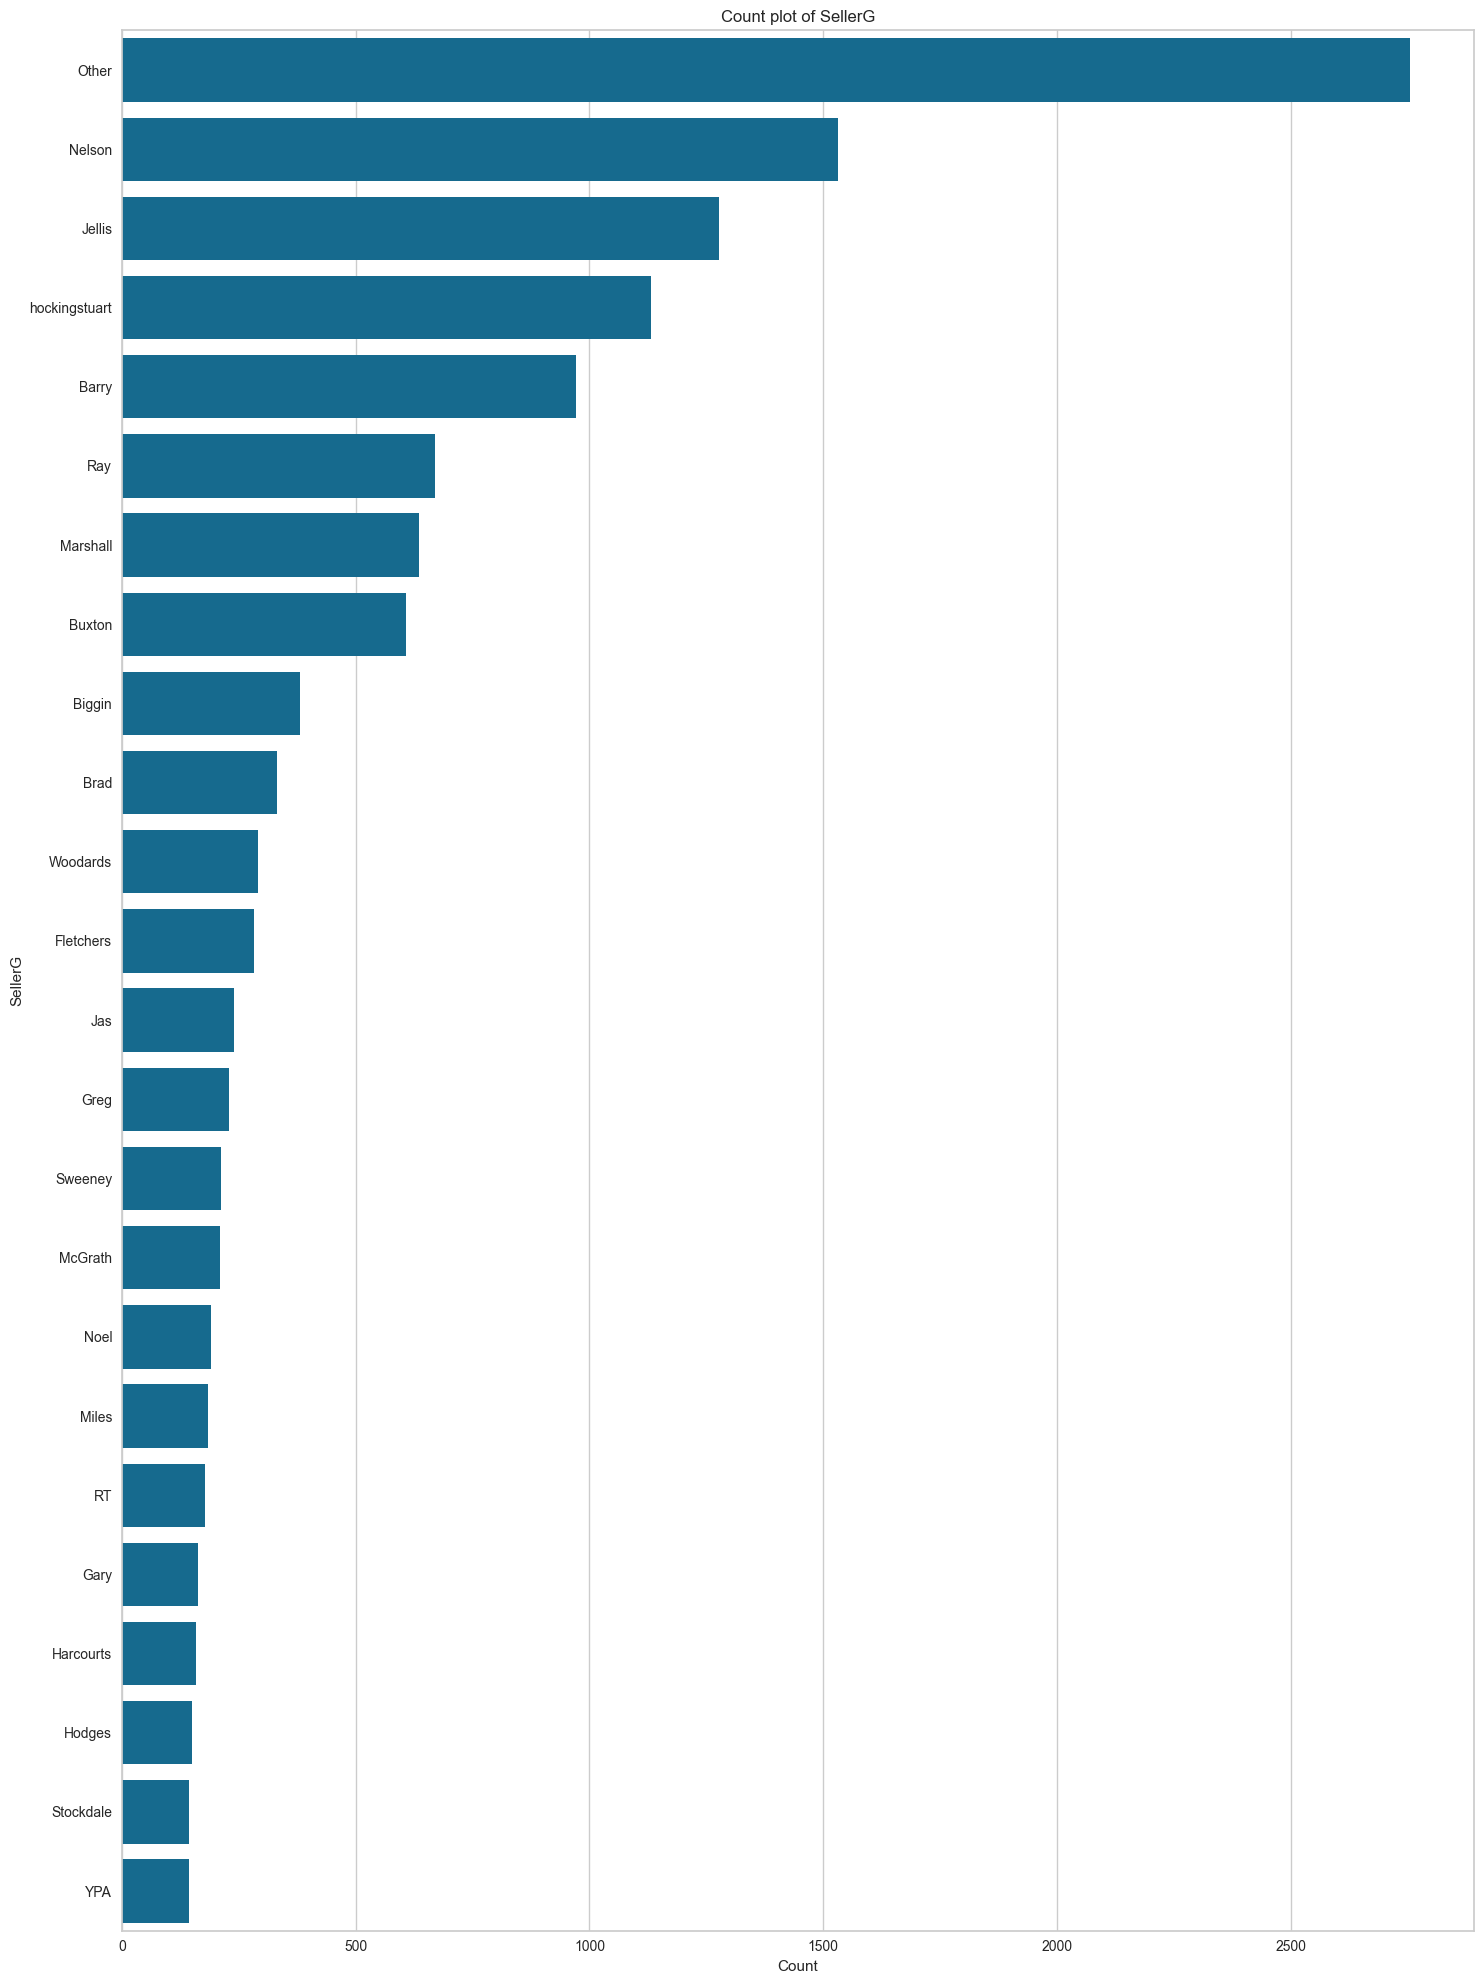

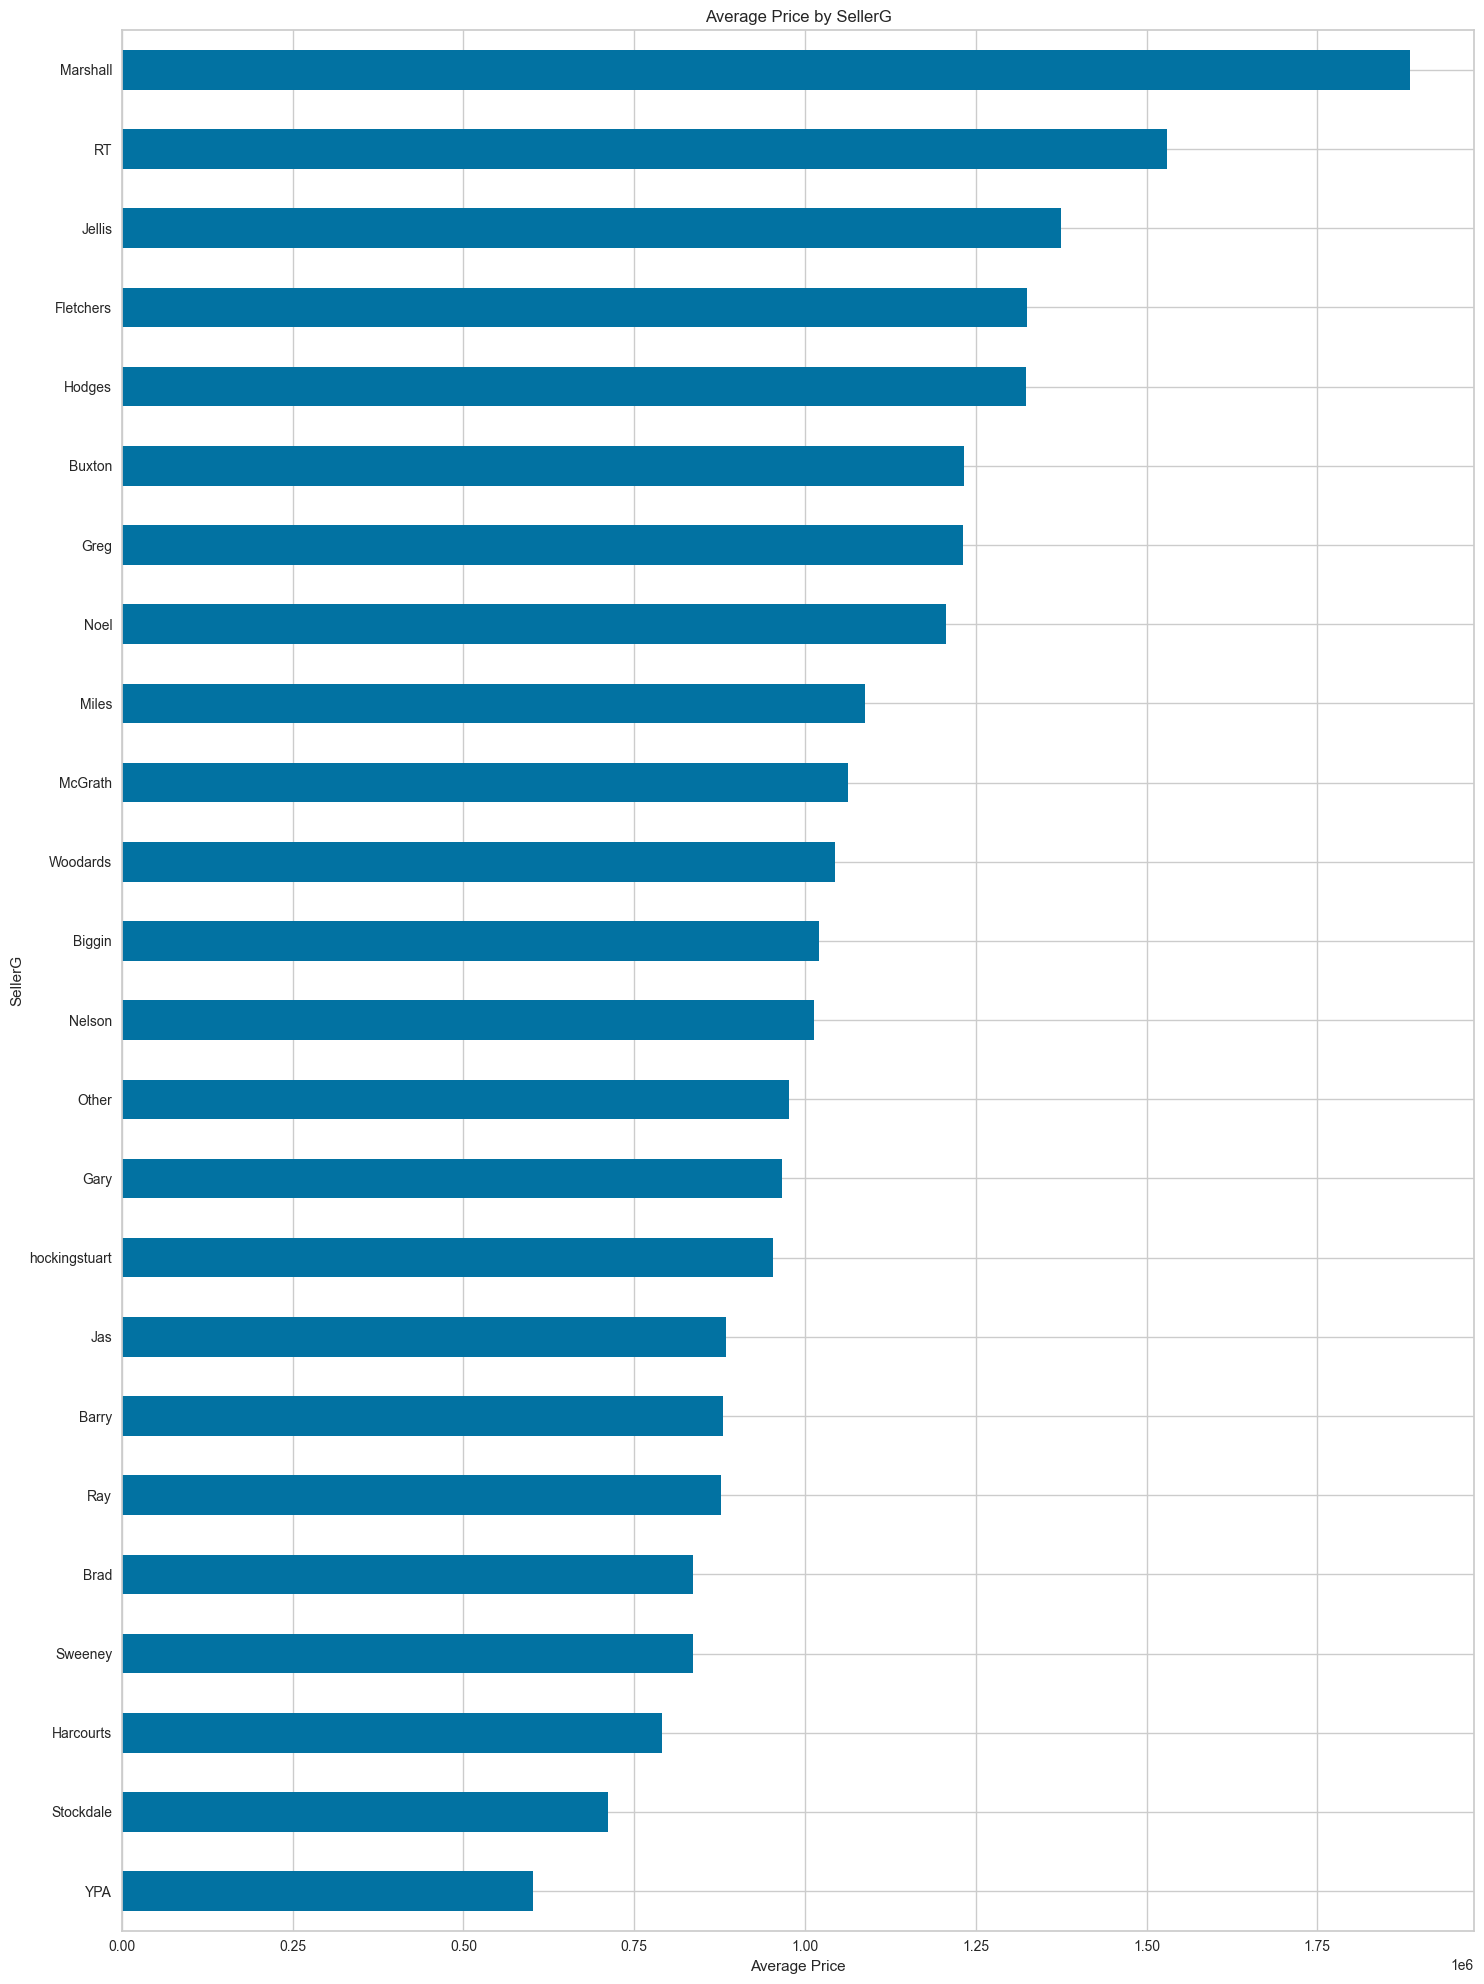

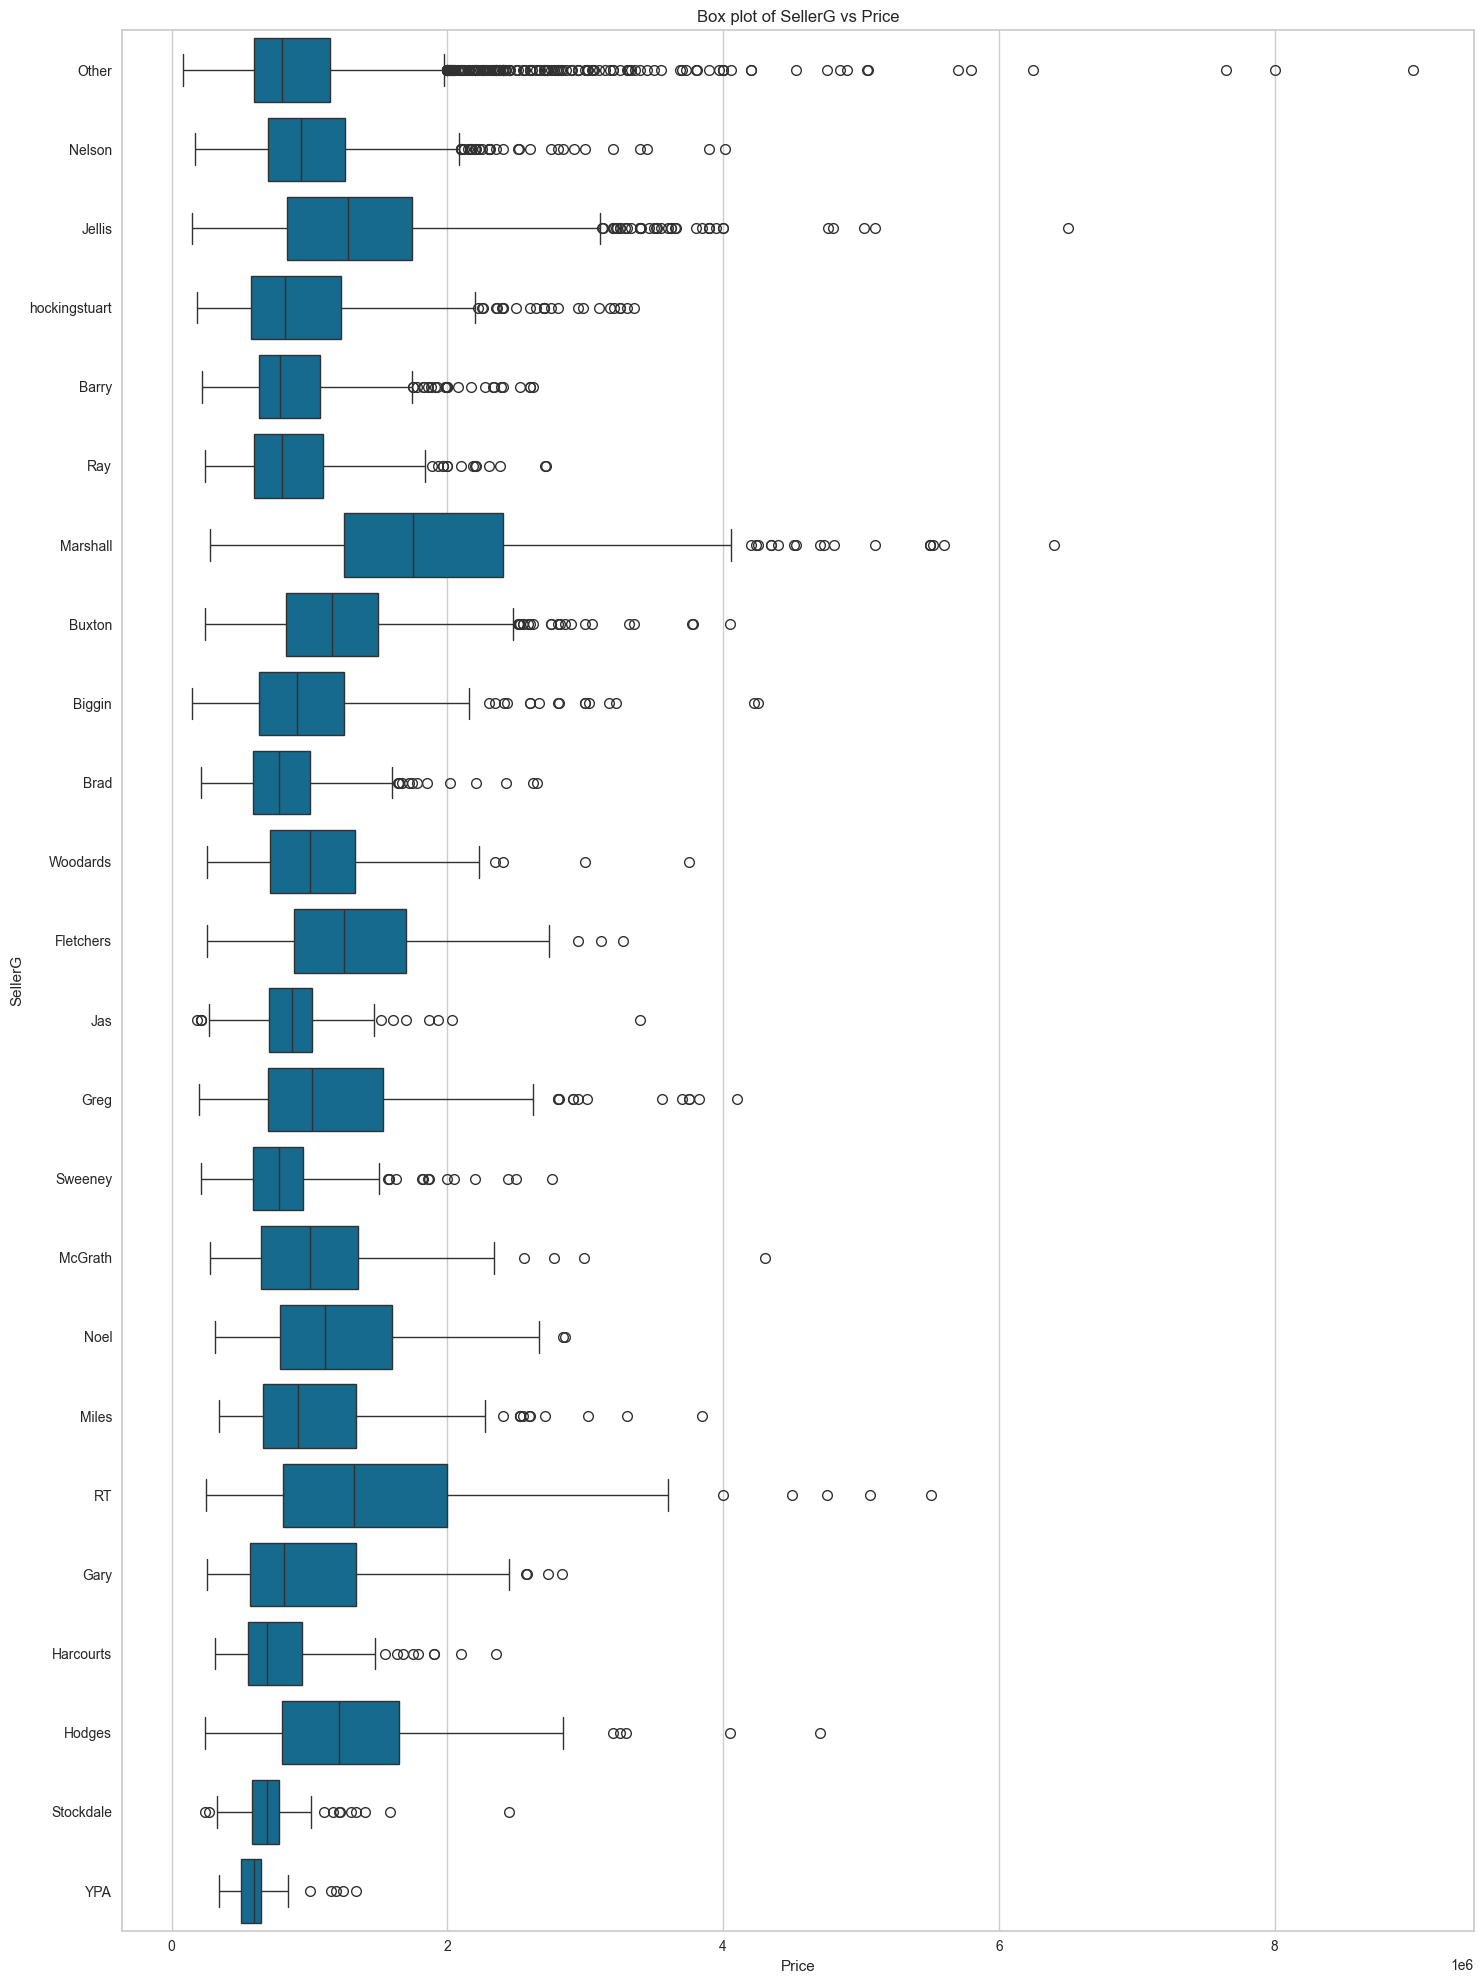

In [43]:
# Count plot for SellerG
plt.figure(figsize=(15,20))
sb.countplot(data=housingdata, y='SellerG', order=housingdata['SellerG'].value_counts().index)
plt.title('Count plot of SellerG')
plt.xlabel('Count')
plt.ylabel('SellerG')
plt.tight_layout()
plt.show()

# Average price bar plot for SellerG
# We'll compute the average price per SellerG and plot it
avg_price = housingdata.groupby('SellerG')['Price'].mean().sort_values(ascending=True)

plt.figure(figsize=(15,20))
avg_price.plot(kind='barh')
plt.title('Average Price by SellerG')
plt.xlabel('Average Price')
plt.ylabel('SellerG')
plt.tight_layout()
plt.show()

# Box plot of Price distribution by SellerG
plt.figure(figsize=(15,20))
sb.boxplot(data=housingdata, y='SellerG', x='Price', order=housingdata['SellerG'].value_counts().index)
plt.title('Box plot of SellerG vs Price')
plt.xlabel('Price')
plt.ylabel('SellerG')
plt.tight_layout()
plt.show()

#### Dimensionality Reduction of Address - Feature Elimination
We choose to drop 'Address' entirely as it is highly granular and provides little to no relevance in predicting house prices. Removing it contributes to reducing the overall dimensionality of the dataset.

In [44]:
housingdata = housingdata.drop(columns=['Address'])

### 2. Feature Engineering

#### Feature Engineering of 'Date' Variable
Since we are planning to use 'Date' as a time-based feature in trend analysis, we convert it from a string to datetime format and extract additional time-based features such as 'Year', 'Month', and 'YearMonth'. These derived variables will allow us to identify patterns across different regions over time.

In [45]:
# Convert 'Date' to datetime format
housingdata['Date'] = pd.to_datetime(housingdata['Date'], dayfirst=True)

# Create new time-based features
housingdata['Year'] = housingdata['Date'].dt.year
housingdata['Month'] = housingdata['Date'].dt.month
housingdata['YearMonth'] = housingdata['Date'].dt.to_period('M')

print(housingdata[['Year', 'Month', 'YearMonth']].head())

   Year  Month YearMonth
0  2016     12   2016-12
1  2016      2   2016-02
2  2017      3   2017-03
3  2017      3   2017-03
4  2016      6   2016-06


## Core Analysis
1. Regression Analysis to predict Feature Importance
2. K-Means Clustering to observe Price Trends across different regions
3.

### 1. Regression Analysis

In [46]:
# Separate target
y = housingdata["Price"]
X = housingdata.drop(columns=["Price"])

# Identify categorical features
categorical_cols = X.select_dtypes(include=["object", "category"]).columns
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns

# Identify datetime columns
datetime_cols = X.select_dtypes(include=["datetime", "datetime64[ns]"]).columns

# Convert datetime features to numeric (example: just using year for simplicity)
for col in datetime_cols:
    X[col] = pd.to_datetime(X[col], errors='coerce')  # ensure correct format
    X[col + "_year"] = X[col].dt.year
    X[col + "_month"] = X[col].dt.month
    X = X.drop(columns=[col])  # drop original datetime
# Convert Period columns to string, then to datetime, then to integer year/month
for col in X.columns:
    if X[col].dtype.name.startswith("period"):
        X[col] = X[col].astype(str)
        try:
            X[col] = pd.to_datetime(X[col])
            X[col] = X[col].dt.year  # or .dt.month if more relevant
        except Exception as e:
            print(f"Could not convert column {col}: {e}")

# Now re-encode categorical features
encoder = OrdinalEncoder()
X[categorical_cols] = encoder.fit_transform(X[categorical_cols].astype(str))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LINEAR REGRESSION
lr = LinearRegression()
lr.fit(X_train, y_train)
linear_importance = pd.Series(lr.coef_, index=X.columns).sort_values(ascending=False)
print("Linear Regression Feature Importance:")
print(linear_importance)

#  POLYNOMIAL (QUADRATIC) REGRESSION 
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size=0.2, random_state=42)

lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train_poly)
poly_feature_names = poly.get_feature_names_out(X.columns)
poly_importance = pd.Series(lr_poly.coef_, index=poly_feature_names).sort_values(ascending=False)
print("\nPolynomial Regression Feature Importance (Top 20):")
print(poly_importance.head(20))

#  RANDOM FOREST REGRESSOR 
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nRandom Forest Feature Importance:")
print(rf_importance)


Linear Regression Feature Importance:
Longtitude       1.130116e+06
Bathroom         2.274854e+05
Rooms            1.324517e+05
Car              5.365276e+04
Date_year        3.712733e+04
Year             3.712733e+04
YearMonth        3.712733e+04
Regionname       3.246026e+04
Bedroom2         2.773026e+04
Month            7.063070e+03
Date_month       7.063070e+03
Postcode         8.630514e+02
BuildingArea     6.202253e+02
Landsize         2.999353e+00
Propertycount   -1.071838e+00
SellerG         -2.210479e+03
CouncilArea     -3.228786e+03
YearBuilt       -3.505618e+03
Suburb          -6.166301e+03
Method          -7.299810e+03
Distance        -4.678672e+04
Type            -1.653281e+05
Lattitude       -8.739891e+05
dtype: float64

Polynomial Regression Feature Importance (Top 20):
YearBuilt                4.524386e+06
Bedroom2 Lattitude       5.434729e+05
Lattitude^2              5.078956e+05
Lattitude Longtitude     3.451043e+05
Lattitude Regionname     2.599722e+05
Bedroom2 Longti

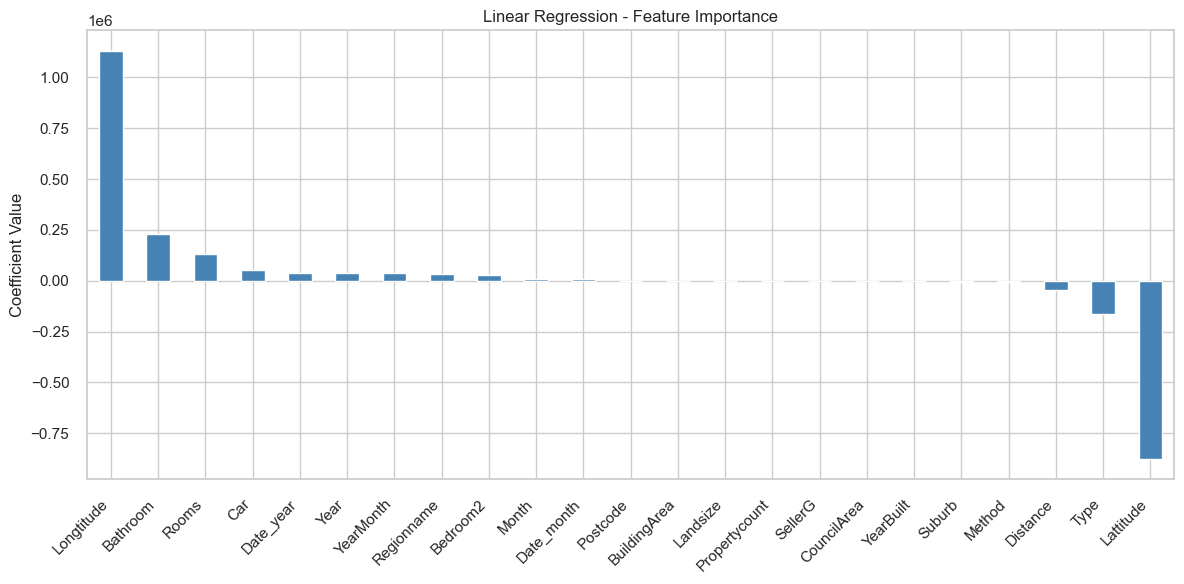

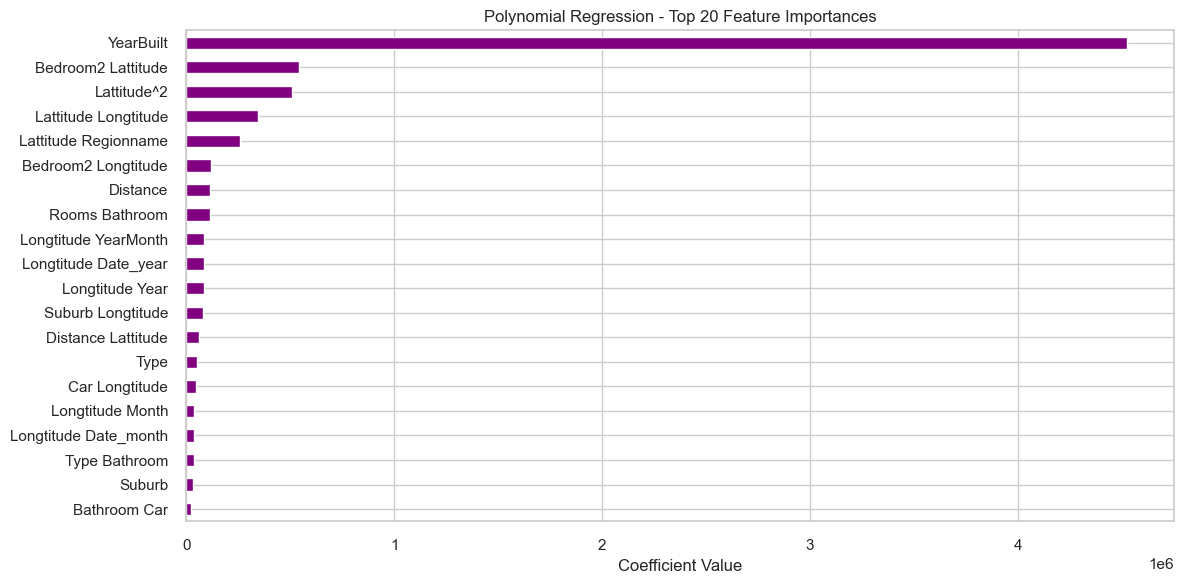

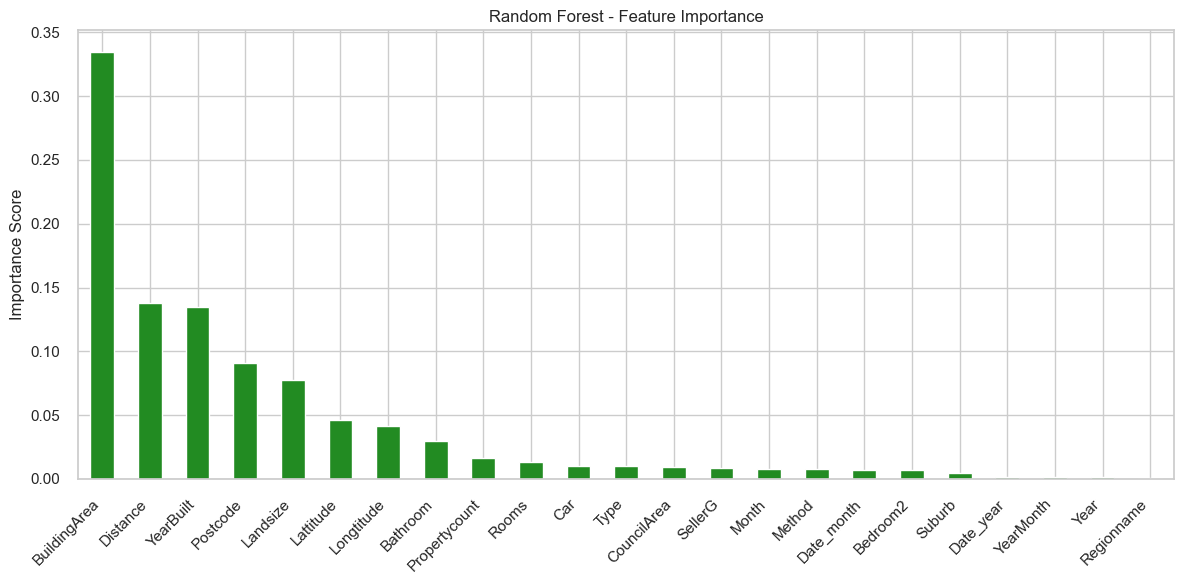

In [47]:
# Set style
sb.set(style="whitegrid")
plt.rcParams.update({'figure.figsize': (12, 6)})

#  Plot: Linear Regression Feature Importance 
plt.figure()
linear_importance.sort_values(ascending=False).plot(kind='bar', color='steelblue')
plt.title("Linear Regression - Feature Importance")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#  Plot: Polynomial Regression Feature Importance (Top 20) 
plt.figure()
poly_importance.head(20).sort_values().plot(kind='barh', color='purple')
plt.title("Polynomial Regression - Top 20 Feature Importances")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

#  Plot: Random Forest Feature Importance 
plt.figure()
rf_importance.sort_values(ascending=False).plot(kind='bar', color='forestgreen')
plt.title("Random Forest - Feature Importance")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


#### Improvements to Baseline Model
This is a base default reference that we will be using as comparison after we improve the model by applying the following techniques:

1. Dealing with Outliers
2. Feature Selection
3. Hyperparameter Tuning

Fitting 5 folds for each of 12 candidates, totalling 60 fits


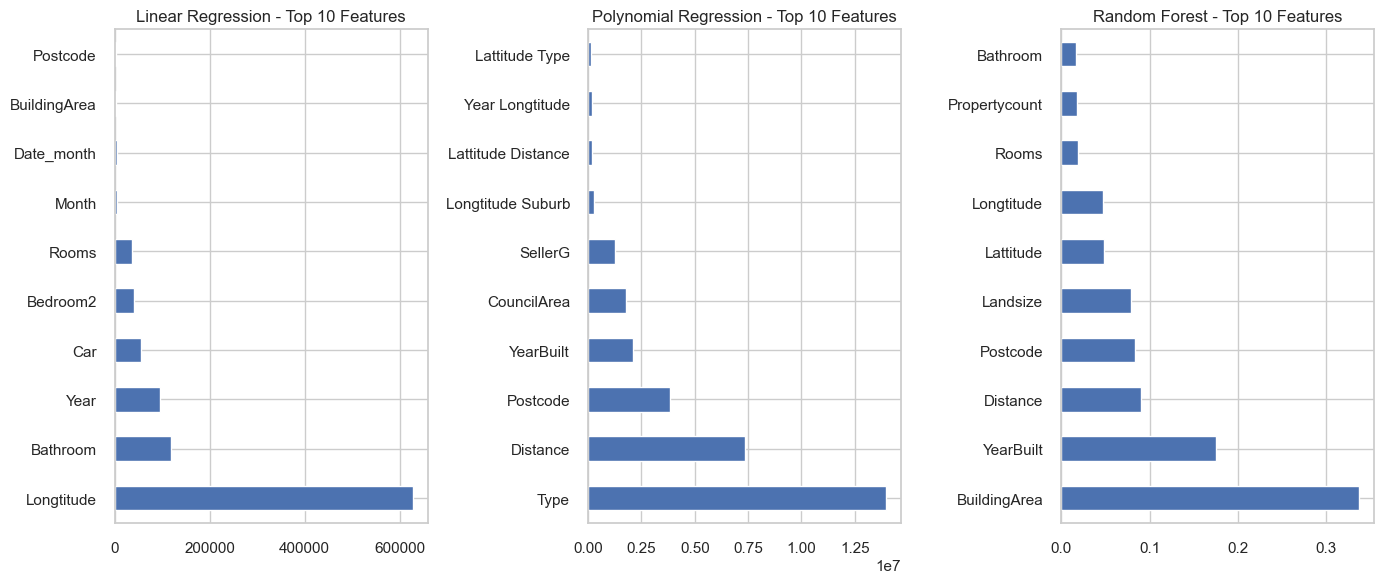

In [48]:
# Separate target
y = housingdata["Price"]
X = housingdata.drop(columns=["Price"])

#  Handle datetime and period features 
datetime_cols = X.select_dtypes(include=["datetime", "datetime64[ns]"]).columns
for col in datetime_cols:
    X[col] = pd.to_datetime(X[col], errors='coerce')
    X[col + "_year"] = X[col].dt.year
    X[col + "_month"] = X[col].dt.month
    X.drop(columns=[col], inplace=True)

for col in X.columns:
    if X[col].dtype.name.startswith("period"):
        X[col] = pd.to_datetime(X[col].astype(str), errors="coerce")
        X[col] = X[col].dt.year

#  Encode categorical variables 
categorical_cols = X.select_dtypes(include=["object", "category"]).columns
encoder = OrdinalEncoder()
X[categorical_cols] = encoder.fit_transform(X[categorical_cols].astype(str))

#  Remove outliers 
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns
z_scores = np.abs((X[numerical_cols] - X[numerical_cols].mean()) / X[numerical_cols].std())
X = X[(z_scores < 3).all(axis=1)]
y = y[X.index]  # keep y aligned with X

#  Feature Selection 
# 1. Correlation-based selection
corr_with_target = X[numerical_cols].corrwith(y).abs()
top_corr_features = corr_with_target[corr_with_target > 0.1].index.tolist()

# 2. Random Forest-based selection
rf_temp = RandomForestRegressor(n_estimators=100, random_state=42)
rf_temp.fit(X, y)
rf_feature_importance = pd.Series(rf_temp.feature_importances_, index=X.columns).sort_values(ascending=False)
top_rf_features = rf_feature_importance.head(20).index.tolist()

# 3. Combine both
selected_features = list(set(top_corr_features + top_rf_features))
X = X[selected_features]

#  Train/Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  LINEAR REGRESSION 
lr = LinearRegression()
lr.fit(X_train, y_train)
linear_importance = pd.Series(lr.coef_, index=X.columns).sort_values(ascending=False)

#  POLYNOMIAL REGRESSION (degree=2) 
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size=0.2, random_state=42)

lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train_poly)
poly_feature_names = poly.get_feature_names_out(X.columns)
poly_importance = pd.Series(lr_poly.coef_, index=poly_feature_names).sort_values(ascending=False)

#  RANDOM FOREST REGRESSION with HYPERPARAMETER TUNING 
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, 
                           cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

rf_importance = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)

#  PLOTTING 
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
linear_importance.head(10).plot(kind='barh')
plt.title("Linear Regression - Top 10 Features")

plt.subplot(1, 3, 2)
poly_importance.head(10).plot(kind='barh')
plt.title("Polynomial Regression - Top 10 Features")

plt.subplot(1, 3, 3)
rf_importance.head(10).plot(kind='barh')
plt.title("Random Forest - Top 10 Features")

plt.tight_layout()
plt.show()


### 2. Price Trend 

                Regionname  FirstDate   LastDate AvgPrice_M PctChange  Cluster
     Southern Metropolitan 2016-01-28 2017-09-23       1.35     62.85        1
      Eastern Metropolitan 2016-02-04 2017-09-23       1.09     53.17        1
         Northern Victoria 2017-05-27 2017-09-23       0.56     51.14        2
South-Eastern Metropolitan 2016-02-04 2017-09-23       0.95     14.28        0
     Northern Metropolitan 2016-02-04 2017-09-23       0.90      9.12        0
          Eastern Victoria 2017-05-27 2017-09-23       0.71      8.02        2
      Western Metropolitan 2016-02-04 2017-09-23       0.87      0.69        0
          Western Victoria 2017-05-27 2017-09-23       0.41    -11.91        2


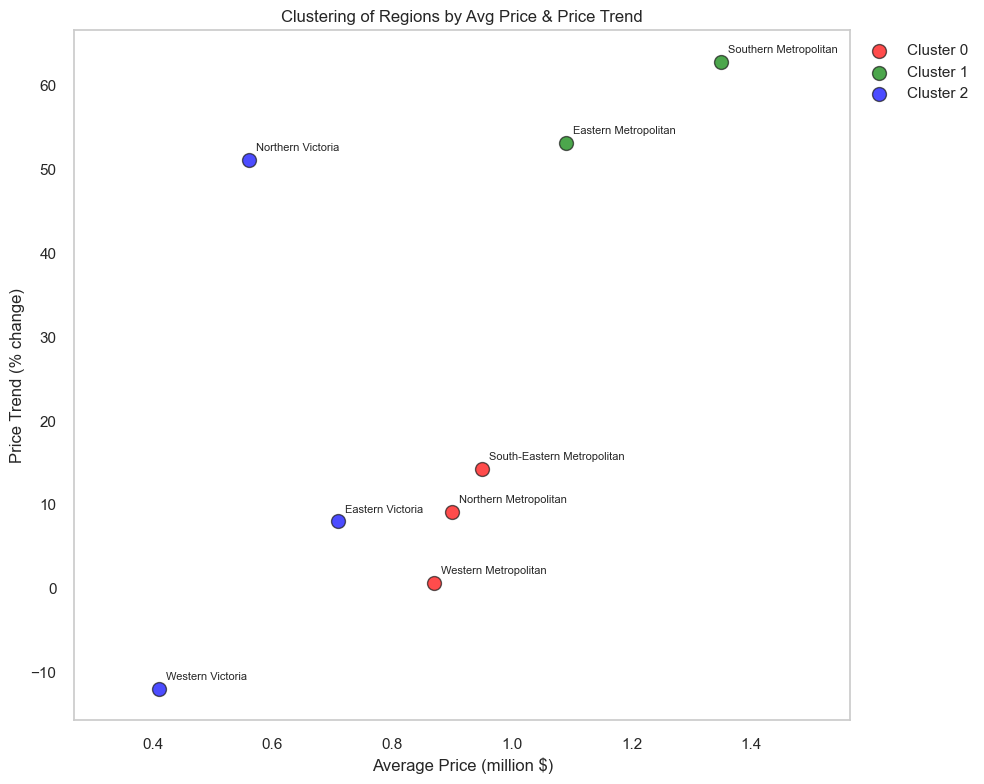

In [49]:
# 1. Ensure Date is datetime and sort
housingdata["Date"] = pd.to_datetime(housingdata["Date"], errors="coerce")
housingdata = housingdata.sort_values("Date")

# 2. Aggregate average price per Region per Date
region_date = (
    housingdata
    .groupby(["Regionname", "Date"])["Price"]
    .mean()
    .reset_index()
)

# 3. Build the trend table with first/last dates, prices, avg price, pct change
region_trends = []
for region in region_date["Regionname"].unique():
    rd = region_date[region_date["Regionname"] == region].sort_values("Date")
    if len(rd) < 2: 
        continue
    first_date  = rd.iloc[0]["Date"]
    last_date   = rd.iloc[-1]["Date"]
    first_price = rd.iloc[0]["Price"]
    last_price  = rd.iloc[-1]["Price"]
    pct_change  = ((last_price - first_price) / first_price) * 100 if first_price != 0 else 0
    avg_price   = rd["Price"].mean()
    region_trends.append({
        "Regionname": region,
        "FirstDate":  first_date,
        "LastDate":   last_date,
        "AvgPrice":   avg_price,
        "PctChange":  pct_change
    })

trend_df = pd.DataFrame(region_trends)

# 4. Convert avg price to millions and round
trend_df["AvgPrice_M"] = (trend_df["AvgPrice"] / 1e6).round(2)

# 5. K‑means clustering on [AvgPrice_M, PctChange]
features = trend_df[["AvgPrice_M", "PctChange"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
trend_df["Cluster"] = kmeans.fit_predict(X_scaled)

# 6. Sort by descending pct change (emerging → lowest)
trend_df = trend_df.sort_values("PctChange", ascending=False).reset_index(drop=True)


print(
    trend_df[["Regionname","FirstDate","LastDate","AvgPrice_M","PctChange","Cluster"]]
    .to_string(
        index=False,
        formatters={
            "FirstDate": lambda d: d.strftime("%Y-%m-%d"),
            "LastDate":  lambda d: d.strftime("%Y-%m-%d"),
            "AvgPrice_M": "{:.2f}".format,
            "PctChange":  "{:.2f}".format,
        }
    )
)

# 8. Static clustering scatterplot
fig, ax = plt.subplots(figsize=(10, 8))
colors = {0: "red", 1: "green", 2: "blue"}

for c in sorted(trend_df["Cluster"].unique()):
    sub = trend_df[trend_df["Cluster"] == c]
    ax.scatter(
        sub["AvgPrice_M"],
        sub["PctChange"],
        c=colors[c],
        label=f"Cluster {c}",
        s=100,
        alpha=0.7,
        edgecolor="k"
    )
    for _, row in sub.iterrows():
        ax.annotate(
            row["Regionname"],
            xy=(row["AvgPrice_M"], row["PctChange"]),
            xytext=(5, 5),
            textcoords="offset points",
            ha="left",
            va="bottom",
            fontsize=8
        )

# Remove inner gridlines but keep the border
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(True)

ax.margins(x=0.15, y=0.05)

xmin, xmax = ax.get_xlim()
ax.set_xlim(xmin, xmax * 1.05)

ax.set_xlabel("Average Price (million $)")
ax.set_ylabel("Price Trend (% change)")
ax.set_title("Clustering of Regions by Avg Price & Price Trend")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

### 3. Competitive Real Estate Markets